## Install packages

In [1]:
!pip3 install --user pandas
!pip3 install --user numpy
!pip3 install --user joblib
!pip3 install --user scipy
!pip3 install --user seaborn
!pip3 install --user tensorflow
!pip3 install --user sklearn
!pip3 install --user keras==2.3.0

## Import librairies

In [2]:
import os
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import array_to_img
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing

import random
from base64 import b64decode
from json import loads
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from tensorflow import keras
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, Lambda, Activation, ZeroPadding2D
from keras.models import Model, Sequential

import keras.backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

np.random.seed(seed=17)

Using TensorFlow backend.


## Aim of this notebook 

In this notebook we will test the second version of preprocessed data on autoencoder model, in order to:

- create a usable pipeline, easy to run
- test performance

This is a simple binary classification problem: failure or no failure.

## Simulation Subset Selection

Use the results summary file to select a subset of simulations for model training and testing:

- randomly select 500 non-fail cases and 200 fail cases
- use simulation ids to read in the corresponding simulation data files

### Import simulation results

In [3]:
results = pd.read_csv('processed_results_summary.csv', keep_default_na=False)
results.head()

,Unnamed: 0,Simulation no#,Line,Load,Wind1,Wind2,Wind3,flag,Sequence,n_failures,t_fail,t_first_fail,dt_fail,failed component_type,failed_component_type,cascade,fail
0,0,1,Line 04 - 05,0.7,0.0,0.0,0.0,0,[],0,,,,,,False,False
1,18,10,Line 26 - 28,0.7,0.0,0.0,0.0,0,[],0,,,,,,False,False
2,198,100,Line 09 - 39,0.7,0.0,0.0,0.4,0,[],0,,,,,,False,False
3,1998,1000,Line 22 - 23,0.7,0.0,0.8,1.0,0,[],0,,,,,,False,False
4,19998,10000,Line 10 - 11,0.8,0.4,0.2,0.0,0,[],0,,,,,,False,False


In [4]:
results['flag'].value_counts()

0    35934
1     7131
Name: flag, dtype: int64

### Get number of simulation files which are preprocessed

Otherwise there are many missing files (not all files were preprocessed)

In [5]:
root_dir = '/output/'

preprocessed_filenames = []
for file in os.listdir(os.path.join(root_dir, '02_preprocessed_numpy')):
    file = file.split('.')[0]
    preprocessed_filenames.append(int(file))

In [6]:
len(preprocessed_filenames)

25762

#### Get the simulation ids of sims with and without failures

In [7]:
fail_ids = results[results['flag']==1]['Simulation no#'].tolist()
non_fail_ids = results[results['flag']==0]['Simulation no#'].tolist()

#### Randomly select at least 100 fail and 500 non-fail cases

In [8]:
def intersection(lst1, lst2):
    """
    Return intersection of two given lists.
    """
    return list(set(lst1) & set(lst2))

In [9]:
length_intersection = 0
while length_intersection < 200:
    fail_ids = np.random.choice(fail_ids, size=400, replace=False)
    length_intersection = len(intersection(fail_ids, preprocessed_filenames))

In [10]:
length_intersection

278

In [11]:
new_fail_ids = intersection(fail_ids, preprocessed_filenames)

In [12]:
length_intersection = 0
while length_intersection < 700:
    non_fail_ids = np.random.choice(non_fail_ids, size=1500, replace=False)
    length_intersection = len(intersection(non_fail_ids, preprocessed_filenames))

In [13]:
length_intersection

831

In [14]:
new_non_fail_ids = intersection(non_fail_ids, preprocessed_filenames)

### Load preprocessed pickle files using previously obtained ids

In [15]:
def load_numpy(directory: str, filename: str) -> np.array:
    """
    Load a numpy array from pickle format.
    """
    path = os.path.join(directory, filename)
    np_array = joblib.load(path)
    return np_array

In [16]:
root_dir = '/output/'

subset = []
for file_name in new_fail_ids:
    try:
        arr = load_numpy(os.path.join(root_dir, '02_preprocessed_numpy'), str(file_name) + '.pkl')
        sim_col = [[file_name] for x in range(arr.shape[0])]
        label_col = [[1] for x in range(arr.shape[0])]
        arr = np.append(arr, sim_col, axis=1)
        arr = np.append(arr, label_col, axis=1)
        subset.append(arr)
    except FileNotFoundError as error:
        print(f'{error} for {file_name}')

for file_name in new_non_fail_ids:
    try:
        arr = load_numpy(os.path.join(root_dir, '02_preprocessed_numpy'), str(file_name) + '.pkl')
        sim_col = [[file_name] for x in range(arr.shape[0])]
        label_col = [[0] for x in range(arr.shape[0])]
        arr = np.append(arr, sim_col, axis=1)
        arr = np.append(arr, label_col, axis=1)
        subset.append(arr)
    except FileNotFoundError as error:
        print(f'{error} for {file_name}')

In [17]:
len(subset)

1109

### Generate train and test sets

- Generate evenly sized windows without shuffling the data and mixing different simulations
- Create source and target columns (the binary 'fail' column)
- Generate train and test sets with 80%-20% split

Model input formats:

- X -> (n_batch, n_time_steps, n_features)
- y -> (n_batch, n_time_steps, n_features)

In [18]:
def get_window(array, start_index, length, shift=25):
    x, y = [], []
    end_index = len(array) - length

    for i in range(start_index, end_index, shift):
        y.append(array[i:(i+length), -1][0])
        source = array[i:(i+length), 1:-2]
        x.append(source)

    return x, y

In [19]:
len(new_fail_ids), len(new_non_fail_ids)

(278, 831)

In [20]:
nb_fail_training = int(len(new_fail_ids)* (80/100))
nb_non_fail_training = int(len(new_non_fail_ids)* (80/100))

In [21]:
nb_fail_training, nb_non_fail_training

(222, 664)

In [22]:
train_ids = list(new_fail_ids[:nb_fail_training]) + list(new_non_fail_ids[:nb_non_fail_training])
test_ids = list(new_fail_ids[nb_fail_training:]) + list(new_non_fail_ids[nb_non_fail_training:])

train_X, train_y = [], []
test_X, test_y = [], []

for array in subset:
    if int(array[:, -2][0]) in train_ids:
        x, y = get_window(array, start_index=0, length=100)
        train_X.extend(x)
        train_y.extend(y)
    else:
        x, y = get_window(array, start_index=0, length=100)
        test_X.extend(x)
        test_y.extend(y)

In [23]:
# Convert train_x and test_x to 3d numpy array
x_train = np.array(train_X)
x_train = np.asarray(train_X).astype(np.float32)
y_train = np.array(train_y)

x_test = np.array(test_X)
x_test = np.asarray(test_X).astype(np.float32)
y_test = np.array(test_y)

### Creating a validation set for the autoencoder as a subset of the training data

In [24]:
shape = x_train.shape[0]
print(shape)
x_train_new = x_train[:int(shape*0.8), :, :]   #we are splitting the first index (number of samples) into 80-20% split, the inner dim should remain the same
x_train_val = x_train[int(shape*0.8):, :, :]

print(x_train_new.shape)
print(x_train_val.shape)

31896
(25516, 100, 259)
(6380, 100, 259)


In [25]:
x_train_plus = np.zeros((x_train_new.shape[0], x_train_new.shape[1], x_train_new.shape[2] + 1))
x_train_plus[:, :, :-1] = x_train_new

x_test_plus = np.zeros((x_test.shape[0], x_test.shape[1], x_test.shape[2] + 1))
x_test_plus[:, :, :-1] = x_test

x_val_plus = np.zeros((x_train_val.shape[0], x_train_val.shape[1], x_train_val.shape[2] + 1))
x_val_plus[:, :, :-1] = x_train_val

In [26]:
x_train_plus.shape, x_val_plus.shape, x_test_plus.shape

((25516, 100, 260), (6380, 100, 260), (8028, 100, 260))

In [27]:
x_train_red = x_train_plus[:, :, :]
x_val_red = x_val_plus[:, :, :]
x_test_red = x_test_plus[:, :, :]

print(x_train_red.shape)
print(x_test_red.shape)
print(x_val_red.shape)

(25516, 100, 260)
(8028, 100, 260)
(6380, 100, 260)


### Plotting the data as images (no failure, with failure)

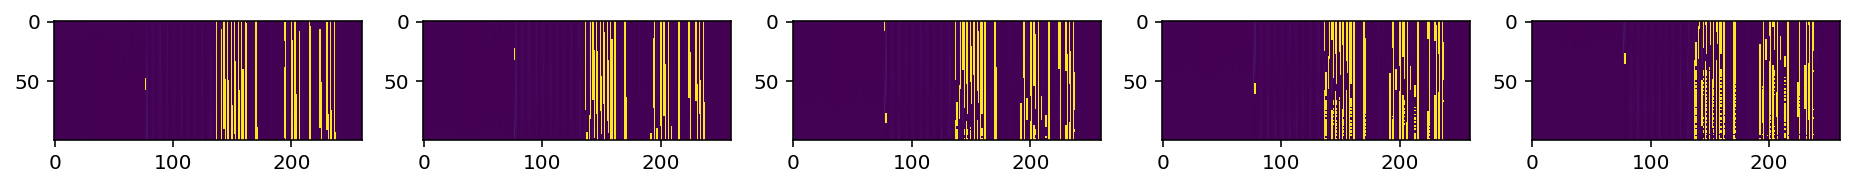

In [28]:
fig, axes = plt.subplots(1,5, figsize=(16,16))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train_red[i].astype(np.uint8))

### Model Training and Evaluation

- Train an autoencoder on samples with no failures
- Set a threshold based on the reconstruction loss statistics
- Evaluate on test data: accuracy, precision, recall, F1 score

In [29]:
x_train = x_train_red.astype('float32') / 255.
x_val = x_val_red.astype('float32') / 255.
x_test = x_test_red.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)


print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_test.shape)

(25516, 100, 260, 1)
(6380, 100, 260, 1)
(8028, 100, 260, 1)
(8028,)


In [30]:
def Threshold(losses_train, name):
    """
    Get the threshold
    """
    mean_mse = np.mean(losses_train)
    var_mse = np.var(losses_train)
    median_mse = np.median (losses_train)
    losses_min = np.min(losses_train)
    losses_max = np.max(losses_train)
    min_max = (losses_min + losses_max)/2
    std_mse = np.std(losses_train)
    std3 = 3*std_mse
    Q25 = np.percentile(losses_train, 25) #25th_percentile
    Q75 = np.percentile(losses_train, 75)#75th_percentile
    IQR = Q75 - Q25         #inter-quartile range
    IQR_Q3 = Q75  + 1.5 * IQR
    meanIQR = mean_mse  + 1.5 * IQR
    medIQR = median_mse  + 1.5 * IQR
    mean_std = mean_mse + std_mse
    median_std = median_mse +std_mse
    if name=="mean":
        threshold = mean_mse
    elif name=="median":
        threshold = median_mse
    elif name == "meanIQR":
        threshold= meanIQR
    elif name == "meanstd":
        threshold= mean_std
    elif name == "std3":
        threshold= std3
    elif name == "IQRq3":
        threshold= IQR_Q3
    elif name == "minmax":
        threshold= min_max
    return threshold

In [31]:
def mean_squared_loss(x1,x2):
    """
    Compute Euclidean Distance Loss  between
    input frame and the reconstructed frame
    """
    diff = x1-x2
    a,b,c,d = diff.shape
    n_samples = a*b*c*d
    sq_diff = diff**2
    Sum = sq_diff.sum()
    dist = np.sqrt(Sum)
    mean_dist = dist/n_samples
    return mean_dist

In [32]:
class AnomalyThresholdCallback(keras.callbacks.Callback):
    """
    Instead of computing threshold outside the training, we will use a callback that returns the total losses
    """
    
    def __init__(self, autoencoder):
        self.losses_train =[]
        self.threshold = 0
        self.autoencoder = autoencoder
        
    def on_train_end(self, logs=None):
        for number, bunch in enumerate(x_train):
            n_bunch=np.expand_dims(bunch,axis=0)
            reconstructed_bunch=self.autoencoder.predict(n_bunch)
            loss_train=mean_squared_loss(n_bunch,reconstructed_bunch)
            self.losses_train.append(loss_train)

In [33]:
x_train.shape[1], x_train.shape[2]

(100, 260)

In [34]:
def Autoencoder1(shape_x=x_train.shape[1], shape_y=x_train.shape[2]):
    """
    
    """
    input_img = Input(shape=(shape_x, shape_y, 1))

    # Encoding
    x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
    x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
    x = Conv2D(1,(3, 3), padding='same', activation='relu')(x)
    encoded = MaxPooling2D(pool_size=(2,2), padding='same')(x)

    # Decoding
    x = Conv2D(1,(3, 3), padding='same', activation='relu')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16,(3, 3), padding='same', activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1,(3, 2), padding='same')(x)
    #x= ZeroPadding2D(padding=1)(x)

    decoded = Activation('relu')(x)
    autoencoder = Model(input_img, decoded)
    autoencoder.summary()
    return autoencoder

In [35]:
def AELearning(buffer, batch_size, pretrain_epochs, x_val):
    """
    """
    autoencoder = Autoencoder1()
    thresholding =  AnomalyThresholdCallback(autoencoder)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(buffer, buffer, batch_size=batch_size, epochs=pretrain_epochs, verbose=1, callbacks=[thresholding], validation_data=(x_val,x_val))
    losses_xtrain = thresholding.losses_train
    return  autoencoder,losses_xtrain

In [36]:
def AnomalyDetection(stream, autoencoder, threshold):
    """
    """
    losses_test = []
    y_pred = []
    for number,bunch in enumerate(stream):
        n_bunch=np.expand_dims(bunch,axis=0)
        reconstructed_bunch=autoencoder.predict(n_bunch)
        loss=mean_squared_loss(n_bunch,reconstructed_bunch)
        losses_test.append(loss)
        if loss > threshold:
            y = 1 #abnormal (failure cases)
        else:
            y = 0 #normal (non-failure cases)
        y_pred.append(y)
    return y_pred,losses_test

### Start training the model

In [37]:
pretrain_epochs = 10
batch_size = 64

In [38]:
x_train.shape, x_val.shape

((25516, 100, 260, 1), (6380, 100, 260, 1))

In [39]:
AEmodel, losses_xtrain = AELearning(x_train, batch_size, pretrain_epochs, x_val)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 260, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 258, 16)       160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 129, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 129, 1)        145       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 65, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 65, 1)         10        
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 50, 130, 1)        0   

Train on 25516 samples, validate on 6380 samples
Epoch 1/10


   64/25516 [..............................] - ETA: 11:58 - loss: 5.6530e-05

  128/25516 [..............................] - ETA: 7:32 - loss: 5.4228e-05 

  192/25516 [..............................] - ETA: 6:05 - loss: 5.2108e-05

  256/25516 [..............................] - ETA: 5:19 - loss: 5.1918e-05

  320/25516 [..............................] - ETA: 4:53 - loss: 5.1742e-05

  384/25516 [..............................] - ETA: 4:35 - loss: 5.1082e-05

  448/25516 [..............................] - ETA: 4:22 - loss: 5.0466e-05

  512/25516 [..............................] - ETA: 4:14 - loss: 5.0317e-05

  576/25516 [..............................] - ETA: 4:07 - loss: 5.0018e-05

  640/25516 [..............................] - ETA: 3:59 - loss: 4.9722e-05

  704/25516 [..............................] - ETA: 3:54 - loss: 4.9696e-05

  768/25516 [..............................] - ETA: 3:50 - loss: 4.9765e-05

  832/25516 [..............................] - ETA: 3:46 - loss: 4.9690e-05

  896/25516 [>.............................] - ETA: 3:43 - loss: 4.9591e-05

  960/25516 [>.............................] - ETA: 3:39 - loss: 4.9372e-05

 1024/25516 [>.............................] - ETA: 3:37 - loss: 4.9319e-05

 1088/25516 [>.............................] - ETA: 3:33 - loss: 4.9319e-05

 1152/25516 [>.............................] - ETA: 3:31 - loss: 4.9244e-05

 1216/25516 [>.............................] - ETA: 3:29 - loss: 4.9096e-05

 1280/25516 [>.............................] - ETA: 3:27 - loss: 4.9078e-05

 1344/25516 [>.............................] - ETA: 3:25 - loss: 4.9016e-05

 1408/25516 [>.............................] - ETA: 3:24 - loss: 4.8850e-05

 1472/25516 [>.............................] - ETA: 3:22 - loss: 4.8732e-05

 1536/25516 [>.............................] - ETA: 3:21 - loss: 4.8670e-05

 1600/25516 [>.............................] - ETA: 3:20 - loss: 4.8509e-05

 1664/25516 [>.............................] - ETA: 3:19 - loss: 4.8354e-05

 1728/25516 [=>............................] - ETA: 3:17 - loss: 4.8368e-05

 1792/25516 [=>............................] - ETA: 3:16 - loss: 4.8279e-05

 1856/25516 [=>............................] - ETA: 3:15 - loss: 4.8227e-05

 1920/25516 [=>............................] - ETA: 3:14 - loss: 4.8135e-05

 1984/25516 [=>............................] - ETA: 3:13 - loss: 4.8014e-05

 2048/25516 [=>............................] - ETA: 3:11 - loss: 4.7838e-05

 2112/25516 [=>............................] - ETA: 3:10 - loss: 4.7745e-05

 2176/25516 [=>............................] - ETA: 3:10 - loss: 4.7540e-05

 2240/25516 [=>............................] - ETA: 3:08 - loss: 4.7402e-05

 2304/25516 [=>............................] - ETA: 3:08 - loss: 4.7235e-05

 2368/25516 [=>............................] - ETA: 3:07 - loss: 4.7148e-05

 2432/25516 [=>............................] - ETA: 3:06 - loss: 4.6989e-05

 2496/25516 [=>............................] - ETA: 3:05 - loss: 4.6841e-05

 2560/25516 [==>...........................] - ETA: 3:03 - loss: 4.6719e-05

 2624/25516 [==>...........................] - ETA: 3:03 - loss: 4.6606e-05

 2688/25516 [==>...........................] - ETA: 3:02 - loss: 4.6449e-05

 2752/25516 [==>...........................] - ETA: 3:01 - loss: 4.6298e-05

 2816/25516 [==>...........................] - ETA: 3:00 - loss: 4.6173e-05

 2880/25516 [==>...........................] - ETA: 2:59 - loss: 4.6073e-05

 2944/25516 [==>...........................] - ETA: 2:58 - loss: 4.5948e-05

 3008/25516 [==>...........................] - ETA: 2:57 - loss: 4.5797e-05

 3072/25516 [==>...........................] - ETA: 2:56 - loss: 4.5708e-05

 3136/25516 [==>...........................] - ETA: 2:55 - loss: 4.5607e-05

 3200/25516 [==>...........................] - ETA: 2:55 - loss: 4.5492e-05

 3264/25516 [==>...........................] - ETA: 2:54 - loss: 4.5420e-05

 3328/25516 [==>...........................] - ETA: 2:53 - loss: 4.5301e-05

 3392/25516 [==>...........................] - ETA: 2:53 - loss: 4.5221e-05

 3456/25516 [===>..........................] - ETA: 2:52 - loss: 4.5146e-05

 3520/25516 [===>..........................] - ETA: 2:52 - loss: 4.5055e-05

 3584/25516 [===>..........................] - ETA: 2:52 - loss: 4.4993e-05

 3648/25516 [===>..........................] - ETA: 2:52 - loss: 4.4939e-05

 3712/25516 [===>..........................] - ETA: 2:51 - loss: 4.4878e-05

 3776/25516 [===>..........................] - ETA: 2:50 - loss: 4.4785e-05

 3840/25516 [===>..........................] - ETA: 2:50 - loss: 4.4702e-05

 3904/25516 [===>..........................] - ETA: 2:49 - loss: 4.4631e-05

 3968/25516 [===>..........................] - ETA: 2:49 - loss: 4.4568e-05

 4032/25516 [===>..........................] - ETA: 2:48 - loss: 4.4486e-05

 4096/25516 [===>..........................] - ETA: 2:47 - loss: 4.4407e-05

 4160/25516 [===>..........................] - ETA: 2:47 - loss: 4.4328e-05

 4224/25516 [===>..........................] - ETA: 2:46 - loss: 4.4254e-05

 4288/25516 [====>.........................] - ETA: 2:46 - loss: 4.4179e-05

 4352/25516 [====>.........................] - ETA: 2:45 - loss: 4.4104e-05

 4416/25516 [====>.........................] - ETA: 2:44 - loss: 4.4018e-05

 4480/25516 [====>.........................] - ETA: 2:44 - loss: 4.3955e-05

 4544/25516 [====>.........................] - ETA: 2:43 - loss: 4.3898e-05

 4608/25516 [====>.........................] - ETA: 2:43 - loss: 4.3817e-05

 4672/25516 [====>.........................] - ETA: 2:42 - loss: 4.3745e-05

 4736/25516 [====>.........................] - ETA: 2:42 - loss: 4.3677e-05

 4800/25516 [====>.........................] - ETA: 2:41 - loss: 4.3624e-05

 4864/25516 [====>.........................] - ETA: 2:41 - loss: 4.3570e-05

 4928/25516 [====>.........................] - ETA: 2:40 - loss: 4.3509e-05

 4992/25516 [====>.........................] - ETA: 2:39 - loss: 4.3434e-05

 5056/25516 [====>.........................] - ETA: 2:39 - loss: 4.3374e-05

 5120/25516 [=====>........................] - ETA: 2:38 - loss: 4.3293e-05

 5184/25516 [=====>........................] - ETA: 2:38 - loss: 4.3234e-05

 5248/25516 [=====>........................] - ETA: 2:37 - loss: 4.3186e-05

 5312/25516 [=====>........................] - ETA: 2:37 - loss: 4.3137e-05

 5376/25516 [=====>........................] - ETA: 2:36 - loss: 4.3115e-05

 5440/25516 [=====>........................] - ETA: 2:36 - loss: 4.3092e-05

 5504/25516 [=====>........................] - ETA: 2:35 - loss: 4.3041e-05

 5568/25516 [=====>........................] - ETA: 2:34 - loss: 4.3003e-05

 5632/25516 [=====>........................] - ETA: 2:34 - loss: 4.2963e-05

 5696/25516 [=====>........................] - ETA: 2:33 - loss: 4.2911e-05

 5760/25516 [=====>........................] - ETA: 2:33 - loss: 4.2865e-05

 5824/25516 [=====>........................] - ETA: 2:32 - loss: 4.2821e-05

 5888/25516 [=====>........................] - ETA: 2:32 - loss: 4.2756e-05

 5952/25516 [=====>........................] - ETA: 2:31 - loss: 4.2702e-05

 6016/25516 [======>.......................] - ETA: 2:31 - loss: 4.2664e-05

 6080/25516 [======>.......................] - ETA: 2:30 - loss: 4.2637e-05

 6144/25516 [======>.......................] - ETA: 2:30 - loss: 4.2603e-05

 6208/25516 [======>.......................] - ETA: 2:29 - loss: 4.2572e-05

 6272/25516 [======>.......................] - ETA: 2:28 - loss: 4.2543e-05

 6336/25516 [======>.......................] - ETA: 2:28 - loss: 4.2503e-05

 6400/25516 [======>.......................] - ETA: 2:27 - loss: 4.2457e-05

 6464/25516 [======>.......................] - ETA: 2:27 - loss: 4.2427e-05

 6528/25516 [======>.......................] - ETA: 2:26 - loss: 4.2384e-05

 6592/25516 [======>.......................] - ETA: 2:26 - loss: 4.2362e-05

 6656/25516 [======>.......................] - ETA: 2:25 - loss: 4.2320e-05

 6720/25516 [======>.......................] - ETA: 2:25 - loss: 4.2277e-05

 6784/25516 [======>.......................] - ETA: 2:24 - loss: 4.2244e-05

 6848/25516 [=======>......................] - ETA: 2:24 - loss: 4.2190e-05

 6912/25516 [=======>......................] - ETA: 2:23 - loss: 4.2141e-05

 6976/25516 [=======>......................] - ETA: 2:23 - loss: 4.2104e-05

 7040/25516 [=======>......................] - ETA: 2:22 - loss: 4.2060e-05

 7104/25516 [=======>......................] - ETA: 2:22 - loss: 4.2014e-05

 7168/25516 [=======>......................] - ETA: 2:21 - loss: 4.1972e-05

 7232/25516 [=======>......................] - ETA: 2:21 - loss: 4.1928e-05

 7296/25516 [=======>......................] - ETA: 2:20 - loss: 4.1886e-05

 7360/25516 [=======>......................] - ETA: 2:20 - loss: 4.1830e-05

 7424/25516 [=======>......................] - ETA: 2:19 - loss: 4.1789e-05

 7488/25516 [=======>......................] - ETA: 2:18 - loss: 4.1761e-05

 7552/25516 [=======>......................] - ETA: 2:18 - loss: 4.1714e-05

 7616/25516 [=======>......................] - ETA: 2:17 - loss: 4.1684e-05

 7680/25516 [========>.....................] - ETA: 2:17 - loss: 4.1643e-05

 7744/25516 [========>.....................] - ETA: 2:16 - loss: 4.1605e-05

 7808/25516 [========>.....................] - ETA: 2:16 - loss: 4.1573e-05

 7872/25516 [========>.....................] - ETA: 2:15 - loss: 4.1536e-05

 7936/25516 [========>.....................] - ETA: 2:14 - loss: 4.1500e-05

 8000/25516 [========>.....................] - ETA: 2:14 - loss: 4.1473e-05

 8064/25516 [========>.....................] - ETA: 2:13 - loss: 4.1453e-05

 8128/25516 [========>.....................] - ETA: 2:13 - loss: 4.1408e-05

 8192/25516 [========>.....................] - ETA: 2:12 - loss: 4.1362e-05

 8256/25516 [========>.....................] - ETA: 2:12 - loss: 4.1323e-05

 8320/25516 [========>.....................] - ETA: 2:11 - loss: 4.1291e-05

 8384/25516 [========>.....................] - ETA: 2:10 - loss: 4.1267e-05

 8448/25516 [========>.....................] - ETA: 2:10 - loss: 4.1229e-05

 8512/25516 [=========>....................] - ETA: 2:09 - loss: 4.1184e-05

 8576/25516 [=========>....................] - ETA: 2:09 - loss: 4.1158e-05

 8640/25516 [=========>....................] - ETA: 2:08 - loss: 4.1113e-05

 8704/25516 [=========>....................] - ETA: 2:08 - loss: 4.1077e-05

 8768/25516 [=========>....................] - ETA: 2:07 - loss: 4.1043e-05

 8832/25516 [=========>....................] - ETA: 2:06 - loss: 4.1004e-05

 8896/25516 [=========>....................] - ETA: 2:06 - loss: 4.0971e-05

 8960/25516 [=========>....................] - ETA: 2:05 - loss: 4.0939e-05

 9024/25516 [=========>....................] - ETA: 2:05 - loss: 4.0890e-05

 9088/25516 [=========>....................] - ETA: 2:04 - loss: 4.0857e-05

 9152/25516 [=========>....................] - ETA: 2:04 - loss: 4.0816e-05

 9216/25516 [=========>....................] - ETA: 2:03 - loss: 4.0789e-05

 9280/25516 [=========>....................] - ETA: 2:03 - loss: 4.0749e-05

 9344/25516 [=========>....................] - ETA: 2:02 - loss: 4.0717e-05

 9408/25516 [==========>...................] - ETA: 2:01 - loss: 4.0676e-05

 9472/25516 [==========>...................] - ETA: 2:01 - loss: 4.0645e-05

 9536/25516 [==========>...................] - ETA: 2:00 - loss: 4.0607e-05

 9600/25516 [==========>...................] - ETA: 2:00 - loss: 4.0583e-05

 9664/25516 [==========>...................] - ETA: 1:59 - loss: 4.0551e-05

 9728/25516 [==========>...................] - ETA: 1:59 - loss: 4.0523e-05

 9792/25516 [==========>...................] - ETA: 1:58 - loss: 4.0481e-05

 9856/25516 [==========>...................] - ETA: 1:58 - loss: 4.0456e-05

 9920/25516 [==========>...................] - ETA: 1:57 - loss: 4.0425e-05

 9984/25516 [==========>...................] - ETA: 1:57 - loss: 4.0397e-05

10048/25516 [==========>...................] - ETA: 1:56 - loss: 4.0375e-05

10112/25516 [==========>...................] - ETA: 1:56 - loss: 4.0340e-05

10176/25516 [==========>...................] - ETA: 1:55 - loss: 4.0316e-05

10240/25516 [===========>..................] - ETA: 1:55 - loss: 4.0286e-05

10304/25516 [===========>..................] - ETA: 1:54 - loss: 4.0250e-05

10368/25516 [===========>..................] - ETA: 1:54 - loss: 4.0225e-05

10432/25516 [===========>..................] - ETA: 1:53 - loss: 4.0193e-05

10496/25516 [===========>..................] - ETA: 1:53 - loss: 4.0163e-05

10560/25516 [===========>..................] - ETA: 1:52 - loss: 4.0128e-05

10624/25516 [===========>..................] - ETA: 1:52 - loss: 4.0097e-05

10688/25516 [===========>..................] - ETA: 1:51 - loss: 4.0063e-05

10752/25516 [===========>..................] - ETA: 1:51 - loss: 4.0027e-05

10816/25516 [===========>..................] - ETA: 1:51 - loss: 3.9987e-05

10880/25516 [===========>..................] - ETA: 1:50 - loss: 3.9960e-05

10944/25516 [===========>..................] - ETA: 1:50 - loss: 3.9920e-05

11008/25516 [===========>..................] - ETA: 1:49 - loss: 3.9883e-05

11072/25516 [============>.................] - ETA: 1:49 - loss: 3.9852e-05

11136/25516 [============>.................] - ETA: 1:48 - loss: 3.9818e-05

11200/25516 [============>.................] - ETA: 1:48 - loss: 3.9781e-05

11264/25516 [============>.................] - ETA: 1:47 - loss: 3.9743e-05

11328/25516 [============>.................] - ETA: 1:47 - loss: 3.9711e-05

11392/25516 [============>.................] - ETA: 1:46 - loss: 3.9676e-05

11456/25516 [============>.................] - ETA: 1:46 - loss: 3.9643e-05

11520/25516 [============>.................] - ETA: 1:45 - loss: 3.9621e-05

11584/25516 [============>.................] - ETA: 1:45 - loss: 3.9590e-05

11648/25516 [============>.................] - ETA: 1:44 - loss: 3.9552e-05

11712/25516 [============>.................] - ETA: 1:44 - loss: 3.9512e-05

11776/25516 [============>.................] - ETA: 1:43 - loss: 3.9476e-05

11840/25516 [============>.................] - ETA: 1:43 - loss: 3.9436e-05

11904/25516 [============>.................] - ETA: 1:42 - loss: 3.9404e-05

11968/25516 [=============>................] - ETA: 1:42 - loss: 3.9373e-05

12032/25516 [=============>................] - ETA: 1:41 - loss: 3.9336e-05

12096/25516 [=============>................] - ETA: 1:41 - loss: 3.9303e-05

12160/25516 [=============>................] - ETA: 1:41 - loss: 3.9270e-05

12224/25516 [=============>................] - ETA: 1:40 - loss: 3.9239e-05

12288/25516 [=============>................] - ETA: 1:40 - loss: 3.9210e-05

12352/25516 [=============>................] - ETA: 1:39 - loss: 3.9171e-05

12416/25516 [=============>................] - ETA: 1:39 - loss: 3.9136e-05

12480/25516 [=============>................] - ETA: 1:38 - loss: 3.9104e-05

12544/25516 [=============>................] - ETA: 1:38 - loss: 3.9067e-05

12608/25516 [=============>................] - ETA: 1:37 - loss: 3.9033e-05

12672/25516 [=============>................] - ETA: 1:37 - loss: 3.8997e-05

12736/25516 [=============>................] - ETA: 1:36 - loss: 3.8964e-05

12800/25516 [==============>...............] - ETA: 1:36 - loss: 3.8932e-05

12864/25516 [==============>...............] - ETA: 1:35 - loss: 3.8900e-05

12928/25516 [==============>...............] - ETA: 1:35 - loss: 3.8867e-05

12992/25516 [==============>...............] - ETA: 1:34 - loss: 3.8834e-05

13056/25516 [==============>...............] - ETA: 1:34 - loss: 3.8798e-05

13120/25516 [==============>...............] - ETA: 1:33 - loss: 3.8763e-05

13184/25516 [==============>...............] - ETA: 1:33 - loss: 3.8723e-05

13248/25516 [==============>...............] - ETA: 1:32 - loss: 3.8692e-05

13312/25516 [==============>...............] - ETA: 1:32 - loss: 3.8656e-05

13376/25516 [==============>...............] - ETA: 1:31 - loss: 3.8632e-05

13440/25516 [==============>...............] - ETA: 1:31 - loss: 3.8593e-05

13504/25516 [==============>...............] - ETA: 1:30 - loss: 3.8558e-05

13568/25516 [==============>...............] - ETA: 1:30 - loss: 3.8534e-05

13632/25516 [===============>..............] - ETA: 1:29 - loss: 3.8504e-05

13696/25516 [===============>..............] - ETA: 1:29 - loss: 3.8474e-05

13760/25516 [===============>..............] - ETA: 1:28 - loss: 3.8439e-05

13824/25516 [===============>..............] - ETA: 1:28 - loss: 3.8416e-05

13888/25516 [===============>..............] - ETA: 1:27 - loss: 3.8385e-05

13952/25516 [===============>..............] - ETA: 1:27 - loss: 3.8352e-05

14016/25516 [===============>..............] - ETA: 1:27 - loss: 3.8321e-05

14080/25516 [===============>..............] - ETA: 1:26 - loss: 3.8285e-05

14144/25516 [===============>..............] - ETA: 1:26 - loss: 3.8256e-05

14208/25516 [===============>..............] - ETA: 1:25 - loss: 3.8229e-05

14272/25516 [===============>..............] - ETA: 1:25 - loss: 3.8197e-05

14336/25516 [===============>..............] - ETA: 1:24 - loss: 3.8165e-05

14400/25516 [===============>..............] - ETA: 1:24 - loss: 3.8131e-05

14464/25516 [================>.............] - ETA: 1:23 - loss: 3.8104e-05

14528/25516 [================>.............] - ETA: 1:23 - loss: 3.8073e-05

14592/25516 [================>.............] - ETA: 1:22 - loss: 3.8043e-05

14656/25516 [================>.............] - ETA: 1:22 - loss: 3.8008e-05

14720/25516 [================>.............] - ETA: 1:21 - loss: 3.7981e-05

14784/25516 [================>.............] - ETA: 1:21 - loss: 3.7947e-05

14848/25516 [================>.............] - ETA: 1:20 - loss: 3.7920e-05

14912/25516 [================>.............] - ETA: 1:20 - loss: 1.9542    

14976/25516 [================>.............] - ETA: 1:19 - loss: 1.9458

15040/25516 [================>.............] - ETA: 1:19 - loss: 1.9376

15104/25516 [================>.............] - ETA: 1:18 - loss: 1.9293

15168/25516 [================>.............] - ETA: 1:18 - loss: 1.9212

15232/25516 [================>.............] - ETA: 1:17 - loss: 1.9131

15296/25516 [================>.............] - ETA: 1:17 - loss: 1.9051

15360/25516 [=================>............] - ETA: 1:16 - loss: 1.8972

15424/25516 [=================>............] - ETA: 1:16 - loss: 1.8893

15488/25516 [=================>............] - ETA: 1:15 - loss: 1.8815

15552/25516 [=================>............] - ETA: 1:15 - loss: 1.8738

15616/25516 [=================>............] - ETA: 1:14 - loss: 1.8661

15680/25516 [=================>............] - ETA: 1:14 - loss: 1.8585

15744/25516 [=================>............] - ETA: 1:13 - loss: 1.8509

15808/25516 [=================>............] - ETA: 1:13 - loss: 1.8434

15872/25516 [=================>............] - ETA: 1:13 - loss: 1.8360

15936/25516 [=================>............] - ETA: 1:12 - loss: 1.8286

16000/25516 [=================>............] - ETA: 1:12 - loss: 1.8213

16064/25516 [=================>............] - ETA: 1:11 - loss: 1.8141

16128/25516 [=================>............] - ETA: 1:11 - loss: 1.8069

16192/25516 [==================>...........] - ETA: 1:10 - loss: 1.7997

16256/25516 [==================>...........] - ETA: 1:10 - loss: 1.7926

16320/25516 [==================>...........] - ETA: 1:09 - loss: 1.7856

16384/25516 [==================>...........] - ETA: 1:09 - loss: 1.7786

16448/25516 [==================>...........] - ETA: 1:08 - loss: 1.7717

16512/25516 [==================>...........] - ETA: 1:08 - loss: 1.7648

16576/25516 [==================>...........] - ETA: 1:07 - loss: 1.7580

16640/25516 [==================>...........] - ETA: 1:07 - loss: 1.7513

16704/25516 [==================>...........] - ETA: 1:06 - loss: 1.7445

16768/25516 [==================>...........] - ETA: 1:06 - loss: 1.7379

16832/25516 [==================>...........] - ETA: 1:05 - loss: 1.7313

16896/25516 [==================>...........] - ETA: 1:05 - loss: 1.7247

16960/25516 [==================>...........] - ETA: 1:04 - loss: 1.7182

17024/25516 [===================>..........] - ETA: 1:04 - loss: 1.7118

17088/25516 [===================>..........] - ETA: 1:03 - loss: 1.7053

17152/25516 [===================>..........] - ETA: 1:03 - loss: 1.6990

17216/25516 [===================>..........] - ETA: 1:02 - loss: 1.6927

17280/25516 [===================>..........] - ETA: 1:02 - loss: 1.6864

17344/25516 [===================>..........] - ETA: 1:01 - loss: 1.6802

17408/25516 [===================>..........] - ETA: 1:01 - loss: 1.6740

17472/25516 [===================>..........] - ETA: 1:00 - loss: 1.6679

17536/25516 [===================>..........] - ETA: 1:00 - loss: 1.6618

17600/25516 [===================>..........] - ETA: 59s - loss: 1.6557 

17664/25516 [===================>..........] - ETA: 59s - loss: 1.6497

17728/25516 [===================>..........] - ETA: 58s - loss: 1.6438

17792/25516 [===================>..........] - ETA: 58s - loss: 1.6379

17856/25516 [===================>..........] - ETA: 58s - loss: 1.6320

17920/25516 [====================>.........] - ETA: 57s - loss: 1.6262

17984/25516 [====================>.........] - ETA: 57s - loss: 1.6204

18048/25516 [====================>.........] - ETA: 56s - loss: 1.6146

18112/25516 [====================>.........] - ETA: 56s - loss: 1.6089

18176/25516 [====================>.........] - ETA: 55s - loss: 1.6033

18240/25516 [====================>.........] - ETA: 55s - loss: 1.5976

18304/25516 [====================>.........] - ETA: 54s - loss: 1.5921

18368/25516 [====================>.........] - ETA: 54s - loss: 1.5865

18432/25516 [====================>.........] - ETA: 53s - loss: 1.5810

18496/25516 [====================>.........] - ETA: 53s - loss: 1.5755

18560/25516 [====================>.........] - ETA: 52s - loss: 1.5701

18624/25516 [====================>.........] - ETA: 52s - loss: 1.5647

18688/25516 [====================>.........] - ETA: 51s - loss: 1.5593

18752/25516 [=====================>........] - ETA: 51s - loss: 1.5540

18816/25516 [=====================>........] - ETA: 50s - loss: 1.5487

18880/25516 [=====================>........] - ETA: 50s - loss: 1.5435

18944/25516 [=====================>........] - ETA: 49s - loss: 1.5383

19008/25516 [=====================>........] - ETA: 49s - loss: 1.5331

19072/25516 [=====================>........] - ETA: 48s - loss: 1.5279

19136/25516 [=====================>........] - ETA: 48s - loss: 1.5228

19200/25516 [=====================>........] - ETA: 47s - loss: 1.5178

19264/25516 [=====================>........] - ETA: 47s - loss: 1.5127

19328/25516 [=====================>........] - ETA: 46s - loss: 1.5077

19392/25516 [=====================>........] - ETA: 46s - loss: 1.5027

19456/25516 [=====================>........] - ETA: 45s - loss: 1.4978

19520/25516 [=====================>........] - ETA: 45s - loss: 1.4929

19584/25516 [======================>.......] - ETA: 44s - loss: 1.4880

19648/25516 [======================>.......] - ETA: 44s - loss: 1.4832

19712/25516 [======================>.......] - ETA: 43s - loss: 1.4783

19776/25516 [======================>.......] - ETA: 43s - loss: 1.4736

19840/25516 [======================>.......] - ETA: 42s - loss: 1.4688

19904/25516 [======================>.......] - ETA: 42s - loss: 1.4641

19968/25516 [======================>.......] - ETA: 41s - loss: 1.4594

20032/25516 [======================>.......] - ETA: 41s - loss: 1.4547

20096/25516 [======================>.......] - ETA: 41s - loss: 1.4501

20160/25516 [======================>.......] - ETA: 40s - loss: 1.4455

20224/25516 [======================>.......] - ETA: 40s - loss: 1.4409

20288/25516 [======================>.......] - ETA: 39s - loss: 1.4364

20352/25516 [======================>.......] - ETA: 39s - loss: 1.4319

20416/25516 [=======================>......] - ETA: 38s - loss: 1.4274

20480/25516 [=======================>......] - ETA: 38s - loss: 1.4229

20544/25516 [=======================>......] - ETA: 37s - loss: 1.4185

20608/25516 [=======================>......] - ETA: 37s - loss: 1.4141

20672/25516 [=======================>......] - ETA: 36s - loss: 1.4097

20736/25516 [=======================>......] - ETA: 36s - loss: 1.4053

20800/25516 [=======================>......] - ETA: 35s - loss: 1.4010

20864/25516 [=======================>......] - ETA: 35s - loss: 1.3967

20928/25516 [=======================>......] - ETA: 34s - loss: 1.3924

20992/25516 [=======================>......] - ETA: 34s - loss: 1.3882

21056/25516 [=======================>......] - ETA: 33s - loss: 1.3840

21120/25516 [=======================>......] - ETA: 33s - loss: 1.3798

21184/25516 [=======================>......] - ETA: 32s - loss: 1.3756

21248/25516 [=======================>......] - ETA: 32s - loss: 1.3715

21312/25516 [========================>.....] - ETA: 31s - loss: 1.3674

21376/25516 [========================>.....] - ETA: 31s - loss: 1.3633

21440/25516 [========================>.....] - ETA: 30s - loss: 1.3592

21504/25516 [========================>.....] - ETA: 30s - loss: 1.3551

21568/25516 [========================>.....] - ETA: 29s - loss: 1.3511

21632/25516 [========================>.....] - ETA: 29s - loss: 1.3471

21696/25516 [========================>.....] - ETA: 28s - loss: 1.3432

21760/25516 [========================>.....] - ETA: 28s - loss: 1.3392

21824/25516 [========================>.....] - ETA: 27s - loss: 1.3353

21888/25516 [========================>.....] - ETA: 27s - loss: 1.3314

21952/25516 [========================>.....] - ETA: 26s - loss: 1.3275

22016/25516 [========================>.....] - ETA: 26s - loss: 1.3236

22080/25516 [========================>.....] - ETA: 26s - loss: 1.3198

22144/25516 [=========================>....] - ETA: 25s - loss: 1.3160

22208/25516 [=========================>....] - ETA: 25s - loss: 1.3122

22272/25516 [=========================>....] - ETA: 24s - loss: 1.3084

22336/25516 [=========================>....] - ETA: 24s - loss: 1.3047

22400/25516 [=========================>....] - ETA: 23s - loss: 1.3009

22464/25516 [=========================>....] - ETA: 23s - loss: 1.2972

22528/25516 [=========================>....] - ETA: 22s - loss: 1.2936

22592/25516 [=========================>....] - ETA: 22s - loss: 1.2899

22656/25516 [=========================>....] - ETA: 21s - loss: 1.2862

22720/25516 [=========================>....] - ETA: 21s - loss: 1.2826

22784/25516 [=========================>....] - ETA: 20s - loss: 1.2790

22848/25516 [=========================>....] - ETA: 20s - loss: 1.2754

22912/25516 [=========================>....] - ETA: 19s - loss: 1.2719

22976/25516 [==========================>...] - ETA: 19s - loss: 1.2683

23040/25516 [==========================>...] - ETA: 18s - loss: 1.2648

23104/25516 [==========================>...] - ETA: 18s - loss: 1.2613

23168/25516 [==========================>...] - ETA: 17s - loss: 1.2578

23232/25516 [==========================>...] - ETA: 17s - loss: 1.2544

23296/25516 [==========================>...] - ETA: 16s - loss: 1.2509

23360/25516 [==========================>...] - ETA: 16s - loss: 1.2475

23424/25516 [==========================>...] - ETA: 15s - loss: 1.2441

23488/25516 [==========================>...] - ETA: 15s - loss: 1.2407

23552/25516 [==========================>...] - ETA: 14s - loss: 1.2373

23616/25516 [==========================>...] - ETA: 14s - loss: 1.2340

23680/25516 [==========================>...] - ETA: 13s - loss: 1.2306

23744/25516 [==========================>...] - ETA: 13s - loss: 1.2273

23808/25516 [==========================>...] - ETA: 12s - loss: 1.2240

23872/25516 [===========================>..] - ETA: 12s - loss: 1.2207

23936/25516 [===========================>..] - ETA: 11s - loss: 1.2175

24000/25516 [===========================>..] - ETA: 11s - loss: 1.2142

24064/25516 [===========================>..] - ETA: 10s - loss: 1.2110

24128/25516 [===========================>..] - ETA: 10s - loss: 1.2078

24192/25516 [===========================>..] - ETA: 10s - loss: 1.2046

24256/25516 [===========================>..] - ETA: 9s - loss: 1.2014 

24320/25516 [===========================>..] - ETA: 9s - loss: 1.1982

24384/25516 [===========================>..] - ETA: 8s - loss: 1.1951

24448/25516 [===========================>..] - ETA: 8s - loss: 1.1920

24512/25516 [===========================>..] - ETA: 7s - loss: 1.1889

24576/25516 [===========================>..] - ETA: 7s - loss: 1.1858

24640/25516 [===========================>..] - ETA: 6s - loss: 1.1827

24704/25516 [============================>.] - ETA: 6s - loss: 1.1796

24768/25516 [============================>.] - ETA: 5s - loss: 1.1766

24832/25516 [============================>.] - ETA: 5s - loss: 1.1735

24896/25516 [============================>.] - ETA: 4s - loss: 1.1705

24960/25516 [============================>.] - ETA: 4s - loss: 1.1675

25024/25516 [============================>.] - ETA: 3s - loss: 1.1645

25088/25516 [============================>.] - ETA: 3s - loss: 1.1616

25152/25516 [============================>.] - ETA: 2s - loss: 1.1586

25216/25516 [============================>.] - ETA: 2s - loss: 1.1557

25280/25516 [============================>.] - ETA: 1s - loss: 1.1527

25344/25516 [============================>.] - ETA: 1s - loss: 1.1498

25408/25516 [============================>.] - ETA: 0s - loss: 1.1469

25472/25516 [============================>.] - ETA: 0s - loss: 1.1440

25516/25516 [==============================] - 205s 8ms/step - loss: 1.1421 - val_loss: 3.0775e-05


Epoch 2/10


   64/25516 [..............................] - ETA: 3:13 - loss: 3.1104e-05

  128/25516 [..............................] - ETA: 3:16 - loss: 3.0981e-05

  192/25516 [..............................] - ETA: 3:10 - loss: 3.0708e-05

  256/25516 [..............................] - ETA: 3:12 - loss: 3.0878e-05

  320/25516 [..............................] - ETA: 3:08 - loss: 3.1125e-05

  384/25516 [..............................] - ETA: 3:09 - loss: 3.1429e-05

  448/25516 [..............................] - ETA: 3:07 - loss: 3.1450e-05

  512/25516 [..............................] - ETA: 3:07 - loss: 3.1440e-05

  576/25516 [..............................] - ETA: 3:08 - loss: 3.1313e-05

  640/25516 [..............................] - ETA: 3:08 - loss: 3.1402e-05

  704/25516 [..............................] - ETA: 3:07 - loss: 3.1053e-05

  768/25516 [..............................] - ETA: 3:06 - loss: 3.1134e-05

  832/25516 [..............................] - ETA: 3:07 - loss: 3.1037e-05

  896/25516 [>.............................] - ETA: 3:06 - loss: 3.1180e-05

  960/25516 [>.............................] - ETA: 3:05 - loss: 3.1176e-05

 1024/25516 [>.............................] - ETA: 3:05 - loss: 3.1077e-05

 1088/25516 [>.............................] - ETA: 3:04 - loss: 3.1037e-05

 1152/25516 [>.............................] - ETA: 3:04 - loss: 3.1055e-05

 1216/25516 [>.............................] - ETA: 3:03 - loss: 3.1110e-05

 1280/25516 [>.............................] - ETA: 3:02 - loss: 3.1066e-05

 1344/25516 [>.............................] - ETA: 3:01 - loss: 3.1051e-05

 1408/25516 [>.............................] - ETA: 3:00 - loss: 3.1129e-05

 1472/25516 [>.............................] - ETA: 3:00 - loss: 3.1148e-05

 1536/25516 [>.............................] - ETA: 2:59 - loss: 3.1216e-05

 1600/25516 [>.............................] - ETA: 2:59 - loss: 3.1158e-05

 1664/25516 [>.............................] - ETA: 2:59 - loss: 3.1171e-05

 1728/25516 [=>............................] - ETA: 2:58 - loss: 3.1134e-05

 1792/25516 [=>............................] - ETA: 2:58 - loss: 3.1135e-05

 1856/25516 [=>............................] - ETA: 2:57 - loss: 3.1146e-05

 1920/25516 [=>............................] - ETA: 2:57 - loss: 3.1160e-05

 1984/25516 [=>............................] - ETA: 2:56 - loss: 3.1199e-05

 2048/25516 [=>............................] - ETA: 2:55 - loss: 3.1204e-05

 2112/25516 [=>............................] - ETA: 2:55 - loss: 3.1185e-05

 2176/25516 [=>............................] - ETA: 2:55 - loss: 3.1208e-05

 2240/25516 [=>............................] - ETA: 2:54 - loss: 3.1240e-05

 2304/25516 [=>............................] - ETA: 2:54 - loss: 3.1239e-05

 2368/25516 [=>............................] - ETA: 2:53 - loss: 3.1286e-05

 2432/25516 [=>............................] - ETA: 2:53 - loss: 3.1297e-05

 2496/25516 [=>............................] - ETA: 2:52 - loss: 3.1328e-05

 2560/25516 [==>...........................] - ETA: 2:52 - loss: 3.1304e-05

 2624/25516 [==>...........................] - ETA: 2:51 - loss: 3.1298e-05

 2688/25516 [==>...........................] - ETA: 2:51 - loss: 3.1291e-05

 2752/25516 [==>...........................] - ETA: 2:50 - loss: 3.1291e-05

 2816/25516 [==>...........................] - ETA: 2:50 - loss: 3.1291e-05

 2880/25516 [==>...........................] - ETA: 2:49 - loss: 3.1295e-05

 2944/25516 [==>...........................] - ETA: 2:49 - loss: 3.1302e-05

 3008/25516 [==>...........................] - ETA: 2:48 - loss: 3.1308e-05

 3072/25516 [==>...........................] - ETA: 2:48 - loss: 3.1300e-05

 3136/25516 [==>...........................] - ETA: 2:47 - loss: 3.1293e-05

 3200/25516 [==>...........................] - ETA: 2:47 - loss: 3.1313e-05

 3264/25516 [==>...........................] - ETA: 2:46 - loss: 3.1344e-05

 3328/25516 [==>...........................] - ETA: 2:46 - loss: 3.1342e-05

 3392/25516 [==>...........................] - ETA: 2:45 - loss: 3.1334e-05

 3456/25516 [===>..........................] - ETA: 2:45 - loss: 3.1331e-05

 3520/25516 [===>..........................] - ETA: 2:44 - loss: 3.1333e-05

 3584/25516 [===>..........................] - ETA: 2:44 - loss: 3.1344e-05

 3648/25516 [===>..........................] - ETA: 2:43 - loss: 3.1346e-05

 3712/25516 [===>..........................] - ETA: 2:43 - loss: 3.1353e-05

 3776/25516 [===>..........................] - ETA: 2:42 - loss: 3.1369e-05

 3840/25516 [===>..........................] - ETA: 2:42 - loss: 3.1363e-05

 3904/25516 [===>..........................] - ETA: 2:41 - loss: 3.1342e-05

 3968/25516 [===>..........................] - ETA: 2:40 - loss: 3.1320e-05

 4032/25516 [===>..........................] - ETA: 2:40 - loss: 3.1323e-05

 4096/25516 [===>..........................] - ETA: 2:39 - loss: 3.1302e-05

 4160/25516 [===>..........................] - ETA: 2:39 - loss: 3.1285e-05

 4224/25516 [===>..........................] - ETA: 2:38 - loss: 3.1268e-05

 4288/25516 [====>.........................] - ETA: 2:38 - loss: 3.1281e-05

 4352/25516 [====>.........................] - ETA: 2:38 - loss: 3.1271e-05

 4416/25516 [====>.........................] - ETA: 2:37 - loss: 3.1270e-05

 4480/25516 [====>.........................] - ETA: 2:37 - loss: 3.1283e-05

 4544/25516 [====>.........................] - ETA: 2:37 - loss: 3.1265e-05

 4608/25516 [====>.........................] - ETA: 2:37 - loss: 3.1251e-05

 4672/25516 [====>.........................] - ETA: 2:36 - loss: 3.1265e-05

 4736/25516 [====>.........................] - ETA: 2:36 - loss: 3.1257e-05

 4800/25516 [====>.........................] - ETA: 2:36 - loss: 3.1259e-05

 4864/25516 [====>.........................] - ETA: 2:35 - loss: 3.1259e-05

 4928/25516 [====>.........................] - ETA: 2:35 - loss: 3.1272e-05

 4992/25516 [====>.........................] - ETA: 2:34 - loss: 3.1295e-05

 5056/25516 [====>.........................] - ETA: 2:34 - loss: 3.1270e-05

 5120/25516 [=====>........................] - ETA: 2:33 - loss: 3.1284e-05

 5184/25516 [=====>........................] - ETA: 2:33 - loss: 3.1282e-05

 5248/25516 [=====>........................] - ETA: 2:32 - loss: 3.1289e-05

 5312/25516 [=====>........................] - ETA: 2:32 - loss: 3.1283e-05

 5376/25516 [=====>........................] - ETA: 2:31 - loss: 3.1269e-05

 5440/25516 [=====>........................] - ETA: 2:31 - loss: 3.1265e-05

 5504/25516 [=====>........................] - ETA: 2:30 - loss: 3.1257e-05

 5568/25516 [=====>........................] - ETA: 2:30 - loss: 3.1256e-05

 5632/25516 [=====>........................] - ETA: 2:30 - loss: 3.1256e-05

 5696/25516 [=====>........................] - ETA: 2:29 - loss: 3.1242e-05

 5760/25516 [=====>........................] - ETA: 2:28 - loss: 3.1249e-05

 5824/25516 [=====>........................] - ETA: 2:28 - loss: 3.1230e-05

 5888/25516 [=====>........................] - ETA: 2:28 - loss: 3.1228e-05

 5952/25516 [=====>........................] - ETA: 2:27 - loss: 3.1227e-05

 6016/25516 [======>.......................] - ETA: 2:27 - loss: 3.1238e-05

 6080/25516 [======>.......................] - ETA: 2:26 - loss: 3.1238e-05

 6144/25516 [======>.......................] - ETA: 2:26 - loss: 3.1231e-05

 6208/25516 [======>.......................] - ETA: 2:25 - loss: 3.1226e-05

 6272/25516 [======>.......................] - ETA: 2:25 - loss: 3.1227e-05

 6336/25516 [======>.......................] - ETA: 2:24 - loss: 3.1232e-05

 6400/25516 [======>.......................] - ETA: 2:24 - loss: 3.1220e-05

 6464/25516 [======>.......................] - ETA: 2:23 - loss: 3.1222e-05

 6528/25516 [======>.......................] - ETA: 2:23 - loss: 3.1239e-05

 6592/25516 [======>.......................] - ETA: 2:22 - loss: 3.1242e-05

 6656/25516 [======>.......................] - ETA: 2:22 - loss: 3.1241e-05

 6720/25516 [======>.......................] - ETA: 2:21 - loss: 3.1236e-05

 6784/25516 [======>.......................] - ETA: 2:21 - loss: 3.1232e-05

 6848/25516 [=======>......................] - ETA: 2:20 - loss: 3.1238e-05

 6912/25516 [=======>......................] - ETA: 2:20 - loss: 3.1221e-05

 6976/25516 [=======>......................] - ETA: 2:19 - loss: 3.1231e-05

 7040/25516 [=======>......................] - ETA: 2:19 - loss: 3.1237e-05

 7104/25516 [=======>......................] - ETA: 2:18 - loss: 3.1232e-05

 7168/25516 [=======>......................] - ETA: 2:18 - loss: 3.1203e-05

 7232/25516 [=======>......................] - ETA: 2:17 - loss: 3.1202e-05

 7296/25516 [=======>......................] - ETA: 2:17 - loss: 3.1203e-05

 7360/25516 [=======>......................] - ETA: 2:16 - loss: 3.1196e-05

 7424/25516 [=======>......................] - ETA: 2:16 - loss: 3.1188e-05

 7488/25516 [=======>......................] - ETA: 2:15 - loss: 3.1165e-05

 7552/25516 [=======>......................] - ETA: 2:15 - loss: 3.1164e-05

 7616/25516 [=======>......................] - ETA: 2:14 - loss: 3.1165e-05

 7680/25516 [========>.....................] - ETA: 2:14 - loss: 3.1163e-05

 7744/25516 [========>.....................] - ETA: 2:13 - loss: 3.1164e-05

 7808/25516 [========>.....................] - ETA: 2:13 - loss: 3.1159e-05

 7872/25516 [========>.....................] - ETA: 2:12 - loss: 3.1153e-05

 7936/25516 [========>.....................] - ETA: 2:12 - loss: 3.1137e-05

 8000/25516 [========>.....................] - ETA: 2:11 - loss: 3.1131e-05

 8064/25516 [========>.....................] - ETA: 2:11 - loss: 3.1127e-05

 8128/25516 [========>.....................] - ETA: 2:10 - loss: 3.1116e-05

 8192/25516 [========>.....................] - ETA: 2:10 - loss: 3.1116e-05

 8256/25516 [========>.....................] - ETA: 2:09 - loss: 3.1107e-05

 8320/25516 [========>.....................] - ETA: 2:09 - loss: 3.1097e-05

 8384/25516 [========>.....................] - ETA: 2:08 - loss: 3.1095e-05

 8448/25516 [========>.....................] - ETA: 2:08 - loss: 3.1094e-05

 8512/25516 [=========>....................] - ETA: 2:07 - loss: 3.1093e-05

 8576/25516 [=========>....................] - ETA: 2:07 - loss: 3.1099e-05

 8640/25516 [=========>....................] - ETA: 2:06 - loss: 3.1103e-05

 8704/25516 [=========>....................] - ETA: 2:06 - loss: 3.3473    

 8768/25516 [=========>....................] - ETA: 2:05 - loss: 3.3228

 8832/25516 [=========>....................] - ETA: 2:05 - loss: 3.2988

 8896/25516 [=========>....................] - ETA: 2:04 - loss: 3.2750

 8960/25516 [=========>....................] - ETA: 2:04 - loss: 3.2516

 9024/25516 [=========>....................] - ETA: 2:03 - loss: 3.2286

 9088/25516 [=========>....................] - ETA: 2:03 - loss: 3.2058

 9152/25516 [=========>....................] - ETA: 2:02 - loss: 3.1834

 9216/25516 [=========>....................] - ETA: 2:02 - loss: 3.1613

 9280/25516 [=========>....................] - ETA: 2:01 - loss: 3.1395

 9344/25516 [=========>....................] - ETA: 2:01 - loss: 3.1180

 9408/25516 [==========>...................] - ETA: 2:00 - loss: 3.0968

 9472/25516 [==========>...................] - ETA: 2:00 - loss: 3.0759

 9536/25516 [==========>...................] - ETA: 1:59 - loss: 3.0552

 9600/25516 [==========>...................] - ETA: 1:59 - loss: 3.0349

 9664/25516 [==========>...................] - ETA: 1:59 - loss: 3.0148

 9728/25516 [==========>...................] - ETA: 1:58 - loss: 2.9949

 9792/25516 [==========>...................] - ETA: 1:58 - loss: 2.9754

 9856/25516 [==========>...................] - ETA: 1:57 - loss: 2.9560

 9920/25516 [==========>...................] - ETA: 1:57 - loss: 2.9370

 9984/25516 [==========>...................] - ETA: 1:56 - loss: 2.9181

10048/25516 [==========>...................] - ETA: 1:56 - loss: 2.8996

10112/25516 [==========>...................] - ETA: 1:55 - loss: 2.8812

10176/25516 [==========>...................] - ETA: 1:55 - loss: 2.8631

10240/25516 [===========>..................] - ETA: 1:54 - loss: 2.8452

10304/25516 [===========>..................] - ETA: 1:54 - loss: 2.8275

10368/25516 [===========>..................] - ETA: 1:53 - loss: 2.8101

10432/25516 [===========>..................] - ETA: 1:53 - loss: 2.7928

10496/25516 [===========>..................] - ETA: 1:52 - loss: 2.7758

10560/25516 [===========>..................] - ETA: 1:52 - loss: 2.7590

10624/25516 [===========>..................] - ETA: 1:51 - loss: 2.7424

10688/25516 [===========>..................] - ETA: 1:51 - loss: 2.7259

10752/25516 [===========>..................] - ETA: 1:50 - loss: 2.7097

10816/25516 [===========>..................] - ETA: 1:50 - loss: 2.6937

10880/25516 [===========>..................] - ETA: 1:49 - loss: 2.6778

10944/25516 [===========>..................] - ETA: 1:49 - loss: 2.6622

11008/25516 [===========>..................] - ETA: 1:48 - loss: 2.6467

11072/25516 [============>.................] - ETA: 1:48 - loss: 2.6314

11136/25516 [============>.................] - ETA: 1:47 - loss: 2.6163

11200/25516 [============>.................] - ETA: 1:47 - loss: 2.6013

11264/25516 [============>.................] - ETA: 1:47 - loss: 2.5865

11328/25516 [============>.................] - ETA: 1:46 - loss: 2.5719

11392/25516 [============>.................] - ETA: 1:46 - loss: 2.5575

11456/25516 [============>.................] - ETA: 1:45 - loss: 2.5432

11520/25516 [============>.................] - ETA: 1:45 - loss: 2.5291

11584/25516 [============>.................] - ETA: 1:44 - loss: 2.5151

11648/25516 [============>.................] - ETA: 1:44 - loss: 2.5013

11712/25516 [============>.................] - ETA: 1:43 - loss: 2.4876

11776/25516 [============>.................] - ETA: 1:43 - loss: 2.4741

11840/25516 [============>.................] - ETA: 1:42 - loss: 2.4607

11904/25516 [============>.................] - ETA: 1:42 - loss: 2.4475

11968/25516 [=============>................] - ETA: 1:41 - loss: 2.4344

12032/25516 [=============>................] - ETA: 1:41 - loss: 2.4214

12096/25516 [=============>................] - ETA: 1:40 - loss: 2.4086

12160/25516 [=============>................] - ETA: 1:40 - loss: 2.3960

12224/25516 [=============>................] - ETA: 1:39 - loss: 2.3834

12288/25516 [=============>................] - ETA: 1:39 - loss: 2.3710

12352/25516 [=============>................] - ETA: 1:38 - loss: 2.3587

12416/25516 [=============>................] - ETA: 1:38 - loss: 2.3466

12480/25516 [=============>................] - ETA: 1:37 - loss: 2.3345

12544/25516 [=============>................] - ETA: 1:37 - loss: 2.3226

12608/25516 [=============>................] - ETA: 1:36 - loss: 2.3108

12672/25516 [=============>................] - ETA: 1:36 - loss: 2.2992

12736/25516 [=============>................] - ETA: 1:35 - loss: 2.2876

12800/25516 [==============>...............] - ETA: 1:35 - loss: 2.2762

12864/25516 [==============>...............] - ETA: 1:34 - loss: 2.2648

12928/25516 [==============>...............] - ETA: 1:34 - loss: 2.2536

12992/25516 [==============>...............] - ETA: 1:33 - loss: 2.2425

13056/25516 [==============>...............] - ETA: 1:33 - loss: 2.2315

13120/25516 [==============>...............] - ETA: 1:32 - loss: 2.2206

13184/25516 [==============>...............] - ETA: 1:32 - loss: 2.2099

13248/25516 [==============>...............] - ETA: 1:32 - loss: 2.1992

13312/25516 [==============>...............] - ETA: 1:31 - loss: 2.1886

13376/25516 [==============>...............] - ETA: 1:31 - loss: 2.1781

13440/25516 [==============>...............] - ETA: 1:30 - loss: 2.1678

13504/25516 [==============>...............] - ETA: 1:30 - loss: 2.1575

13568/25516 [==============>...............] - ETA: 1:29 - loss: 2.1473

13632/25516 [===============>..............] - ETA: 1:29 - loss: 2.1372

13696/25516 [===============>..............] - ETA: 1:28 - loss: 2.1273

13760/25516 [===============>..............] - ETA: 1:28 - loss: 2.1174

13824/25516 [===============>..............] - ETA: 1:27 - loss: 2.1076

13888/25516 [===============>..............] - ETA: 1:27 - loss: 2.0978

13952/25516 [===============>..............] - ETA: 1:26 - loss: 2.0882

14016/25516 [===============>..............] - ETA: 1:26 - loss: 2.0787

14080/25516 [===============>..............] - ETA: 1:25 - loss: 2.0692

14144/25516 [===============>..............] - ETA: 1:25 - loss: 2.0599

14208/25516 [===============>..............] - ETA: 1:24 - loss: 2.0506

14272/25516 [===============>..............] - ETA: 1:24 - loss: 2.0414

14336/25516 [===============>..............] - ETA: 1:23 - loss: 2.0323

14400/25516 [===============>..............] - ETA: 1:23 - loss: 2.0233

14464/25516 [================>.............] - ETA: 1:22 - loss: 2.0143

14528/25516 [================>.............] - ETA: 1:22 - loss: 2.0054

14592/25516 [================>.............] - ETA: 1:21 - loss: 1.9966

14656/25516 [================>.............] - ETA: 1:21 - loss: 1.9879

14720/25516 [================>.............] - ETA: 1:20 - loss: 1.9793

14784/25516 [================>.............] - ETA: 1:20 - loss: 1.9707

14848/25516 [================>.............] - ETA: 1:19 - loss: 1.9622

14912/25516 [================>.............] - ETA: 1:19 - loss: 1.9538

14976/25516 [================>.............] - ETA: 1:18 - loss: 1.9454

15040/25516 [================>.............] - ETA: 1:18 - loss: 1.9372

15104/25516 [================>.............] - ETA: 1:18 - loss: 1.9290

15168/25516 [================>.............] - ETA: 1:17 - loss: 1.9208

15232/25516 [================>.............] - ETA: 1:17 - loss: 1.9127

15296/25516 [================>.............] - ETA: 1:16 - loss: 1.9047

15360/25516 [=================>............] - ETA: 1:16 - loss: 1.8968

15424/25516 [=================>............] - ETA: 1:15 - loss: 1.8889

15488/25516 [=================>............] - ETA: 1:15 - loss: 1.8811

15552/25516 [=================>............] - ETA: 1:14 - loss: 1.8734

15616/25516 [=================>............] - ETA: 1:14 - loss: 1.8657

15680/25516 [=================>............] - ETA: 1:13 - loss: 1.8581

15744/25516 [=================>............] - ETA: 1:13 - loss: 1.8505

15808/25516 [=================>............] - ETA: 1:12 - loss: 1.8431

15872/25516 [=================>............] - ETA: 1:12 - loss: 1.8356

15936/25516 [=================>............] - ETA: 1:11 - loss: 1.8283

16000/25516 [=================>............] - ETA: 1:11 - loss: 1.8209

16064/25516 [=================>............] - ETA: 1:10 - loss: 1.8137

16128/25516 [=================>............] - ETA: 1:10 - loss: 1.8065

16192/25516 [==================>...........] - ETA: 1:09 - loss: 1.7993

16256/25516 [==================>...........] - ETA: 1:09 - loss: 1.7923

16320/25516 [==================>...........] - ETA: 1:08 - loss: 1.7852

16384/25516 [==================>...........] - ETA: 1:08 - loss: 1.7783

16448/25516 [==================>...........] - ETA: 1:08 - loss: 1.7713

16512/25516 [==================>...........] - ETA: 1:07 - loss: 1.7645

16576/25516 [==================>...........] - ETA: 1:07 - loss: 1.7577

16640/25516 [==================>...........] - ETA: 1:06 - loss: 1.7509

16704/25516 [==================>...........] - ETA: 1:06 - loss: 1.7442

16768/25516 [==================>...........] - ETA: 1:05 - loss: 1.7375

16832/25516 [==================>...........] - ETA: 1:05 - loss: 1.7309

16896/25516 [==================>...........] - ETA: 1:04 - loss: 1.7244

16960/25516 [==================>...........] - ETA: 1:04 - loss: 1.7179

17024/25516 [===================>..........] - ETA: 1:03 - loss: 1.7114

17088/25516 [===================>..........] - ETA: 1:03 - loss: 1.7050

17152/25516 [===================>..........] - ETA: 1:02 - loss: 1.6986

17216/25516 [===================>..........] - ETA: 1:02 - loss: 1.6923

17280/25516 [===================>..........] - ETA: 1:01 - loss: 1.6861

17344/25516 [===================>..........] - ETA: 1:01 - loss: 1.6798

17408/25516 [===================>..........] - ETA: 1:00 - loss: 1.6737

17472/25516 [===================>..........] - ETA: 1:00 - loss: 1.6675

17536/25516 [===================>..........] - ETA: 59s - loss: 1.6614 

17600/25516 [===================>..........] - ETA: 59s - loss: 1.6554

17664/25516 [===================>..........] - ETA: 58s - loss: 1.6494

17728/25516 [===================>..........] - ETA: 58s - loss: 1.6434

17792/25516 [===================>..........] - ETA: 57s - loss: 1.6375

17856/25516 [===================>..........] - ETA: 57s - loss: 1.6317

17920/25516 [====================>.........] - ETA: 56s - loss: 1.6258

17984/25516 [====================>.........] - ETA: 56s - loss: 1.6201

18048/25516 [====================>.........] - ETA: 55s - loss: 1.6143

18112/25516 [====================>.........] - ETA: 55s - loss: 1.6086

18176/25516 [====================>.........] - ETA: 55s - loss: 1.6029

18240/25516 [====================>.........] - ETA: 54s - loss: 1.5973

18304/25516 [====================>.........] - ETA: 54s - loss: 1.5917

18368/25516 [====================>.........] - ETA: 53s - loss: 1.5862

18432/25516 [====================>.........] - ETA: 53s - loss: 1.5807

18496/25516 [====================>.........] - ETA: 52s - loss: 1.5752

18560/25516 [====================>.........] - ETA: 52s - loss: 1.5698

18624/25516 [====================>.........] - ETA: 51s - loss: 1.5644

18688/25516 [====================>.........] - ETA: 51s - loss: 1.5590

18752/25516 [=====================>........] - ETA: 50s - loss: 1.5537

18816/25516 [=====================>........] - ETA: 50s - loss: 1.5484

18880/25516 [=====================>........] - ETA: 49s - loss: 1.5432

18944/25516 [=====================>........] - ETA: 49s - loss: 1.5380

19008/25516 [=====================>........] - ETA: 48s - loss: 1.5328

19072/25516 [=====================>........] - ETA: 48s - loss: 1.5276

19136/25516 [=====================>........] - ETA: 47s - loss: 1.5225

19200/25516 [=====================>........] - ETA: 47s - loss: 1.5175

19264/25516 [=====================>........] - ETA: 46s - loss: 1.5124

19328/25516 [=====================>........] - ETA: 46s - loss: 1.5074

19392/25516 [=====================>........] - ETA: 45s - loss: 1.5024

19456/25516 [=====================>........] - ETA: 45s - loss: 1.4975

19520/25516 [=====================>........] - ETA: 44s - loss: 1.4926

19584/25516 [======================>.......] - ETA: 44s - loss: 1.4877

19648/25516 [======================>.......] - ETA: 43s - loss: 1.4829

19712/25516 [======================>.......] - ETA: 43s - loss: 1.4780

19776/25516 [======================>.......] - ETA: 43s - loss: 1.4733

19840/25516 [======================>.......] - ETA: 42s - loss: 1.4685

19904/25516 [======================>.......] - ETA: 42s - loss: 1.4638

19968/25516 [======================>.......] - ETA: 41s - loss: 1.4591

20032/25516 [======================>.......] - ETA: 41s - loss: 1.4544

20096/25516 [======================>.......] - ETA: 40s - loss: 1.4498

20160/25516 [======================>.......] - ETA: 40s - loss: 1.4452

20224/25516 [======================>.......] - ETA: 39s - loss: 1.4406

20288/25516 [======================>.......] - ETA: 39s - loss: 1.4361

20352/25516 [======================>.......] - ETA: 38s - loss: 1.4316

20416/25516 [=======================>......] - ETA: 38s - loss: 1.4271

20480/25516 [=======================>......] - ETA: 37s - loss: 1.4226

20544/25516 [=======================>......] - ETA: 37s - loss: 1.4182

20608/25516 [=======================>......] - ETA: 36s - loss: 1.4138

20672/25516 [=======================>......] - ETA: 36s - loss: 1.4094

20736/25516 [=======================>......] - ETA: 35s - loss: 1.4051

20800/25516 [=======================>......] - ETA: 35s - loss: 1.4007

20864/25516 [=======================>......] - ETA: 34s - loss: 1.3964

20928/25516 [=======================>......] - ETA: 34s - loss: 1.3922

20992/25516 [=======================>......] - ETA: 33s - loss: 1.3879

21056/25516 [=======================>......] - ETA: 33s - loss: 1.3837

21120/25516 [=======================>......] - ETA: 32s - loss: 1.3795

21184/25516 [=======================>......] - ETA: 32s - loss: 1.3753

21248/25516 [=======================>......] - ETA: 31s - loss: 1.3712

21312/25516 [========================>.....] - ETA: 31s - loss: 1.3671

21376/25516 [========================>.....] - ETA: 31s - loss: 1.3630

21440/25516 [========================>.....] - ETA: 30s - loss: 1.3589

21504/25516 [========================>.....] - ETA: 30s - loss: 1.3549

21568/25516 [========================>.....] - ETA: 29s - loss: 1.3509

21632/25516 [========================>.....] - ETA: 29s - loss: 1.3469

21696/25516 [========================>.....] - ETA: 28s - loss: 1.3429

21760/25516 [========================>.....] - ETA: 28s - loss: 1.3389

21824/25516 [========================>.....] - ETA: 27s - loss: 1.3350

21888/25516 [========================>.....] - ETA: 27s - loss: 1.3311

21952/25516 [========================>.....] - ETA: 26s - loss: 1.3272

22016/25516 [========================>.....] - ETA: 26s - loss: 1.3234

22080/25516 [========================>.....] - ETA: 25s - loss: 1.3195

22144/25516 [=========================>....] - ETA: 25s - loss: 1.3157

22208/25516 [=========================>....] - ETA: 24s - loss: 1.3119

22272/25516 [=========================>....] - ETA: 24s - loss: 1.3082

22336/25516 [=========================>....] - ETA: 23s - loss: 1.3044

22400/25516 [=========================>....] - ETA: 23s - loss: 1.3007

22464/25516 [=========================>....] - ETA: 22s - loss: 1.2970

22528/25516 [=========================>....] - ETA: 22s - loss: 1.2933

22592/25516 [=========================>....] - ETA: 21s - loss: 1.2896

22656/25516 [=========================>....] - ETA: 21s - loss: 1.2860

22720/25516 [=========================>....] - ETA: 20s - loss: 1.2824

22784/25516 [=========================>....] - ETA: 20s - loss: 1.2788

22848/25516 [=========================>....] - ETA: 20s - loss: 1.2752

22912/25516 [=========================>....] - ETA: 19s - loss: 1.2716

22976/25516 [==========================>...] - ETA: 19s - loss: 1.2681

23040/25516 [==========================>...] - ETA: 18s - loss: 1.2646

23104/25516 [==========================>...] - ETA: 18s - loss: 1.2610

23168/25516 [==========================>...] - ETA: 17s - loss: 1.2576

23232/25516 [==========================>...] - ETA: 17s - loss: 1.2541

23296/25516 [==========================>...] - ETA: 16s - loss: 1.2507

23360/25516 [==========================>...] - ETA: 16s - loss: 1.2472

23424/25516 [==========================>...] - ETA: 15s - loss: 1.2438

23488/25516 [==========================>...] - ETA: 15s - loss: 1.2404

23552/25516 [==========================>...] - ETA: 14s - loss: 1.2371

23616/25516 [==========================>...] - ETA: 14s - loss: 1.2337

23680/25516 [==========================>...] - ETA: 13s - loss: 1.2304

23744/25516 [==========================>...] - ETA: 13s - loss: 1.2271

23808/25516 [==========================>...] - ETA: 12s - loss: 1.2238

23872/25516 [===========================>..] - ETA: 12s - loss: 1.2205

23936/25516 [===========================>..] - ETA: 11s - loss: 1.2172

24000/25516 [===========================>..] - ETA: 11s - loss: 1.2140

24064/25516 [===========================>..] - ETA: 10s - loss: 1.2107

24128/25516 [===========================>..] - ETA: 10s - loss: 1.2075

24192/25516 [===========================>..] - ETA: 9s - loss: 1.2043 

24256/25516 [===========================>..] - ETA: 9s - loss: 1.2012

24320/25516 [===========================>..] - ETA: 8s - loss: 1.1980

24384/25516 [===========================>..] - ETA: 8s - loss: 1.1949

24448/25516 [===========================>..] - ETA: 8s - loss: 1.1917

24512/25516 [===========================>..] - ETA: 7s - loss: 1.1886

24576/25516 [===========================>..] - ETA: 7s - loss: 1.1855

24640/25516 [===========================>..] - ETA: 6s - loss: 1.1824

24704/25516 [============================>.] - ETA: 6s - loss: 1.1794

24768/25516 [============================>.] - ETA: 5s - loss: 1.1763

24832/25516 [============================>.] - ETA: 5s - loss: 1.1733

24896/25516 [============================>.] - ETA: 4s - loss: 1.1703

24960/25516 [============================>.] - ETA: 4s - loss: 1.1673

25024/25516 [============================>.] - ETA: 3s - loss: 1.1643

25088/25516 [============================>.] - ETA: 3s - loss: 1.1613

25152/25516 [============================>.] - ETA: 2s - loss: 1.1584

25216/25516 [============================>.] - ETA: 2s - loss: 1.1554

25280/25516 [============================>.] - ETA: 1s - loss: 1.1525

25344/25516 [============================>.] - ETA: 1s - loss: 1.1496

25408/25516 [============================>.] - ETA: 0s - loss: 1.1467

25472/25516 [============================>.] - ETA: 0s - loss: 1.1438

25516/25516 [==============================] - 203s 8ms/step - loss: 1.1418 - val_loss: 3.2389e-05


Epoch 3/10


   64/25516 [..............................] - ETA: 3:14 - loss: 3.2852e-05

  128/25516 [..............................] - ETA: 3:04 - loss: 3.2182e-05

  192/25516 [..............................] - ETA: 3:07 - loss: 3.3037e-05

  256/25516 [..............................] - ETA: 3:04 - loss: 3.3190e-05

  320/25516 [..............................] - ETA: 3:06 - loss: 3.3181e-05

  384/25516 [..............................] - ETA: 3:09 - loss: 3.2926e-05

  448/25516 [..............................] - ETA: 3:08 - loss: 3.3074e-05

  512/25516 [..............................] - ETA: 3:07 - loss: 3.3042e-05

  576/25516 [..............................] - ETA: 3:07 - loss: 3.3146e-05

  640/25516 [..............................] - ETA: 3:06 - loss: 3.3107e-05

  704/25516 [..............................] - ETA: 3:06 - loss: 3.3196e-05

  768/25516 [..............................] - ETA: 3:06 - loss: 3.3020e-05

  832/25516 [..............................] - ETA: 3:05 - loss: 3.2940e-05

  896/25516 [>.............................] - ETA: 3:04 - loss: 3.2984e-05

  960/25516 [>.............................] - ETA: 3:02 - loss: 3.3038e-05

 1024/25516 [>.............................] - ETA: 3:01 - loss: 3.3097e-05

 1088/25516 [>.............................] - ETA: 3:00 - loss: 3.3054e-05

 1152/25516 [>.............................] - ETA: 2:59 - loss: 3.3015e-05

 1216/25516 [>.............................] - ETA: 2:58 - loss: 3.2951e-05

 1280/25516 [>.............................] - ETA: 2:57 - loss: 3.2991e-05

 1344/25516 [>.............................] - ETA: 2:57 - loss: 3.2983e-05

 1408/25516 [>.............................] - ETA: 2:56 - loss: 3.3000e-05

 1472/25516 [>.............................] - ETA: 2:55 - loss: 3.2916e-05

 1536/25516 [>.............................] - ETA: 2:54 - loss: 3.2932e-05

 1600/25516 [>.............................] - ETA: 2:53 - loss: 3.2945e-05

 1664/25516 [>.............................] - ETA: 2:53 - loss: 3.2983e-05

 1728/25516 [=>............................] - ETA: 2:52 - loss: 3.3019e-05

 1792/25516 [=>............................] - ETA: 2:51 - loss: 3.3045e-05

 1856/25516 [=>............................] - ETA: 2:51 - loss: 3.3021e-05

 1920/25516 [=>............................] - ETA: 2:50 - loss: 3.2959e-05

 1984/25516 [=>............................] - ETA: 2:49 - loss: 3.2911e-05

 2048/25516 [=>............................] - ETA: 2:48 - loss: 3.2922e-05

 2112/25516 [=>............................] - ETA: 2:48 - loss: 3.2898e-05

 2176/25516 [=>............................] - ETA: 2:47 - loss: 3.2912e-05

 2240/25516 [=>............................] - ETA: 2:47 - loss: 3.2894e-05

 2304/25516 [=>............................] - ETA: 2:46 - loss: 3.2889e-05

 2368/25516 [=>............................] - ETA: 2:45 - loss: 3.2852e-05

 2432/25516 [=>............................] - ETA: 2:45 - loss: 3.2872e-05

 2496/25516 [=>............................] - ETA: 2:44 - loss: 3.2871e-05

 2560/25516 [==>...........................] - ETA: 2:44 - loss: 3.2875e-05

 2624/25516 [==>...........................] - ETA: 2:43 - loss: 3.2900e-05

 2688/25516 [==>...........................] - ETA: 2:43 - loss: 3.2890e-05

 2752/25516 [==>...........................] - ETA: 2:42 - loss: 3.2894e-05

 2816/25516 [==>...........................] - ETA: 2:42 - loss: 3.2876e-05

 2880/25516 [==>...........................] - ETA: 2:41 - loss: 3.2851e-05

 2944/25516 [==>...........................] - ETA: 2:41 - loss: 3.2852e-05

 3008/25516 [==>...........................] - ETA: 2:41 - loss: 3.2873e-05

 3072/25516 [==>...........................] - ETA: 2:40 - loss: 3.2880e-05

 3136/25516 [==>...........................] - ETA: 2:40 - loss: 3.2883e-05

 3200/25516 [==>...........................] - ETA: 2:39 - loss: 3.2863e-05

 3264/25516 [==>...........................] - ETA: 2:39 - loss: 3.2870e-05

 3328/25516 [==>...........................] - ETA: 2:39 - loss: 3.2860e-05

 3392/25516 [==>...........................] - ETA: 2:38 - loss: 3.2873e-05

 3456/25516 [===>..........................] - ETA: 2:38 - loss: 3.2886e-05

 3520/25516 [===>..........................] - ETA: 2:37 - loss: 3.2890e-05

 3584/25516 [===>..........................] - ETA: 2:37 - loss: 3.2882e-05

 3648/25516 [===>..........................] - ETA: 2:37 - loss: 3.2865e-05

 3712/25516 [===>..........................] - ETA: 2:37 - loss: 3.2860e-05

 3776/25516 [===>..........................] - ETA: 2:36 - loss: 3.2866e-05

 3840/25516 [===>..........................] - ETA: 2:36 - loss: 3.2847e-05

 3904/25516 [===>..........................] - ETA: 2:36 - loss: 3.2825e-05

 3968/25516 [===>..........................] - ETA: 2:36 - loss: 3.2808e-05

 4032/25516 [===>..........................] - ETA: 2:36 - loss: 3.2780e-05

 4096/25516 [===>..........................] - ETA: 2:36 - loss: 3.2788e-05

 4160/25516 [===>..........................] - ETA: 2:36 - loss: 3.2793e-05

 4224/25516 [===>..........................] - ETA: 2:35 - loss: 3.2794e-05

 4288/25516 [====>.........................] - ETA: 2:35 - loss: 3.2773e-05

 4352/25516 [====>.........................] - ETA: 2:35 - loss: 3.2772e-05

 4416/25516 [====>.........................] - ETA: 2:34 - loss: 3.2770e-05

 4480/25516 [====>.........................] - ETA: 2:34 - loss: 3.2766e-05

 4544/25516 [====>.........................] - ETA: 2:34 - loss: 3.2776e-05

 4608/25516 [====>.........................] - ETA: 2:33 - loss: 3.2768e-05

 4672/25516 [====>.........................] - ETA: 2:33 - loss: 3.2742e-05

 4736/25516 [====>.........................] - ETA: 2:33 - loss: 3.2731e-05

 4800/25516 [====>.........................] - ETA: 2:32 - loss: 3.2711e-05

 4864/25516 [====>.........................] - ETA: 2:32 - loss: 3.2719e-05

 4928/25516 [====>.........................] - ETA: 2:31 - loss: 3.2705e-05

 4992/25516 [====>.........................] - ETA: 2:31 - loss: 3.2702e-05

 5056/25516 [====>.........................] - ETA: 2:30 - loss: 3.2705e-05

 5120/25516 [=====>........................] - ETA: 2:30 - loss: 3.2704e-05

 5184/25516 [=====>........................] - ETA: 2:30 - loss: 3.2715e-05

 5248/25516 [=====>........................] - ETA: 2:29 - loss: 3.2726e-05

 5312/25516 [=====>........................] - ETA: 2:29 - loss: 3.2723e-05

 5376/25516 [=====>........................] - ETA: 2:28 - loss: 3.2720e-05

 5440/25516 [=====>........................] - ETA: 2:28 - loss: 3.2716e-05

 5504/25516 [=====>........................] - ETA: 2:28 - loss: 3.2725e-05

 5568/25516 [=====>........................] - ETA: 2:27 - loss: 3.2737e-05

 5632/25516 [=====>........................] - ETA: 2:27 - loss: 3.2729e-05

 5696/25516 [=====>........................] - ETA: 2:26 - loss: 3.2742e-05

 5760/25516 [=====>........................] - ETA: 2:26 - loss: 3.2761e-05

 5824/25516 [=====>........................] - ETA: 2:25 - loss: 3.2747e-05

 5888/25516 [=====>........................] - ETA: 2:25 - loss: 3.2747e-05

 5952/25516 [=====>........................] - ETA: 2:24 - loss: 3.2750e-05

 6016/25516 [======>.......................] - ETA: 2:24 - loss: 3.2747e-05

 6080/25516 [======>.......................] - ETA: 2:24 - loss: 3.2755e-05

 6144/25516 [======>.......................] - ETA: 2:23 - loss: 3.2757e-05

 6208/25516 [======>.......................] - ETA: 2:23 - loss: 3.2751e-05

 6272/25516 [======>.......................] - ETA: 2:22 - loss: 3.2737e-05

 6336/25516 [======>.......................] - ETA: 2:22 - loss: 3.2725e-05

 6400/25516 [======>.......................] - ETA: 2:21 - loss: 3.2722e-05

 6464/25516 [======>.......................] - ETA: 2:21 - loss: 3.2726e-05

 6528/25516 [======>.......................] - ETA: 2:20 - loss: 3.2730e-05

 6592/25516 [======>.......................] - ETA: 2:20 - loss: 3.2734e-05

 6656/25516 [======>.......................] - ETA: 2:20 - loss: 3.2743e-05

 6720/25516 [======>.......................] - ETA: 2:19 - loss: 3.2747e-05

 6784/25516 [======>.......................] - ETA: 2:19 - loss: 3.2750e-05

 6848/25516 [=======>......................] - ETA: 2:18 - loss: 3.2748e-05

 6912/25516 [=======>......................] - ETA: 2:18 - loss: 3.2747e-05

 6976/25516 [=======>......................] - ETA: 2:17 - loss: 3.2748e-05

 7040/25516 [=======>......................] - ETA: 2:17 - loss: 3.2751e-05

 7104/25516 [=======>......................] - ETA: 2:16 - loss: 3.2760e-05

 7168/25516 [=======>......................] - ETA: 2:16 - loss: 3.2767e-05

 7232/25516 [=======>......................] - ETA: 2:16 - loss: 3.2764e-05

 7296/25516 [=======>......................] - ETA: 2:15 - loss: 3.2764e-05

 7360/25516 [=======>......................] - ETA: 2:15 - loss: 3.2765e-05

 7424/25516 [=======>......................] - ETA: 2:14 - loss: 3.2753e-05

 7488/25516 [=======>......................] - ETA: 2:14 - loss: 3.2760e-05

 7552/25516 [=======>......................] - ETA: 2:13 - loss: 3.2779e-05

 7616/25516 [=======>......................] - ETA: 2:13 - loss: 3.2783e-05

 7680/25516 [========>.....................] - ETA: 2:12 - loss: 3.2778e-05

 7744/25516 [========>.....................] - ETA: 2:12 - loss: 3.2773e-05

 7808/25516 [========>.....................] - ETA: 2:11 - loss: 3.2772e-05

 7872/25516 [========>.....................] - ETA: 2:11 - loss: 3.2768e-05

 7936/25516 [========>.....................] - ETA: 2:10 - loss: 3.2753e-05

 8000/25516 [========>.....................] - ETA: 2:10 - loss: 3.2749e-05

 8064/25516 [========>.....................] - ETA: 2:10 - loss: 3.2748e-05

 8128/25516 [========>.....................] - ETA: 2:09 - loss: 3.2757e-05

 8192/25516 [========>.....................] - ETA: 2:09 - loss: 3.2764e-05

 8256/25516 [========>.....................] - ETA: 2:08 - loss: 3.2760e-05

 8320/25516 [========>.....................] - ETA: 2:08 - loss: 3.2773e-05

 8384/25516 [========>.....................] - ETA: 2:07 - loss: 3.2764e-05

 8448/25516 [========>.....................] - ETA: 2:07 - loss: 3.2759e-05

 8512/25516 [=========>....................] - ETA: 2:06 - loss: 3.2757e-05

 8576/25516 [=========>....................] - ETA: 2:06 - loss: 3.2752e-05

 8640/25516 [=========>....................] - ETA: 2:06 - loss: 3.2762e-05

 8704/25516 [=========>....................] - ETA: 2:05 - loss: 3.2766e-05

 8768/25516 [=========>....................] - ETA: 2:05 - loss: 3.2756e-05

 8832/25516 [=========>....................] - ETA: 2:04 - loss: 3.2750e-05

 8896/25516 [=========>....................] - ETA: 2:04 - loss: 3.2747e-05

 8960/25516 [=========>....................] - ETA: 2:03 - loss: 3.2739e-05

 9024/25516 [=========>....................] - ETA: 2:03 - loss: 3.2743e-05

 9088/25516 [=========>....................] - ETA: 2:02 - loss: 3.2748e-05

 9152/25516 [=========>....................] - ETA: 2:02 - loss: 3.2741e-05

 9216/25516 [=========>....................] - ETA: 2:01 - loss: 3.2748e-05

 9280/25516 [=========>....................] - ETA: 2:01 - loss: 3.2744e-05

 9344/25516 [=========>....................] - ETA: 2:00 - loss: 3.2747e-05

 9408/25516 [==========>...................] - ETA: 2:00 - loss: 3.2751e-05

 9472/25516 [==========>...................] - ETA: 1:59 - loss: 3.2760e-05

 9536/25516 [==========>...................] - ETA: 1:59 - loss: 3.2745e-05

 9600/25516 [==========>...................] - ETA: 1:58 - loss: 3.2748e-05

 9664/25516 [==========>...................] - ETA: 1:58 - loss: 3.2742e-05

 9728/25516 [==========>...................] - ETA: 1:57 - loss: 3.2744e-05

 9792/25516 [==========>...................] - ETA: 1:57 - loss: 3.2748e-05

 9856/25516 [==========>...................] - ETA: 1:56 - loss: 3.2744e-05

 9920/25516 [==========>...................] - ETA: 1:56 - loss: 3.2727e-05

 9984/25516 [==========>...................] - ETA: 1:56 - loss: 3.2723e-05

10048/25516 [==========>...................] - ETA: 1:55 - loss: 3.2725e-05

10112/25516 [==========>...................] - ETA: 1:55 - loss: 3.2723e-05

10176/25516 [==========>...................] - ETA: 1:54 - loss: 3.2728e-05

10240/25516 [===========>..................] - ETA: 1:54 - loss: 3.2727e-05

10304/25516 [===========>..................] - ETA: 1:53 - loss: 3.2732e-05

10368/25516 [===========>..................] - ETA: 1:53 - loss: 3.2725e-05

10432/25516 [===========>..................] - ETA: 1:52 - loss: 3.2724e-05

10496/25516 [===========>..................] - ETA: 1:52 - loss: 3.2726e-05

10560/25516 [===========>..................] - ETA: 1:51 - loss: 3.2724e-05

10624/25516 [===========>..................] - ETA: 1:51 - loss: 3.2723e-05

10688/25516 [===========>..................] - ETA: 1:50 - loss: 3.2721e-05

10752/25516 [===========>..................] - ETA: 1:50 - loss: 3.2713e-05

10816/25516 [===========>..................] - ETA: 1:49 - loss: 3.2720e-05

10880/25516 [===========>..................] - ETA: 1:49 - loss: 3.2713e-05

10944/25516 [===========>..................] - ETA: 1:48 - loss: 3.2711e-05

11008/25516 [===========>..................] - ETA: 1:48 - loss: 3.2701e-05

11072/25516 [============>.................] - ETA: 1:47 - loss: 3.2696e-05

11136/25516 [============>.................] - ETA: 1:47 - loss: 3.2692e-05

11200/25516 [============>.................] - ETA: 1:46 - loss: 3.2696e-05

11264/25516 [============>.................] - ETA: 1:46 - loss: 3.2698e-05

11328/25516 [============>.................] - ETA: 1:45 - loss: 3.2706e-05

11392/25516 [============>.................] - ETA: 1:45 - loss: 3.2706e-05

11456/25516 [============>.................] - ETA: 1:44 - loss: 3.2708e-05

11520/25516 [============>.................] - ETA: 1:44 - loss: 3.2707e-05

11584/25516 [============>.................] - ETA: 1:44 - loss: 3.2702e-05

11648/25516 [============>.................] - ETA: 1:43 - loss: 3.2690e-05

11712/25516 [============>.................] - ETA: 1:43 - loss: 3.2684e-05

11776/25516 [============>.................] - ETA: 1:42 - loss: 3.2687e-05

11840/25516 [============>.................] - ETA: 1:42 - loss: 3.2695e-05

11904/25516 [============>.................] - ETA: 1:41 - loss: 3.2690e-05

11968/25516 [=============>................] - ETA: 1:41 - loss: 3.2697e-05

12032/25516 [=============>................] - ETA: 1:40 - loss: 3.2695e-05

12096/25516 [=============>................] - ETA: 1:40 - loss: 3.2693e-05

12160/25516 [=============>................] - ETA: 1:39 - loss: 3.2688e-05

12224/25516 [=============>................] - ETA: 1:39 - loss: 3.2693e-05

12288/25516 [=============>................] - ETA: 1:38 - loss: 3.2696e-05

12352/25516 [=============>................] - ETA: 1:38 - loss: 3.2688e-05

12416/25516 [=============>................] - ETA: 1:37 - loss: 3.2699e-05

12480/25516 [=============>................] - ETA: 1:37 - loss: 3.2702e-05

12544/25516 [=============>................] - ETA: 1:36 - loss: 3.2706e-05

12608/25516 [=============>................] - ETA: 1:36 - loss: 3.2698e-05

12672/25516 [=============>................] - ETA: 1:35 - loss: 3.2702e-05

12736/25516 [=============>................] - ETA: 1:35 - loss: 3.2706e-05

12800/25516 [==============>...............] - ETA: 1:34 - loss: 3.2706e-05

12864/25516 [==============>...............] - ETA: 1:34 - loss: 3.2712e-05

12928/25516 [==============>...............] - ETA: 1:33 - loss: 3.2720e-05

12992/25516 [==============>...............] - ETA: 1:33 - loss: 3.2711e-05

13056/25516 [==============>...............] - ETA: 1:32 - loss: 3.2716e-05

13120/25516 [==============>...............] - ETA: 1:32 - loss: 3.2716e-05

13184/25516 [==============>...............] - ETA: 1:31 - loss: 3.2713e-05

13248/25516 [==============>...............] - ETA: 1:31 - loss: 3.2715e-05

13312/25516 [==============>...............] - ETA: 1:30 - loss: 3.2713e-05

13376/25516 [==============>...............] - ETA: 1:30 - loss: 3.2707e-05

13440/25516 [==============>...............] - ETA: 1:30 - loss: 3.2710e-05

13504/25516 [==============>...............] - ETA: 1:29 - loss: 3.2712e-05

13568/25516 [==============>...............] - ETA: 1:29 - loss: 3.2716e-05

13632/25516 [===============>..............] - ETA: 1:28 - loss: 3.2716e-05

13696/25516 [===============>..............] - ETA: 1:28 - loss: 3.2715e-05

13760/25516 [===============>..............] - ETA: 1:27 - loss: 3.2715e-05

13824/25516 [===============>..............] - ETA: 1:27 - loss: 3.2714e-05

13888/25516 [===============>..............] - ETA: 1:26 - loss: 3.2716e-05

13952/25516 [===============>..............] - ETA: 1:26 - loss: 3.2713e-05

14016/25516 [===============>..............] - ETA: 1:25 - loss: 3.2716e-05

14080/25516 [===============>..............] - ETA: 1:25 - loss: 3.2705e-05

14144/25516 [===============>..............] - ETA: 1:25 - loss: 3.2706e-05

14208/25516 [===============>..............] - ETA: 1:24 - loss: 3.2708e-05

14272/25516 [===============>..............] - ETA: 1:24 - loss: 3.2710e-05

14336/25516 [===============>..............] - ETA: 1:23 - loss: 3.2712e-05

14400/25516 [===============>..............] - ETA: 1:23 - loss: 3.2710e-05

14464/25516 [================>.............] - ETA: 1:22 - loss: 3.2705e-05

14528/25516 [================>.............] - ETA: 1:22 - loss: 3.2699e-05

14592/25516 [================>.............] - ETA: 1:21 - loss: 3.2698e-05

14656/25516 [================>.............] - ETA: 1:21 - loss: 3.2695e-05

14720/25516 [================>.............] - ETA: 1:20 - loss: 3.2692e-05

14784/25516 [================>.............] - ETA: 1:20 - loss: 3.2688e-05

14848/25516 [================>.............] - ETA: 1:19 - loss: 3.2682e-05

14912/25516 [================>.............] - ETA: 1:19 - loss: 3.2682e-05

14976/25516 [================>.............] - ETA: 1:18 - loss: 3.2682e-05

15040/25516 [================>.............] - ETA: 1:18 - loss: 3.2685e-05

15104/25516 [================>.............] - ETA: 1:17 - loss: 3.2687e-05

15168/25516 [================>.............] - ETA: 1:17 - loss: 3.2691e-05

15232/25516 [================>.............] - ETA: 1:16 - loss: 3.2684e-05

15296/25516 [================>.............] - ETA: 1:16 - loss: 3.2686e-05

15360/25516 [=================>............] - ETA: 1:16 - loss: 3.2684e-05

15424/25516 [=================>............] - ETA: 1:15 - loss: 3.2686e-05

15488/25516 [=================>............] - ETA: 1:15 - loss: 3.2686e-05

15552/25516 [=================>............] - ETA: 1:14 - loss: 3.2685e-05

15616/25516 [=================>............] - ETA: 1:14 - loss: 3.2681e-05

15680/25516 [=================>............] - ETA: 1:13 - loss: 3.2681e-05

15744/25516 [=================>............] - ETA: 1:13 - loss: 3.2681e-05

15808/25516 [=================>............] - ETA: 1:12 - loss: 3.2679e-05

15872/25516 [=================>............] - ETA: 1:12 - loss: 3.2673e-05

15936/25516 [=================>............] - ETA: 1:11 - loss: 3.2678e-05

16000/25516 [=================>............] - ETA: 1:11 - loss: 3.2676e-05

16064/25516 [=================>............] - ETA: 1:10 - loss: 3.2672e-05

16128/25516 [=================>............] - ETA: 1:10 - loss: 3.2677e-05

16192/25516 [==================>...........] - ETA: 1:09 - loss: 3.2678e-05

16256/25516 [==================>...........] - ETA: 1:09 - loss: 3.2672e-05

16320/25516 [==================>...........] - ETA: 1:08 - loss: 3.2672e-05

16384/25516 [==================>...........] - ETA: 1:08 - loss: 3.2674e-05

16448/25516 [==================>...........] - ETA: 1:07 - loss: 3.2676e-05

16512/25516 [==================>...........] - ETA: 1:07 - loss: 3.2679e-05

16576/25516 [==================>...........] - ETA: 1:06 - loss: 3.2676e-05

16640/25516 [==================>...........] - ETA: 1:06 - loss: 3.2678e-05

16704/25516 [==================>...........] - ETA: 1:05 - loss: 3.2683e-05

16768/25516 [==================>...........] - ETA: 1:05 - loss: 3.2676e-05

16832/25516 [==================>...........] - ETA: 1:04 - loss: 3.2670e-05

16896/25516 [==================>...........] - ETA: 1:04 - loss: 3.2672e-05

16960/25516 [==================>...........] - ETA: 1:03 - loss: 3.2667e-05

17024/25516 [===================>..........] - ETA: 1:03 - loss: 3.2662e-05

17088/25516 [===================>..........] - ETA: 1:03 - loss: 3.2659e-05

17152/25516 [===================>..........] - ETA: 1:02 - loss: 3.2659e-05

17216/25516 [===================>..........] - ETA: 1:02 - loss: 3.2659e-05

17280/25516 [===================>..........] - ETA: 1:01 - loss: 3.2659e-05

17344/25516 [===================>..........] - ETA: 1:01 - loss: 3.2660e-05

17408/25516 [===================>..........] - ETA: 1:00 - loss: 3.2656e-05

17472/25516 [===================>..........] - ETA: 1:00 - loss: 3.2653e-05

17536/25516 [===================>..........] - ETA: 59s - loss: 3.2649e-05 

17600/25516 [===================>..........] - ETA: 59s - loss: 3.2651e-05

17664/25516 [===================>..........] - ETA: 58s - loss: 3.2651e-05

17728/25516 [===================>..........] - ETA: 58s - loss: 3.2653e-05

17792/25516 [===================>..........] - ETA: 57s - loss: 3.2654e-05

17856/25516 [===================>..........] - ETA: 57s - loss: 3.2654e-05

17920/25516 [====================>.........] - ETA: 56s - loss: 3.2650e-05

17984/25516 [====================>.........] - ETA: 56s - loss: 3.2645e-05

18048/25516 [====================>.........] - ETA: 55s - loss: 3.2643e-05

18112/25516 [====================>.........] - ETA: 55s - loss: 3.2642e-05

18176/25516 [====================>.........] - ETA: 54s - loss: 3.2640e-05

18240/25516 [====================>.........] - ETA: 54s - loss: 3.2642e-05

18304/25516 [====================>.........] - ETA: 53s - loss: 1.5917    

18368/25516 [====================>.........] - ETA: 53s - loss: 1.5862

18432/25516 [====================>.........] - ETA: 52s - loss: 1.5807

18496/25516 [====================>.........] - ETA: 52s - loss: 1.5752

18560/25516 [====================>.........] - ETA: 51s - loss: 1.5698

18624/25516 [====================>.........] - ETA: 51s - loss: 1.5644

18688/25516 [====================>.........] - ETA: 51s - loss: 1.5590

18752/25516 [=====================>........] - ETA: 50s - loss: 1.5537

18816/25516 [=====================>........] - ETA: 50s - loss: 1.5484

18880/25516 [=====================>........] - ETA: 49s - loss: 1.5432

18944/25516 [=====================>........] - ETA: 49s - loss: 1.5380

19008/25516 [=====================>........] - ETA: 48s - loss: 1.5328

19072/25516 [=====================>........] - ETA: 48s - loss: 1.5276

19136/25516 [=====================>........] - ETA: 47s - loss: 1.5225

19200/25516 [=====================>........] - ETA: 47s - loss: 1.5174

19264/25516 [=====================>........] - ETA: 46s - loss: 1.5124

19328/25516 [=====================>........] - ETA: 46s - loss: 1.5074

19392/25516 [=====================>........] - ETA: 45s - loss: 1.5024

19456/25516 [=====================>........] - ETA: 45s - loss: 1.4975

19520/25516 [=====================>........] - ETA: 44s - loss: 1.4926

19584/25516 [======================>.......] - ETA: 44s - loss: 1.4877

19648/25516 [======================>.......] - ETA: 43s - loss: 1.4828

19712/25516 [======================>.......] - ETA: 43s - loss: 1.4780

19776/25516 [======================>.......] - ETA: 42s - loss: 1.4732

19840/25516 [======================>.......] - ETA: 42s - loss: 1.4685

19904/25516 [======================>.......] - ETA: 41s - loss: 1.4638

19968/25516 [======================>.......] - ETA: 41s - loss: 1.4591

20032/25516 [======================>.......] - ETA: 40s - loss: 1.4544

20096/25516 [======================>.......] - ETA: 40s - loss: 1.4498

20160/25516 [======================>.......] - ETA: 40s - loss: 1.4452

20224/25516 [======================>.......] - ETA: 39s - loss: 1.4406

20288/25516 [======================>.......] - ETA: 39s - loss: 1.4361

20352/25516 [======================>.......] - ETA: 38s - loss: 1.4316

20416/25516 [=======================>......] - ETA: 38s - loss: 1.4271

20480/25516 [=======================>......] - ETA: 37s - loss: 1.4226

20544/25516 [=======================>......] - ETA: 37s - loss: 1.4182

20608/25516 [=======================>......] - ETA: 36s - loss: 1.4138

20672/25516 [=======================>......] - ETA: 36s - loss: 1.4094

20736/25516 [=======================>......] - ETA: 35s - loss: 1.4050

20800/25516 [=======================>......] - ETA: 35s - loss: 1.4007

20864/25516 [=======================>......] - ETA: 34s - loss: 1.3964

20928/25516 [=======================>......] - ETA: 34s - loss: 1.3922

20992/25516 [=======================>......] - ETA: 33s - loss: 1.3879

21056/25516 [=======================>......] - ETA: 33s - loss: 1.3837

21120/25516 [=======================>......] - ETA: 32s - loss: 1.3795

21184/25516 [=======================>......] - ETA: 32s - loss: 1.3753

21248/25516 [=======================>......] - ETA: 31s - loss: 1.3712

21312/25516 [========================>.....] - ETA: 31s - loss: 1.3671

21376/25516 [========================>.....] - ETA: 30s - loss: 1.3630

21440/25516 [========================>.....] - ETA: 30s - loss: 1.3589

21504/25516 [========================>.....] - ETA: 29s - loss: 1.3549

21568/25516 [========================>.....] - ETA: 29s - loss: 1.3508

21632/25516 [========================>.....] - ETA: 29s - loss: 1.3468

21696/25516 [========================>.....] - ETA: 28s - loss: 1.3429

21760/25516 [========================>.....] - ETA: 28s - loss: 1.3389

21824/25516 [========================>.....] - ETA: 27s - loss: 1.3350

21888/25516 [========================>.....] - ETA: 27s - loss: 1.3311

21952/25516 [========================>.....] - ETA: 26s - loss: 1.3272

22016/25516 [========================>.....] - ETA: 26s - loss: 1.3234

22080/25516 [========================>.....] - ETA: 25s - loss: 1.3195

22144/25516 [=========================>....] - ETA: 25s - loss: 1.3157

22208/25516 [=========================>....] - ETA: 24s - loss: 1.3119

22272/25516 [=========================>....] - ETA: 24s - loss: 1.3081

22336/25516 [=========================>....] - ETA: 23s - loss: 1.3044

22400/25516 [=========================>....] - ETA: 23s - loss: 1.3007

22464/25516 [=========================>....] - ETA: 22s - loss: 1.2970

22528/25516 [=========================>....] - ETA: 22s - loss: 1.2933

22592/25516 [=========================>....] - ETA: 21s - loss: 1.2896

22656/25516 [=========================>....] - ETA: 21s - loss: 1.2860

22720/25516 [=========================>....] - ETA: 20s - loss: 1.2824

22784/25516 [=========================>....] - ETA: 20s - loss: 1.2788

22848/25516 [=========================>....] - ETA: 19s - loss: 1.2752

22912/25516 [=========================>....] - ETA: 19s - loss: 1.2716

22976/25516 [==========================>...] - ETA: 18s - loss: 1.2681

23040/25516 [==========================>...] - ETA: 18s - loss: 1.2645

23104/25516 [==========================>...] - ETA: 18s - loss: 1.2610

23168/25516 [==========================>...] - ETA: 17s - loss: 1.2576

23232/25516 [==========================>...] - ETA: 17s - loss: 1.2541

23296/25516 [==========================>...] - ETA: 16s - loss: 1.2506

23360/25516 [==========================>...] - ETA: 16s - loss: 1.2472

23424/25516 [==========================>...] - ETA: 15s - loss: 1.2438

23488/25516 [==========================>...] - ETA: 15s - loss: 1.2404

23552/25516 [==========================>...] - ETA: 14s - loss: 1.2371

23616/25516 [==========================>...] - ETA: 14s - loss: 1.2337

23680/25516 [==========================>...] - ETA: 13s - loss: 1.2304

23744/25516 [==========================>...] - ETA: 13s - loss: 1.2271

23808/25516 [==========================>...] - ETA: 12s - loss: 1.2238

23872/25516 [===========================>..] - ETA: 12s - loss: 1.2205

23936/25516 [===========================>..] - ETA: 11s - loss: 1.2172

24000/25516 [===========================>..] - ETA: 11s - loss: 1.2140

24064/25516 [===========================>..] - ETA: 10s - loss: 1.2107

24128/25516 [===========================>..] - ETA: 10s - loss: 1.2075

24192/25516 [===========================>..] - ETA: 9s - loss: 1.2043 

24256/25516 [===========================>..] - ETA: 9s - loss: 1.2012

24320/25516 [===========================>..] - ETA: 8s - loss: 1.1980

24384/25516 [===========================>..] - ETA: 8s - loss: 1.1948

24448/25516 [===========================>..] - ETA: 7s - loss: 1.1917

24512/25516 [===========================>..] - ETA: 7s - loss: 1.1886

24576/25516 [===========================>..] - ETA: 7s - loss: 1.1855

24640/25516 [===========================>..] - ETA: 6s - loss: 1.1824

24704/25516 [============================>.] - ETA: 6s - loss: 1.1794

24768/25516 [============================>.] - ETA: 5s - loss: 1.1763

24832/25516 [============================>.] - ETA: 5s - loss: 1.1733

24896/25516 [============================>.] - ETA: 4s - loss: 1.1703

24960/25516 [============================>.] - ETA: 4s - loss: 1.1673

25024/25516 [============================>.] - ETA: 3s - loss: 1.1643

25088/25516 [============================>.] - ETA: 3s - loss: 1.1613

25152/25516 [============================>.] - ETA: 2s - loss: 1.1584

25216/25516 [============================>.] - ETA: 2s - loss: 1.1554

25280/25516 [============================>.] - ETA: 1s - loss: 1.1525

25344/25516 [============================>.] - ETA: 1s - loss: 1.1496

25408/25516 [============================>.] - ETA: 0s - loss: 1.1467

25472/25516 [============================>.] - ETA: 0s - loss: 1.1438

25516/25516 [==============================] - 202s 8ms/step - loss: 1.1418 - val_loss: 3.2269e-05


Epoch 4/10


   64/25516 [..............................] - ETA: 3:22 - loss: 3.3472e-05

  128/25516 [..............................] - ETA: 3:19 - loss: 3.2512e-05

  192/25516 [..............................] - ETA: 3:15 - loss: 3.2279e-05

  256/25516 [..............................] - ETA: 3:12 - loss: 3.2473e-05

  320/25516 [..............................] - ETA: 3:11 - loss: 3.2428e-05

  384/25516 [..............................] - ETA: 3:08 - loss: 3.2200e-05

  448/25516 [..............................] - ETA: 3:09 - loss: 3.2339e-05

  512/25516 [..............................] - ETA: 3:07 - loss: 3.2407e-05

  576/25516 [..............................] - ETA: 3:08 - loss: 3.2422e-05

  640/25516 [..............................] - ETA: 3:08 - loss: 3.2558e-05

  704/25516 [..............................] - ETA: 3:07 - loss: 3.2692e-05

  768/25516 [..............................] - ETA: 3:06 - loss: 3.2688e-05

  832/25516 [..............................] - ETA: 3:05 - loss: 3.2656e-05

  896/25516 [>.............................] - ETA: 3:05 - loss: 3.2721e-05

  960/25516 [>.............................] - ETA: 3:04 - loss: 3.2667e-05

 1024/25516 [>.............................] - ETA: 3:03 - loss: 3.2607e-05

 1088/25516 [>.............................] - ETA: 3:02 - loss: 3.2587e-05

 1152/25516 [>.............................] - ETA: 3:02 - loss: 3.2540e-05

 1216/25516 [>.............................] - ETA: 3:01 - loss: 3.2547e-05

 1280/25516 [>.............................] - ETA: 3:00 - loss: 3.2598e-05

 1344/25516 [>.............................] - ETA: 2:59 - loss: 3.2572e-05

 1408/25516 [>.............................] - ETA: 2:59 - loss: 3.2597e-05

 1472/25516 [>.............................] - ETA: 2:59 - loss: 3.2619e-05

 1536/25516 [>.............................] - ETA: 2:59 - loss: 3.2607e-05

 1600/25516 [>.............................] - ETA: 2:59 - loss: 3.2600e-05

 1664/25516 [>.............................] - ETA: 2:58 - loss: 3.2584e-05

 1728/25516 [=>............................] - ETA: 2:57 - loss: 3.2560e-05

 1792/25516 [=>............................] - ETA: 2:57 - loss: 3.2550e-05

 1856/25516 [=>............................] - ETA: 2:56 - loss: 3.2588e-05

 1920/25516 [=>............................] - ETA: 2:56 - loss: 3.2572e-05

 1984/25516 [=>............................] - ETA: 2:55 - loss: 3.2527e-05

 2048/25516 [=>............................] - ETA: 2:54 - loss: 3.2551e-05

 2112/25516 [=>............................] - ETA: 2:54 - loss: 3.2556e-05

 2176/25516 [=>............................] - ETA: 2:53 - loss: 3.2526e-05

 2240/25516 [=>............................] - ETA: 2:53 - loss: 3.2508e-05

 2304/25516 [=>............................] - ETA: 2:52 - loss: 3.2489e-05

 2368/25516 [=>............................] - ETA: 2:52 - loss: 3.2509e-05

 2432/25516 [=>............................] - ETA: 2:51 - loss: 3.2507e-05

 2496/25516 [=>............................] - ETA: 2:51 - loss: 3.2545e-05

 2560/25516 [==>...........................] - ETA: 2:50 - loss: 3.2532e-05

 2624/25516 [==>...........................] - ETA: 2:49 - loss: 3.2561e-05

 2688/25516 [==>...........................] - ETA: 2:49 - loss: 3.2573e-05

 2752/25516 [==>...........................] - ETA: 2:48 - loss: 3.2584e-05

 2816/25516 [==>...........................] - ETA: 2:48 - loss: 3.2577e-05

 2880/25516 [==>...........................] - ETA: 2:48 - loss: 3.2579e-05

 2944/25516 [==>...........................] - ETA: 2:47 - loss: 3.2574e-05

 3008/25516 [==>...........................] - ETA: 2:47 - loss: 3.2569e-05

 3072/25516 [==>...........................] - ETA: 2:46 - loss: 3.2573e-05

 3136/25516 [==>...........................] - ETA: 2:46 - loss: 3.2605e-05

 3200/25516 [==>...........................] - ETA: 2:46 - loss: 3.2587e-05

 3264/25516 [==>...........................] - ETA: 2:45 - loss: 3.2596e-05

 3328/25516 [==>...........................] - ETA: 2:45 - loss: 3.2588e-05

 3392/25516 [==>...........................] - ETA: 2:44 - loss: 3.2575e-05

 3456/25516 [===>..........................] - ETA: 2:44 - loss: 3.2584e-05

 3520/25516 [===>..........................] - ETA: 2:43 - loss: 3.2595e-05

 3584/25516 [===>..........................] - ETA: 2:43 - loss: 3.2579e-05

 3648/25516 [===>..........................] - ETA: 2:42 - loss: 3.2596e-05

 3712/25516 [===>..........................] - ETA: 2:42 - loss: 3.2602e-05

 3776/25516 [===>..........................] - ETA: 2:41 - loss: 3.2606e-05

 3840/25516 [===>..........................] - ETA: 2:41 - loss: 3.2601e-05

 3904/25516 [===>..........................] - ETA: 2:41 - loss: 3.2614e-05

 3968/25516 [===>..........................] - ETA: 2:40 - loss: 3.2608e-05

 4032/25516 [===>..........................] - ETA: 2:40 - loss: 3.2603e-05

 4096/25516 [===>..........................] - ETA: 2:39 - loss: 3.2630e-05

 4160/25516 [===>..........................] - ETA: 2:39 - loss: 3.2620e-05

 4224/25516 [===>..........................] - ETA: 2:38 - loss: 3.2591e-05

 4288/25516 [====>.........................] - ETA: 2:38 - loss: 3.2583e-05

 4352/25516 [====>.........................] - ETA: 2:37 - loss: 3.2584e-05

 4416/25516 [====>.........................] - ETA: 2:37 - loss: 3.2585e-05

 4480/25516 [====>.........................] - ETA: 2:36 - loss: 3.2582e-05

 4544/25516 [====>.........................] - ETA: 2:36 - loss: 3.2605e-05

 4608/25516 [====>.........................] - ETA: 2:35 - loss: 3.2593e-05

 4672/25516 [====>.........................] - ETA: 2:35 - loss: 3.2574e-05

 4736/25516 [====>.........................] - ETA: 2:35 - loss: 3.2568e-05

 4800/25516 [====>.........................] - ETA: 2:34 - loss: 3.2551e-05

 4864/25516 [====>.........................] - ETA: 2:34 - loss: 3.2576e-05

 4928/25516 [====>.........................] - ETA: 2:33 - loss: 3.2574e-05

 4992/25516 [====>.........................] - ETA: 2:33 - loss: 3.2590e-05

 5056/25516 [====>.........................] - ETA: 2:32 - loss: 3.2603e-05

 5120/25516 [=====>........................] - ETA: 2:32 - loss: 3.2614e-05

 5184/25516 [=====>........................] - ETA: 2:31 - loss: 3.2603e-05

 5248/25516 [=====>........................] - ETA: 2:31 - loss: 3.2605e-05

 5312/25516 [=====>........................] - ETA: 2:31 - loss: 3.2621e-05

 5376/25516 [=====>........................] - ETA: 2:30 - loss: 3.2619e-05

 5440/25516 [=====>........................] - ETA: 2:30 - loss: 3.2631e-05

 5504/25516 [=====>........................] - ETA: 2:29 - loss: 3.2641e-05

 5568/25516 [=====>........................] - ETA: 2:29 - loss: 3.2636e-05

 5632/25516 [=====>........................] - ETA: 2:28 - loss: 3.2624e-05

 5696/25516 [=====>........................] - ETA: 2:28 - loss: 3.2630e-05

 5760/25516 [=====>........................] - ETA: 2:27 - loss: 3.2620e-05

 5824/25516 [=====>........................] - ETA: 2:27 - loss: 3.2613e-05

 5888/25516 [=====>........................] - ETA: 2:27 - loss: 3.2609e-05

 5952/25516 [=====>........................] - ETA: 2:26 - loss: 4.8949    

 6016/25516 [======>.......................] - ETA: 2:26 - loss: 4.8428

 6080/25516 [======>.......................] - ETA: 2:25 - loss: 4.7918

 6144/25516 [======>.......................] - ETA: 2:25 - loss: 4.7419

 6208/25516 [======>.......................] - ETA: 2:24 - loss: 4.6930

 6272/25516 [======>.......................] - ETA: 2:24 - loss: 4.6452

 6336/25516 [======>.......................] - ETA: 2:23 - loss: 4.5982

 6400/25516 [======>.......................] - ETA: 2:22 - loss: 4.5523

 6464/25516 [======>.......................] - ETA: 2:22 - loss: 4.5072

 6528/25516 [======>.......................] - ETA: 2:21 - loss: 4.4630

 6592/25516 [======>.......................] - ETA: 2:21 - loss: 4.4197

 6656/25516 [======>.......................] - ETA: 2:20 - loss: 4.3772

 6720/25516 [======>.......................] - ETA: 2:20 - loss: 4.3355

 6784/25516 [======>.......................] - ETA: 2:20 - loss: 4.2946

 6848/25516 [=======>......................] - ETA: 2:19 - loss: 4.2544

 6912/25516 [=======>......................] - ETA: 2:19 - loss: 4.2151

 6976/25516 [=======>......................] - ETA: 2:18 - loss: 4.1764

 7040/25516 [=======>......................] - ETA: 2:18 - loss: 4.1384

 7104/25516 [=======>......................] - ETA: 2:17 - loss: 4.1011

 7168/25516 [=======>......................] - ETA: 2:16 - loss: 4.0645

 7232/25516 [=======>......................] - ETA: 2:16 - loss: 4.0285

 7296/25516 [=======>......................] - ETA: 2:15 - loss: 3.9932

 7360/25516 [=======>......................] - ETA: 2:15 - loss: 3.9585

 7424/25516 [=======>......................] - ETA: 2:14 - loss: 3.9244

 7488/25516 [=======>......................] - ETA: 2:14 - loss: 3.8908

 7552/25516 [=======>......................] - ETA: 2:13 - loss: 3.8579

 7616/25516 [=======>......................] - ETA: 2:13 - loss: 3.8254

 7680/25516 [========>.....................] - ETA: 2:12 - loss: 3.7936

 7744/25516 [========>.....................] - ETA: 2:12 - loss: 3.7622

 7808/25516 [========>.....................] - ETA: 2:12 - loss: 3.7314

 7872/25516 [========>.....................] - ETA: 2:11 - loss: 3.7010

 7936/25516 [========>.....................] - ETA: 2:11 - loss: 3.6712

 8000/25516 [========>.....................] - ETA: 2:11 - loss: 3.6418

 8064/25516 [========>.....................] - ETA: 2:10 - loss: 3.6129

 8128/25516 [========>.....................] - ETA: 2:10 - loss: 3.5845

 8192/25516 [========>.....................] - ETA: 2:09 - loss: 3.5565

 8256/25516 [========>.....................] - ETA: 2:09 - loss: 3.5289

 8320/25516 [========>.....................] - ETA: 2:08 - loss: 3.5017

 8384/25516 [========>.....................] - ETA: 2:08 - loss: 3.4750

 8448/25516 [========>.....................] - ETA: 2:07 - loss: 3.4487

 8512/25516 [=========>....................] - ETA: 2:07 - loss: 3.4228

 8576/25516 [=========>....................] - ETA: 2:07 - loss: 3.3972

 8640/25516 [=========>....................] - ETA: 2:06 - loss: 3.3721

 8704/25516 [=========>....................] - ETA: 2:06 - loss: 3.3473

 8768/25516 [=========>....................] - ETA: 2:05 - loss: 3.3228

 8832/25516 [=========>....................] - ETA: 2:05 - loss: 3.2987

 8896/25516 [=========>....................] - ETA: 2:04 - loss: 3.2750

 8960/25516 [=========>....................] - ETA: 2:04 - loss: 3.2516

 9024/25516 [=========>....................] - ETA: 2:03 - loss: 3.2286

 9088/25516 [=========>....................] - ETA: 2:03 - loss: 3.2058

 9152/25516 [=========>....................] - ETA: 2:02 - loss: 3.1834

 9216/25516 [=========>....................] - ETA: 2:02 - loss: 3.1613

 9280/25516 [=========>....................] - ETA: 2:01 - loss: 3.1395

 9344/25516 [=========>....................] - ETA: 2:01 - loss: 3.1180

 9408/25516 [==========>...................] - ETA: 2:00 - loss: 3.0968

 9472/25516 [==========>...................] - ETA: 2:00 - loss: 3.0759

 9536/25516 [==========>...................] - ETA: 2:00 - loss: 3.0552

 9600/25516 [==========>...................] - ETA: 1:59 - loss: 3.0349

 9664/25516 [==========>...................] - ETA: 1:59 - loss: 3.0148

 9728/25516 [==========>...................] - ETA: 1:58 - loss: 2.9949

 9792/25516 [==========>...................] - ETA: 1:58 - loss: 2.9753

 9856/25516 [==========>...................] - ETA: 1:57 - loss: 2.9560

 9920/25516 [==========>...................] - ETA: 1:57 - loss: 2.9370

 9984/25516 [==========>...................] - ETA: 1:56 - loss: 2.9181

10048/25516 [==========>...................] - ETA: 1:56 - loss: 2.8995

10112/25516 [==========>...................] - ETA: 1:55 - loss: 2.8812

10176/25516 [==========>...................] - ETA: 1:55 - loss: 2.8631

10240/25516 [===========>..................] - ETA: 1:54 - loss: 2.8452

10304/25516 [===========>..................] - ETA: 1:54 - loss: 2.8275

10368/25516 [===========>..................] - ETA: 1:53 - loss: 2.8100

10432/25516 [===========>..................] - ETA: 1:53 - loss: 2.7928

10496/25516 [===========>..................] - ETA: 1:52 - loss: 2.7758

10560/25516 [===========>..................] - ETA: 1:52 - loss: 2.7590

10624/25516 [===========>..................] - ETA: 1:52 - loss: 2.7423

10688/25516 [===========>..................] - ETA: 1:51 - loss: 2.7259

10752/25516 [===========>..................] - ETA: 1:51 - loss: 2.7097

10816/25516 [===========>..................] - ETA: 1:50 - loss: 2.6937

10880/25516 [===========>..................] - ETA: 1:50 - loss: 2.6778

10944/25516 [===========>..................] - ETA: 1:49 - loss: 2.6622

11008/25516 [===========>..................] - ETA: 1:49 - loss: 2.6467

11072/25516 [============>.................] - ETA: 1:48 - loss: 2.6314

11136/25516 [============>.................] - ETA: 1:48 - loss: 2.6163

11200/25516 [============>.................] - ETA: 1:47 - loss: 2.6013

11264/25516 [============>.................] - ETA: 1:47 - loss: 2.5865

11328/25516 [============>.................] - ETA: 1:46 - loss: 2.5719

11392/25516 [============>.................] - ETA: 1:46 - loss: 2.5575

11456/25516 [============>.................] - ETA: 1:45 - loss: 2.5432

11520/25516 [============>.................] - ETA: 1:45 - loss: 2.5290

11584/25516 [============>.................] - ETA: 1:44 - loss: 2.5151

11648/25516 [============>.................] - ETA: 1:44 - loss: 2.5013

11712/25516 [============>.................] - ETA: 1:43 - loss: 2.4876

11776/25516 [============>.................] - ETA: 1:43 - loss: 2.4741

11840/25516 [============>.................] - ETA: 1:42 - loss: 2.4607

11904/25516 [============>.................] - ETA: 1:42 - loss: 2.4475

11968/25516 [=============>................] - ETA: 1:41 - loss: 2.4344

12032/25516 [=============>................] - ETA: 1:41 - loss: 2.4214

12096/25516 [=============>................] - ETA: 1:40 - loss: 2.4086

12160/25516 [=============>................] - ETA: 1:40 - loss: 2.3959

12224/25516 [=============>................] - ETA: 1:39 - loss: 2.3834

12288/25516 [=============>................] - ETA: 1:39 - loss: 2.3710

12352/25516 [=============>................] - ETA: 1:38 - loss: 2.3587

12416/25516 [=============>................] - ETA: 1:38 - loss: 2.3465

12480/25516 [=============>................] - ETA: 1:37 - loss: 2.3345

12544/25516 [=============>................] - ETA: 1:37 - loss: 2.3226

12608/25516 [=============>................] - ETA: 1:37 - loss: 2.3108

12672/25516 [=============>................] - ETA: 1:36 - loss: 2.2991

12736/25516 [=============>................] - ETA: 1:36 - loss: 2.2876

12800/25516 [==============>...............] - ETA: 1:35 - loss: 2.2761

12864/25516 [==============>...............] - ETA: 1:35 - loss: 2.2648

12928/25516 [==============>...............] - ETA: 1:34 - loss: 2.2536

12992/25516 [==============>...............] - ETA: 1:34 - loss: 2.2425

13056/25516 [==============>...............] - ETA: 1:33 - loss: 2.2315

13120/25516 [==============>...............] - ETA: 1:33 - loss: 2.2206

13184/25516 [==============>...............] - ETA: 1:32 - loss: 2.2099

13248/25516 [==============>...............] - ETA: 1:32 - loss: 2.1992

13312/25516 [==============>...............] - ETA: 1:31 - loss: 2.1886

13376/25516 [==============>...............] - ETA: 1:31 - loss: 2.1781

13440/25516 [==============>...............] - ETA: 1:30 - loss: 2.1678

13504/25516 [==============>...............] - ETA: 1:30 - loss: 2.1575

13568/25516 [==============>...............] - ETA: 1:29 - loss: 2.1473

13632/25516 [===============>..............] - ETA: 1:29 - loss: 2.1372

13696/25516 [===============>..............] - ETA: 1:28 - loss: 2.1272

13760/25516 [===============>..............] - ETA: 1:28 - loss: 2.1173

13824/25516 [===============>..............] - ETA: 1:27 - loss: 2.1075

13888/25516 [===============>..............] - ETA: 1:27 - loss: 2.0978

13952/25516 [===============>..............] - ETA: 1:26 - loss: 2.0882

14016/25516 [===============>..............] - ETA: 1:26 - loss: 2.0787

14080/25516 [===============>..............] - ETA: 1:26 - loss: 2.0692

14144/25516 [===============>..............] - ETA: 1:25 - loss: 2.0599

14208/25516 [===============>..............] - ETA: 1:25 - loss: 2.0506

14272/25516 [===============>..............] - ETA: 1:24 - loss: 2.0414

14336/25516 [===============>..............] - ETA: 1:24 - loss: 2.0323

14400/25516 [===============>..............] - ETA: 1:23 - loss: 2.0232

14464/25516 [================>.............] - ETA: 1:23 - loss: 2.0143

14528/25516 [================>.............] - ETA: 1:22 - loss: 2.0054

14592/25516 [================>.............] - ETA: 1:22 - loss: 1.9966

14656/25516 [================>.............] - ETA: 1:21 - loss: 1.9879

14720/25516 [================>.............] - ETA: 1:21 - loss: 1.9793

14784/25516 [================>.............] - ETA: 1:20 - loss: 1.9707

14848/25516 [================>.............] - ETA: 1:20 - loss: 1.9622

14912/25516 [================>.............] - ETA: 1:19 - loss: 1.9538

14976/25516 [================>.............] - ETA: 1:19 - loss: 1.9454

15040/25516 [================>.............] - ETA: 1:18 - loss: 1.9372

15104/25516 [================>.............] - ETA: 1:18 - loss: 1.9289

15168/25516 [================>.............] - ETA: 1:17 - loss: 1.9208

15232/25516 [================>.............] - ETA: 1:17 - loss: 1.9127

15296/25516 [================>.............] - ETA: 1:16 - loss: 1.9047

15360/25516 [=================>............] - ETA: 1:16 - loss: 1.8968

15424/25516 [=================>............] - ETA: 1:15 - loss: 1.8889

15488/25516 [=================>............] - ETA: 1:15 - loss: 1.8811

15552/25516 [=================>............] - ETA: 1:14 - loss: 1.8734

15616/25516 [=================>............] - ETA: 1:14 - loss: 1.8657

15680/25516 [=================>............] - ETA: 1:13 - loss: 1.8581

15744/25516 [=================>............] - ETA: 1:13 - loss: 1.8505

15808/25516 [=================>............] - ETA: 1:12 - loss: 1.8430

15872/25516 [=================>............] - ETA: 1:12 - loss: 1.8356

15936/25516 [=================>............] - ETA: 1:11 - loss: 1.8282

16000/25516 [=================>............] - ETA: 1:11 - loss: 1.8209

16064/25516 [=================>............] - ETA: 1:11 - loss: 1.8137

16128/25516 [=================>............] - ETA: 1:10 - loss: 1.8065

16192/25516 [==================>...........] - ETA: 1:10 - loss: 1.7993

16256/25516 [==================>...........] - ETA: 1:09 - loss: 1.7922

16320/25516 [==================>...........] - ETA: 1:09 - loss: 1.7852

16384/25516 [==================>...........] - ETA: 1:08 - loss: 1.7782

16448/25516 [==================>...........] - ETA: 1:08 - loss: 1.7713

16512/25516 [==================>...........] - ETA: 1:07 - loss: 1.7645

16576/25516 [==================>...........] - ETA: 1:07 - loss: 1.7577

16640/25516 [==================>...........] - ETA: 1:06 - loss: 1.7509

16704/25516 [==================>...........] - ETA: 1:06 - loss: 1.7442

16768/25516 [==================>...........] - ETA: 1:05 - loss: 1.7375

16832/25516 [==================>...........] - ETA: 1:05 - loss: 1.7309

16896/25516 [==================>...........] - ETA: 1:04 - loss: 1.7244

16960/25516 [==================>...........] - ETA: 1:04 - loss: 1.7179

17024/25516 [===================>..........] - ETA: 1:03 - loss: 1.7114

17088/25516 [===================>..........] - ETA: 1:03 - loss: 1.7050

17152/25516 [===================>..........] - ETA: 1:02 - loss: 1.6986

17216/25516 [===================>..........] - ETA: 1:02 - loss: 1.6923

17280/25516 [===================>..........] - ETA: 1:01 - loss: 1.6860

17344/25516 [===================>..........] - ETA: 1:01 - loss: 1.6798

17408/25516 [===================>..........] - ETA: 1:00 - loss: 1.6736

17472/25516 [===================>..........] - ETA: 1:00 - loss: 1.6675

17536/25516 [===================>..........] - ETA: 59s - loss: 1.6614 

17600/25516 [===================>..........] - ETA: 59s - loss: 1.6554

17664/25516 [===================>..........] - ETA: 58s - loss: 1.6494

17728/25516 [===================>..........] - ETA: 58s - loss: 1.6434

17792/25516 [===================>..........] - ETA: 57s - loss: 1.6375

17856/25516 [===================>..........] - ETA: 57s - loss: 1.6317

17920/25516 [====================>.........] - ETA: 56s - loss: 1.6258

17984/25516 [====================>.........] - ETA: 56s - loss: 1.6200

18048/25516 [====================>.........] - ETA: 55s - loss: 1.6143

18112/25516 [====================>.........] - ETA: 55s - loss: 1.6086

18176/25516 [====================>.........] - ETA: 54s - loss: 1.6029

18240/25516 [====================>.........] - ETA: 54s - loss: 1.5973

18304/25516 [====================>.........] - ETA: 53s - loss: 1.5917

18368/25516 [====================>.........] - ETA: 53s - loss: 1.5862

18432/25516 [====================>.........] - ETA: 52s - loss: 1.5807

18496/25516 [====================>.........] - ETA: 52s - loss: 1.5752

18560/25516 [====================>.........] - ETA: 52s - loss: 1.5698

18624/25516 [====================>.........] - ETA: 51s - loss: 1.5644

18688/25516 [====================>.........] - ETA: 51s - loss: 1.5590

18752/25516 [=====================>........] - ETA: 50s - loss: 1.5537

18816/25516 [=====================>........] - ETA: 50s - loss: 1.5484

18880/25516 [=====================>........] - ETA: 49s - loss: 1.5432

18944/25516 [=====================>........] - ETA: 49s - loss: 1.5379

19008/25516 [=====================>........] - ETA: 48s - loss: 1.5328

19072/25516 [=====================>........] - ETA: 48s - loss: 1.5276

19136/25516 [=====================>........] - ETA: 47s - loss: 1.5225

19200/25516 [=====================>........] - ETA: 47s - loss: 1.5174

19264/25516 [=====================>........] - ETA: 46s - loss: 1.5124

19328/25516 [=====================>........] - ETA: 46s - loss: 1.5074

19392/25516 [=====================>........] - ETA: 45s - loss: 1.5024

19456/25516 [=====================>........] - ETA: 45s - loss: 1.4975

19520/25516 [=====================>........] - ETA: 44s - loss: 1.4926

19584/25516 [======================>.......] - ETA: 44s - loss: 1.4877

19648/25516 [======================>.......] - ETA: 43s - loss: 1.4828

19712/25516 [======================>.......] - ETA: 43s - loss: 1.4780

19776/25516 [======================>.......] - ETA: 42s - loss: 1.4732

19840/25516 [======================>.......] - ETA: 42s - loss: 1.4685

19904/25516 [======================>.......] - ETA: 41s - loss: 1.4638

19968/25516 [======================>.......] - ETA: 41s - loss: 1.4591

20032/25516 [======================>.......] - ETA: 40s - loss: 1.4544

20096/25516 [======================>.......] - ETA: 40s - loss: 1.4498

20160/25516 [======================>.......] - ETA: 39s - loss: 1.4452

20224/25516 [======================>.......] - ETA: 39s - loss: 1.4406

20288/25516 [======================>.......] - ETA: 38s - loss: 1.4361

20352/25516 [======================>.......] - ETA: 38s - loss: 1.4316

20416/25516 [=======================>......] - ETA: 37s - loss: 1.4271

20480/25516 [=======================>......] - ETA: 37s - loss: 1.4226

20544/25516 [=======================>......] - ETA: 36s - loss: 1.4182

20608/25516 [=======================>......] - ETA: 36s - loss: 1.4138

20672/25516 [=======================>......] - ETA: 35s - loss: 1.4094

20736/25516 [=======================>......] - ETA: 35s - loss: 1.4050

20800/25516 [=======================>......] - ETA: 35s - loss: 1.4007

20864/25516 [=======================>......] - ETA: 34s - loss: 1.3964

20928/25516 [=======================>......] - ETA: 34s - loss: 1.3922

20992/25516 [=======================>......] - ETA: 33s - loss: 1.3879

21056/25516 [=======================>......] - ETA: 33s - loss: 1.3837

21120/25516 [=======================>......] - ETA: 32s - loss: 1.3795

21184/25516 [=======================>......] - ETA: 32s - loss: 1.3753

21248/25516 [=======================>......] - ETA: 31s - loss: 1.3712

21312/25516 [========================>.....] - ETA: 31s - loss: 1.3671

21376/25516 [========================>.....] - ETA: 30s - loss: 1.3630

21440/25516 [========================>.....] - ETA: 30s - loss: 1.3589

21504/25516 [========================>.....] - ETA: 29s - loss: 1.3549

21568/25516 [========================>.....] - ETA: 29s - loss: 1.3508

21632/25516 [========================>.....] - ETA: 28s - loss: 1.3468

21696/25516 [========================>.....] - ETA: 28s - loss: 1.3429

21760/25516 [========================>.....] - ETA: 27s - loss: 1.3389

21824/25516 [========================>.....] - ETA: 27s - loss: 1.3350

21888/25516 [========================>.....] - ETA: 26s - loss: 1.3311

21952/25516 [========================>.....] - ETA: 26s - loss: 1.3272

22016/25516 [========================>.....] - ETA: 25s - loss: 1.3234

22080/25516 [========================>.....] - ETA: 25s - loss: 1.3195

22144/25516 [=========================>....] - ETA: 24s - loss: 1.3157

22208/25516 [=========================>....] - ETA: 24s - loss: 1.3119

22272/25516 [=========================>....] - ETA: 23s - loss: 1.3081

22336/25516 [=========================>....] - ETA: 23s - loss: 1.3044

22400/25516 [=========================>....] - ETA: 23s - loss: 1.3007

22464/25516 [=========================>....] - ETA: 22s - loss: 1.2970

22528/25516 [=========================>....] - ETA: 22s - loss: 1.2933

22592/25516 [=========================>....] - ETA: 21s - loss: 1.2896

22656/25516 [=========================>....] - ETA: 21s - loss: 1.2860

22720/25516 [=========================>....] - ETA: 20s - loss: 1.2824

22784/25516 [=========================>....] - ETA: 20s - loss: 1.2787

22848/25516 [=========================>....] - ETA: 19s - loss: 1.2752

22912/25516 [=========================>....] - ETA: 19s - loss: 1.2716

22976/25516 [==========================>...] - ETA: 18s - loss: 1.2681

23040/25516 [==========================>...] - ETA: 18s - loss: 1.2645

23104/25516 [==========================>...] - ETA: 17s - loss: 1.2610

23168/25516 [==========================>...] - ETA: 17s - loss: 1.2576

23232/25516 [==========================>...] - ETA: 16s - loss: 1.2541

23296/25516 [==========================>...] - ETA: 16s - loss: 1.2506

23360/25516 [==========================>...] - ETA: 15s - loss: 1.2472

23424/25516 [==========================>...] - ETA: 15s - loss: 1.2438

23488/25516 [==========================>...] - ETA: 14s - loss: 1.2404

23552/25516 [==========================>...] - ETA: 14s - loss: 1.2371

23616/25516 [==========================>...] - ETA: 13s - loss: 1.2337

23680/25516 [==========================>...] - ETA: 13s - loss: 1.2304

23744/25516 [==========================>...] - ETA: 13s - loss: 1.2270

23808/25516 [==========================>...] - ETA: 12s - loss: 1.2238

23872/25516 [===========================>..] - ETA: 12s - loss: 1.2205

23936/25516 [===========================>..] - ETA: 11s - loss: 1.2172

24000/25516 [===========================>..] - ETA: 11s - loss: 1.2140

24064/25516 [===========================>..] - ETA: 10s - loss: 1.2107

24128/25516 [===========================>..] - ETA: 10s - loss: 1.2075

24192/25516 [===========================>..] - ETA: 9s - loss: 1.2043 

24256/25516 [===========================>..] - ETA: 9s - loss: 1.2011

24320/25516 [===========================>..] - ETA: 8s - loss: 1.1980

24384/25516 [===========================>..] - ETA: 8s - loss: 1.1948

24448/25516 [===========================>..] - ETA: 7s - loss: 1.1917

24512/25516 [===========================>..] - ETA: 7s - loss: 1.1886

24576/25516 [===========================>..] - ETA: 6s - loss: 1.1855

24640/25516 [===========================>..] - ETA: 6s - loss: 1.1824

24704/25516 [============================>.] - ETA: 5s - loss: 1.1794

24768/25516 [============================>.] - ETA: 5s - loss: 1.1763

24832/25516 [============================>.] - ETA: 5s - loss: 1.1733

24896/25516 [============================>.] - ETA: 4s - loss: 1.1703

24960/25516 [============================>.] - ETA: 4s - loss: 1.1673

25024/25516 [============================>.] - ETA: 3s - loss: 1.1643

25088/25516 [============================>.] - ETA: 3s - loss: 1.1613

25152/25516 [============================>.] - ETA: 2s - loss: 1.1584

25216/25516 [============================>.] - ETA: 2s - loss: 1.1554

25280/25516 [============================>.] - ETA: 1s - loss: 1.1525

25344/25516 [============================>.] - ETA: 1s - loss: 1.1496

25408/25516 [============================>.] - ETA: 0s - loss: 1.1467

25472/25516 [============================>.] - ETA: 0s - loss: 1.1438

25516/25516 [==============================] - 198s 8ms/step - loss: 1.1418 - val_loss: 3.2474e-05


Epoch 5/10


   64/25516 [..............................] - ETA: 3:03 - loss: 3.3047e-05

  128/25516 [..............................] - ETA: 2:56 - loss: 3.2967e-05

  192/25516 [..............................] - ETA: 2:57 - loss: 3.3136e-05

  256/25516 [..............................] - ETA: 2:56 - loss: 3.3035e-05

  320/25516 [..............................] - ETA: 2:56 - loss: 3.2980e-05

  384/25516 [..............................] - ETA: 2:55 - loss: 3.2977e-05

  448/25516 [..............................] - ETA: 2:54 - loss: 3.2957e-05

  512/25516 [..............................] - ETA: 2:54 - loss: 3.3053e-05

  576/25516 [..............................] - ETA: 2:53 - loss: 3.3066e-05

  640/25516 [..............................] - ETA: 2:53 - loss: 3.3125e-05

  704/25516 [..............................] - ETA: 2:52 - loss: 3.3099e-05

  768/25516 [..............................] - ETA: 2:52 - loss: 3.3173e-05

  832/25516 [..............................] - ETA: 2:52 - loss: 3.3225e-05

  896/25516 [>.............................] - ETA: 2:51 - loss: 3.3139e-05

  960/25516 [>.............................] - ETA: 2:51 - loss: 3.3097e-05

 1024/25516 [>.............................] - ETA: 2:50 - loss: 3.3257e-05

 1088/25516 [>.............................] - ETA: 2:50 - loss: 3.3271e-05

 1152/25516 [>.............................] - ETA: 2:49 - loss: 3.3248e-05

 1216/25516 [>.............................] - ETA: 2:49 - loss: 3.3216e-05

 1280/25516 [>.............................] - ETA: 2:49 - loss: 3.3225e-05

 1344/25516 [>.............................] - ETA: 2:48 - loss: 3.3194e-05

 1408/25516 [>.............................] - ETA: 2:48 - loss: 3.3192e-05

 1472/25516 [>.............................] - ETA: 2:47 - loss: 3.3166e-05

 1536/25516 [>.............................] - ETA: 2:46 - loss: 3.3162e-05

 1600/25516 [>.............................] - ETA: 2:46 - loss: 3.3104e-05

 1664/25516 [>.............................] - ETA: 2:45 - loss: 3.3156e-05

 1728/25516 [=>............................] - ETA: 2:45 - loss: 3.3123e-05

 1792/25516 [=>............................] - ETA: 2:45 - loss: 3.3086e-05

 1856/25516 [=>............................] - ETA: 2:44 - loss: 3.3047e-05

 1920/25516 [=>............................] - ETA: 2:44 - loss: 3.3041e-05

 1984/25516 [=>............................] - ETA: 2:43 - loss: 3.3009e-05

 2048/25516 [=>............................] - ETA: 2:43 - loss: 3.3040e-05

 2112/25516 [=>............................] - ETA: 2:43 - loss: 3.3061e-05

 2176/25516 [=>............................] - ETA: 2:42 - loss: 3.3044e-05

 2240/25516 [=>............................] - ETA: 2:42 - loss: 3.3047e-05

 2304/25516 [=>............................] - ETA: 2:41 - loss: 3.3004e-05

 2368/25516 [=>............................] - ETA: 2:41 - loss: 3.3046e-05

 2432/25516 [=>............................] - ETA: 2:40 - loss: 3.3033e-05

 2496/25516 [=>............................] - ETA: 2:40 - loss: 3.3012e-05

 2560/25516 [==>...........................] - ETA: 2:39 - loss: 3.2985e-05

 2624/25516 [==>...........................] - ETA: 2:39 - loss: 3.2960e-05

 2688/25516 [==>...........................] - ETA: 2:38 - loss: 3.2980e-05

 2752/25516 [==>...........................] - ETA: 2:38 - loss: 3.2944e-05

 2816/25516 [==>...........................] - ETA: 2:37 - loss: 3.2932e-05

 2880/25516 [==>...........................] - ETA: 2:37 - loss: 3.2950e-05

 2944/25516 [==>...........................] - ETA: 2:36 - loss: 3.2970e-05

 3008/25516 [==>...........................] - ETA: 2:36 - loss: 3.2954e-05

 3072/25516 [==>...........................] - ETA: 2:35 - loss: 3.2966e-05

 3136/25516 [==>...........................] - ETA: 2:35 - loss: 3.2977e-05

 3200/25516 [==>...........................] - ETA: 2:34 - loss: 3.2965e-05

 3264/25516 [==>...........................] - ETA: 2:34 - loss: 3.2938e-05

 3328/25516 [==>...........................] - ETA: 2:34 - loss: 3.2929e-05

 3392/25516 [==>...........................] - ETA: 2:33 - loss: 3.2913e-05

 3456/25516 [===>..........................] - ETA: 2:33 - loss: 3.2922e-05

 3520/25516 [===>..........................] - ETA: 2:32 - loss: 3.2936e-05

 3584/25516 [===>..........................] - ETA: 2:32 - loss: 3.2940e-05

 3648/25516 [===>..........................] - ETA: 2:31 - loss: 3.2937e-05

 3712/25516 [===>..........................] - ETA: 2:31 - loss: 3.2941e-05

 3776/25516 [===>..........................] - ETA: 2:31 - loss: 3.2938e-05

 3840/25516 [===>..........................] - ETA: 2:30 - loss: 3.2945e-05

 3904/25516 [===>..........................] - ETA: 2:30 - loss: 3.2934e-05

 3968/25516 [===>..........................] - ETA: 2:29 - loss: 3.2941e-05

 4032/25516 [===>..........................] - ETA: 2:29 - loss: 3.2941e-05

 4096/25516 [===>..........................] - ETA: 2:28 - loss: 3.2937e-05

 4160/25516 [===>..........................] - ETA: 2:28 - loss: 3.2934e-05

 4224/25516 [===>..........................] - ETA: 2:28 - loss: 3.2957e-05

 4288/25516 [====>.........................] - ETA: 2:27 - loss: 3.2957e-05

 4352/25516 [====>.........................] - ETA: 2:27 - loss: 3.2966e-05

 4416/25516 [====>.........................] - ETA: 2:26 - loss: 3.2975e-05

 4480/25516 [====>.........................] - ETA: 2:26 - loss: 3.2989e-05

 4544/25516 [====>.........................] - ETA: 2:25 - loss: 3.2983e-05

 4608/25516 [====>.........................] - ETA: 2:25 - loss: 6.3225    

 4672/25516 [====>.........................] - ETA: 2:24 - loss: 6.2359

 4736/25516 [====>.........................] - ETA: 2:24 - loss: 6.1517

 4800/25516 [====>.........................] - ETA: 2:23 - loss: 6.0696

 4864/25516 [====>.........................] - ETA: 2:23 - loss: 5.9898

 4928/25516 [====>.........................] - ETA: 2:23 - loss: 5.9120

 4992/25516 [====>.........................] - ETA: 2:22 - loss: 5.8362

 5056/25516 [====>.........................] - ETA: 2:22 - loss: 5.7623

 5120/25516 [=====>........................] - ETA: 2:21 - loss: 5.6903

 5184/25516 [=====>........................] - ETA: 2:21 - loss: 5.6200

 5248/25516 [=====>........................] - ETA: 2:20 - loss: 5.5515

 5312/25516 [=====>........................] - ETA: 2:20 - loss: 5.4846

 5376/25516 [=====>........................] - ETA: 2:20 - loss: 5.4193

 5440/25516 [=====>........................] - ETA: 2:19 - loss: 5.3556

 5504/25516 [=====>........................] - ETA: 2:19 - loss: 5.2933

 5568/25516 [=====>........................] - ETA: 2:18 - loss: 5.2325

 5632/25516 [=====>........................] - ETA: 2:18 - loss: 5.1730

 5696/25516 [=====>........................] - ETA: 2:17 - loss: 5.1149

 5760/25516 [=====>........................] - ETA: 2:17 - loss: 5.0580

 5824/25516 [=====>........................] - ETA: 2:16 - loss: 5.0025

 5888/25516 [=====>........................] - ETA: 2:16 - loss: 4.9481

 5952/25516 [=====>........................] - ETA: 2:15 - loss: 4.8949

 6016/25516 [======>.......................] - ETA: 2:15 - loss: 4.8428

 6080/25516 [======>.......................] - ETA: 2:14 - loss: 4.7918

 6144/25516 [======>.......................] - ETA: 2:14 - loss: 4.7419

 6208/25516 [======>.......................] - ETA: 2:14 - loss: 4.6930

 6272/25516 [======>.......................] - ETA: 2:13 - loss: 4.6451

 6336/25516 [======>.......................] - ETA: 2:13 - loss: 4.5982

 6400/25516 [======>.......................] - ETA: 2:12 - loss: 4.5522

 6464/25516 [======>.......................] - ETA: 2:12 - loss: 4.5072

 6528/25516 [======>.......................] - ETA: 2:11 - loss: 4.4630

 6592/25516 [======>.......................] - ETA: 2:11 - loss: 4.4197

 6656/25516 [======>.......................] - ETA: 2:11 - loss: 4.3772

 6720/25516 [======>.......................] - ETA: 2:10 - loss: 4.3355

 6784/25516 [======>.......................] - ETA: 2:10 - loss: 4.2946

 6848/25516 [=======>......................] - ETA: 2:09 - loss: 4.2544

 6912/25516 [=======>......................] - ETA: 2:09 - loss: 4.2150

 6976/25516 [=======>......................] - ETA: 2:08 - loss: 4.1764

 7040/25516 [=======>......................] - ETA: 2:08 - loss: 4.1384

 7104/25516 [=======>......................] - ETA: 2:07 - loss: 4.1011

 7168/25516 [=======>......................] - ETA: 2:07 - loss: 4.0645

 7232/25516 [=======>......................] - ETA: 2:07 - loss: 4.0285

 7296/25516 [=======>......................] - ETA: 2:06 - loss: 3.9932

 7360/25516 [=======>......................] - ETA: 2:06 - loss: 3.9585

 7424/25516 [=======>......................] - ETA: 2:05 - loss: 3.9244

 7488/25516 [=======>......................] - ETA: 2:05 - loss: 3.8908

 7552/25516 [=======>......................] - ETA: 2:04 - loss: 3.8578

 7616/25516 [=======>......................] - ETA: 2:04 - loss: 3.8254

 7680/25516 [========>.....................] - ETA: 2:03 - loss: 3.7935

 7744/25516 [========>.....................] - ETA: 2:03 - loss: 3.7622

 7808/25516 [========>.....................] - ETA: 2:03 - loss: 3.7314

 7872/25516 [========>.....................] - ETA: 2:02 - loss: 3.7010

 7936/25516 [========>.....................] - ETA: 2:02 - loss: 3.6712

 8000/25516 [========>.....................] - ETA: 2:01 - loss: 3.6418

 8064/25516 [========>.....................] - ETA: 2:01 - loss: 3.6129

 8128/25516 [========>.....................] - ETA: 2:00 - loss: 3.5845

 8192/25516 [========>.....................] - ETA: 2:00 - loss: 3.5565

 8256/25516 [========>.....................] - ETA: 1:59 - loss: 3.5289

 8320/25516 [========>.....................] - ETA: 1:59 - loss: 3.5017

 8384/25516 [========>.....................] - ETA: 1:58 - loss: 3.4750

 8448/25516 [========>.....................] - ETA: 1:58 - loss: 3.4487

 8512/25516 [=========>....................] - ETA: 1:58 - loss: 3.4228

 8576/25516 [=========>....................] - ETA: 1:57 - loss: 3.3972

 8640/25516 [=========>....................] - ETA: 1:57 - loss: 3.3720

 8704/25516 [=========>....................] - ETA: 1:56 - loss: 3.3473

 8768/25516 [=========>....................] - ETA: 1:56 - loss: 3.3228

 8832/25516 [=========>....................] - ETA: 1:55 - loss: 3.2987

 8896/25516 [=========>....................] - ETA: 1:55 - loss: 3.2750

 8960/25516 [=========>....................] - ETA: 1:54 - loss: 3.2516

 9024/25516 [=========>....................] - ETA: 1:54 - loss: 3.2286

 9088/25516 [=========>....................] - ETA: 1:54 - loss: 3.2058

 9152/25516 [=========>....................] - ETA: 1:53 - loss: 3.1834

 9216/25516 [=========>....................] - ETA: 1:53 - loss: 3.1613

 9280/25516 [=========>....................] - ETA: 1:52 - loss: 3.1395

 9344/25516 [=========>....................] - ETA: 1:52 - loss: 3.1180

 9408/25516 [==========>...................] - ETA: 1:51 - loss: 3.0968

 9472/25516 [==========>...................] - ETA: 1:51 - loss: 3.0759

 9536/25516 [==========>...................] - ETA: 1:51 - loss: 3.0552

 9600/25516 [==========>...................] - ETA: 1:50 - loss: 3.0348

 9664/25516 [==========>...................] - ETA: 1:50 - loss: 3.0147

 9728/25516 [==========>...................] - ETA: 1:49 - loss: 2.9949

 9792/25516 [==========>...................] - ETA: 1:49 - loss: 2.9753

 9856/25516 [==========>...................] - ETA: 1:48 - loss: 2.9560

 9920/25516 [==========>...................] - ETA: 1:48 - loss: 2.9369

 9984/25516 [==========>...................] - ETA: 1:47 - loss: 2.9181

10048/25516 [==========>...................] - ETA: 1:47 - loss: 2.8995

10112/25516 [==========>...................] - ETA: 1:47 - loss: 2.8812

10176/25516 [==========>...................] - ETA: 1:46 - loss: 2.8631

10240/25516 [===========>..................] - ETA: 1:46 - loss: 2.8452

10304/25516 [===========>..................] - ETA: 1:45 - loss: 2.8275

10368/25516 [===========>..................] - ETA: 1:45 - loss: 2.8100

10432/25516 [===========>..................] - ETA: 1:44 - loss: 2.7928

10496/25516 [===========>..................] - ETA: 1:44 - loss: 2.7758

10560/25516 [===========>..................] - ETA: 1:43 - loss: 2.7590

10624/25516 [===========>..................] - ETA: 1:43 - loss: 2.7423

10688/25516 [===========>..................] - ETA: 1:43 - loss: 2.7259

10752/25516 [===========>..................] - ETA: 1:42 - loss: 2.7097

10816/25516 [===========>..................] - ETA: 1:42 - loss: 2.6937

10880/25516 [===========>..................] - ETA: 1:41 - loss: 2.6778

10944/25516 [===========>..................] - ETA: 1:41 - loss: 2.6621

11008/25516 [===========>..................] - ETA: 1:40 - loss: 2.6467

11072/25516 [============>.................] - ETA: 1:40 - loss: 2.6314

11136/25516 [============>.................] - ETA: 1:39 - loss: 2.6162

11200/25516 [============>.................] - ETA: 1:39 - loss: 2.6013

11264/25516 [============>.................] - ETA: 1:39 - loss: 2.5865

11328/25516 [============>.................] - ETA: 1:38 - loss: 2.5719

11392/25516 [============>.................] - ETA: 1:38 - loss: 2.5575

11456/25516 [============>.................] - ETA: 1:37 - loss: 2.5432

11520/25516 [============>.................] - ETA: 1:37 - loss: 2.5290

11584/25516 [============>.................] - ETA: 1:36 - loss: 2.5151

11648/25516 [============>.................] - ETA: 1:36 - loss: 2.5013

11712/25516 [============>.................] - ETA: 1:35 - loss: 2.4876

11776/25516 [============>.................] - ETA: 1:35 - loss: 2.4741

11840/25516 [============>.................] - ETA: 1:35 - loss: 2.4607

11904/25516 [============>.................] - ETA: 1:34 - loss: 2.4475

11968/25516 [=============>................] - ETA: 1:34 - loss: 2.4344

12032/25516 [=============>................] - ETA: 1:33 - loss: 2.4214

12096/25516 [=============>................] - ETA: 1:33 - loss: 2.4086

12160/25516 [=============>................] - ETA: 1:32 - loss: 2.3959

12224/25516 [=============>................] - ETA: 1:32 - loss: 2.3834

12288/25516 [=============>................] - ETA: 1:32 - loss: 2.3710

12352/25516 [=============>................] - ETA: 1:31 - loss: 2.3587

12416/25516 [=============>................] - ETA: 1:31 - loss: 2.3465

12480/25516 [=============>................] - ETA: 1:30 - loss: 2.3345

12544/25516 [=============>................] - ETA: 1:30 - loss: 2.3226

12608/25516 [=============>................] - ETA: 1:29 - loss: 2.3108

12672/25516 [=============>................] - ETA: 1:29 - loss: 2.2991

12736/25516 [=============>................] - ETA: 1:28 - loss: 2.2876

12800/25516 [==============>...............] - ETA: 1:28 - loss: 2.2761

12864/25516 [==============>...............] - ETA: 1:27 - loss: 2.2648

12928/25516 [==============>...............] - ETA: 1:27 - loss: 2.2536

12992/25516 [==============>...............] - ETA: 1:27 - loss: 2.2425

13056/25516 [==============>...............] - ETA: 1:26 - loss: 2.2315

13120/25516 [==============>...............] - ETA: 1:26 - loss: 2.2206

13184/25516 [==============>...............] - ETA: 1:25 - loss: 2.2098

13248/25516 [==============>...............] - ETA: 1:25 - loss: 2.1992

13312/25516 [==============>...............] - ETA: 1:24 - loss: 2.1886

13376/25516 [==============>...............] - ETA: 1:24 - loss: 2.1781

13440/25516 [==============>...............] - ETA: 1:23 - loss: 2.1678

13504/25516 [==============>...............] - ETA: 1:23 - loss: 2.1575

13568/25516 [==============>...............] - ETA: 1:23 - loss: 2.1473

13632/25516 [===============>..............] - ETA: 1:22 - loss: 2.1372

13696/25516 [===============>..............] - ETA: 1:22 - loss: 2.1272

13760/25516 [===============>..............] - ETA: 1:21 - loss: 2.1173

13824/25516 [===============>..............] - ETA: 1:21 - loss: 2.1075

13888/25516 [===============>..............] - ETA: 1:20 - loss: 2.0978

13952/25516 [===============>..............] - ETA: 1:20 - loss: 2.0882

14016/25516 [===============>..............] - ETA: 1:19 - loss: 2.0787

14080/25516 [===============>..............] - ETA: 1:19 - loss: 2.0692

14144/25516 [===============>..............] - ETA: 1:19 - loss: 2.0599

14208/25516 [===============>..............] - ETA: 1:18 - loss: 2.0506

14272/25516 [===============>..............] - ETA: 1:18 - loss: 2.0414

14336/25516 [===============>..............] - ETA: 1:17 - loss: 2.0323

14400/25516 [===============>..............] - ETA: 1:17 - loss: 2.0232

14464/25516 [================>.............] - ETA: 1:16 - loss: 2.0143

14528/25516 [================>.............] - ETA: 1:16 - loss: 2.0054

14592/25516 [================>.............] - ETA: 1:16 - loss: 1.9966

14656/25516 [================>.............] - ETA: 1:15 - loss: 1.9879

14720/25516 [================>.............] - ETA: 1:15 - loss: 1.9793

14784/25516 [================>.............] - ETA: 1:14 - loss: 1.9707

14848/25516 [================>.............] - ETA: 1:14 - loss: 1.9622

14912/25516 [================>.............] - ETA: 1:13 - loss: 1.9538

14976/25516 [================>.............] - ETA: 1:13 - loss: 1.9454

15040/25516 [================>.............] - ETA: 1:12 - loss: 1.9371

15104/25516 [================>.............] - ETA: 1:12 - loss: 1.9289

15168/25516 [================>.............] - ETA: 1:12 - loss: 1.9208

15232/25516 [================>.............] - ETA: 1:11 - loss: 1.9127

15296/25516 [================>.............] - ETA: 1:11 - loss: 1.9047

15360/25516 [=================>............] - ETA: 1:10 - loss: 1.8968

15424/25516 [=================>............] - ETA: 1:10 - loss: 1.8889

15488/25516 [=================>............] - ETA: 1:09 - loss: 1.8811

15552/25516 [=================>............] - ETA: 1:09 - loss: 1.8734

15616/25516 [=================>............] - ETA: 1:08 - loss: 1.8657

15680/25516 [=================>............] - ETA: 1:08 - loss: 1.8581

15744/25516 [=================>............] - ETA: 1:07 - loss: 1.8505

15808/25516 [=================>............] - ETA: 1:07 - loss: 1.8430

15872/25516 [=================>............] - ETA: 1:07 - loss: 1.8356

15936/25516 [=================>............] - ETA: 1:06 - loss: 1.8282

16000/25516 [=================>............] - ETA: 1:06 - loss: 1.8209

16064/25516 [=================>............] - ETA: 1:05 - loss: 1.8137

16128/25516 [=================>............] - ETA: 1:05 - loss: 1.8065

16192/25516 [==================>...........] - ETA: 1:04 - loss: 1.7993

16256/25516 [==================>...........] - ETA: 1:04 - loss: 1.7922

16320/25516 [==================>...........] - ETA: 1:03 - loss: 1.7852

16384/25516 [==================>...........] - ETA: 1:03 - loss: 1.7782

16448/25516 [==================>...........] - ETA: 1:03 - loss: 1.7713

16512/25516 [==================>...........] - ETA: 1:02 - loss: 1.7645

16576/25516 [==================>...........] - ETA: 1:02 - loss: 1.7576

16640/25516 [==================>...........] - ETA: 1:01 - loss: 1.7509

16704/25516 [==================>...........] - ETA: 1:01 - loss: 1.7442

16768/25516 [==================>...........] - ETA: 1:00 - loss: 1.7375

16832/25516 [==================>...........] - ETA: 1:00 - loss: 1.7309

16896/25516 [==================>...........] - ETA: 59s - loss: 1.7244 

16960/25516 [==================>...........] - ETA: 59s - loss: 1.7179

17024/25516 [===================>..........] - ETA: 59s - loss: 1.7114

17088/25516 [===================>..........] - ETA: 58s - loss: 1.7050

17152/25516 [===================>..........] - ETA: 58s - loss: 1.6986

17216/25516 [===================>..........] - ETA: 57s - loss: 1.6923

17280/25516 [===================>..........] - ETA: 57s - loss: 1.6860

17344/25516 [===================>..........] - ETA: 56s - loss: 1.6798

17408/25516 [===================>..........] - ETA: 56s - loss: 1.6736

17472/25516 [===================>..........] - ETA: 55s - loss: 1.6675

17536/25516 [===================>..........] - ETA: 55s - loss: 1.6614

17600/25516 [===================>..........] - ETA: 55s - loss: 1.6554

17664/25516 [===================>..........] - ETA: 54s - loss: 1.6494

17728/25516 [===================>..........] - ETA: 54s - loss: 1.6434

17792/25516 [===================>..........] - ETA: 53s - loss: 1.6375

17856/25516 [===================>..........] - ETA: 53s - loss: 1.6317

17920/25516 [====================>.........] - ETA: 52s - loss: 1.6258

17984/25516 [====================>.........] - ETA: 52s - loss: 1.6200

18048/25516 [====================>.........] - ETA: 51s - loss: 1.6143

18112/25516 [====================>.........] - ETA: 51s - loss: 1.6086

18176/25516 [====================>.........] - ETA: 51s - loss: 1.6029

18240/25516 [====================>.........] - ETA: 50s - loss: 1.5973

18304/25516 [====================>.........] - ETA: 50s - loss: 1.5917

18368/25516 [====================>.........] - ETA: 49s - loss: 1.5862

18432/25516 [====================>.........] - ETA: 49s - loss: 1.5807

18496/25516 [====================>.........] - ETA: 48s - loss: 1.5752

18560/25516 [====================>.........] - ETA: 48s - loss: 1.5698

18624/25516 [====================>.........] - ETA: 47s - loss: 1.5644

18688/25516 [====================>.........] - ETA: 47s - loss: 1.5590

18752/25516 [=====================>........] - ETA: 47s - loss: 1.5537

18816/25516 [=====================>........] - ETA: 46s - loss: 1.5484

18880/25516 [=====================>........] - ETA: 46s - loss: 1.5432

18944/25516 [=====================>........] - ETA: 45s - loss: 1.5379

19008/25516 [=====================>........] - ETA: 45s - loss: 1.5328

19072/25516 [=====================>........] - ETA: 45s - loss: 1.5276

19136/25516 [=====================>........] - ETA: 44s - loss: 1.5225

19200/25516 [=====================>........] - ETA: 44s - loss: 1.5174

19264/25516 [=====================>........] - ETA: 43s - loss: 1.5124

19328/25516 [=====================>........] - ETA: 43s - loss: 1.5074

19392/25516 [=====================>........] - ETA: 42s - loss: 1.5024

19456/25516 [=====================>........] - ETA: 42s - loss: 1.4975

19520/25516 [=====================>........] - ETA: 41s - loss: 1.4926

19584/25516 [======================>.......] - ETA: 41s - loss: 1.4877

19648/25516 [======================>.......] - ETA: 41s - loss: 1.4828

19712/25516 [======================>.......] - ETA: 40s - loss: 1.4780

19776/25516 [======================>.......] - ETA: 40s - loss: 1.4732

19840/25516 [======================>.......] - ETA: 39s - loss: 1.4685

19904/25516 [======================>.......] - ETA: 39s - loss: 1.4638

19968/25516 [======================>.......] - ETA: 38s - loss: 1.4591

20032/25516 [======================>.......] - ETA: 38s - loss: 1.4544

20096/25516 [======================>.......] - ETA: 38s - loss: 1.4498

20160/25516 [======================>.......] - ETA: 37s - loss: 1.4452

20224/25516 [======================>.......] - ETA: 37s - loss: 1.4406

20288/25516 [======================>.......] - ETA: 36s - loss: 1.4361

20352/25516 [======================>.......] - ETA: 36s - loss: 1.4315

20416/25516 [=======================>......] - ETA: 35s - loss: 1.4271

20480/25516 [=======================>......] - ETA: 35s - loss: 1.4226

20544/25516 [=======================>......] - ETA: 34s - loss: 1.4182

20608/25516 [=======================>......] - ETA: 34s - loss: 1.4138

20672/25516 [=======================>......] - ETA: 34s - loss: 1.4094

20736/25516 [=======================>......] - ETA: 33s - loss: 1.4050

20800/25516 [=======================>......] - ETA: 33s - loss: 1.4007

20864/25516 [=======================>......] - ETA: 32s - loss: 1.3964

20928/25516 [=======================>......] - ETA: 32s - loss: 1.3921

20992/25516 [=======================>......] - ETA: 31s - loss: 1.3879

21056/25516 [=======================>......] - ETA: 31s - loss: 1.3837

21120/25516 [=======================>......] - ETA: 30s - loss: 1.3795

21184/25516 [=======================>......] - ETA: 30s - loss: 1.3753

21248/25516 [=======================>......] - ETA: 30s - loss: 1.3712

21312/25516 [========================>.....] - ETA: 29s - loss: 1.3671

21376/25516 [========================>.....] - ETA: 29s - loss: 1.3630

21440/25516 [========================>.....] - ETA: 28s - loss: 1.3589

21504/25516 [========================>.....] - ETA: 28s - loss: 1.3549

21568/25516 [========================>.....] - ETA: 27s - loss: 1.3508

21632/25516 [========================>.....] - ETA: 27s - loss: 1.3468

21696/25516 [========================>.....] - ETA: 26s - loss: 1.3429

21760/25516 [========================>.....] - ETA: 26s - loss: 1.3389

21824/25516 [========================>.....] - ETA: 26s - loss: 1.3350

21888/25516 [========================>.....] - ETA: 25s - loss: 1.3311

21952/25516 [========================>.....] - ETA: 25s - loss: 1.3272

22016/25516 [========================>.....] - ETA: 24s - loss: 1.3234

22080/25516 [========================>.....] - ETA: 24s - loss: 1.3195

22144/25516 [=========================>....] - ETA: 23s - loss: 1.3157

22208/25516 [=========================>....] - ETA: 23s - loss: 1.3119

22272/25516 [=========================>....] - ETA: 22s - loss: 1.3081

22336/25516 [=========================>....] - ETA: 22s - loss: 1.3044

22400/25516 [=========================>....] - ETA: 22s - loss: 1.3007

22464/25516 [=========================>....] - ETA: 21s - loss: 1.2970

22528/25516 [=========================>....] - ETA: 21s - loss: 1.2933

22592/25516 [=========================>....] - ETA: 20s - loss: 1.2896

22656/25516 [=========================>....] - ETA: 20s - loss: 1.2860

22720/25516 [=========================>....] - ETA: 19s - loss: 1.2823

22784/25516 [=========================>....] - ETA: 19s - loss: 1.2787

22848/25516 [=========================>....] - ETA: 18s - loss: 1.2752

22912/25516 [=========================>....] - ETA: 18s - loss: 1.2716

22976/25516 [==========================>...] - ETA: 18s - loss: 1.2681

23040/25516 [==========================>...] - ETA: 17s - loss: 1.2645

23104/25516 [==========================>...] - ETA: 17s - loss: 1.2610

23168/25516 [==========================>...] - ETA: 16s - loss: 1.2576

23232/25516 [==========================>...] - ETA: 16s - loss: 1.2541

23296/25516 [==========================>...] - ETA: 15s - loss: 1.2506

23360/25516 [==========================>...] - ETA: 15s - loss: 1.2472

23424/25516 [==========================>...] - ETA: 14s - loss: 1.2438

23488/25516 [==========================>...] - ETA: 14s - loss: 1.2404

23552/25516 [==========================>...] - ETA: 13s - loss: 1.2370

23616/25516 [==========================>...] - ETA: 13s - loss: 1.2337

23680/25516 [==========================>...] - ETA: 13s - loss: 1.2304

23744/25516 [==========================>...] - ETA: 12s - loss: 1.2270

23808/25516 [==========================>...] - ETA: 12s - loss: 1.2237

23872/25516 [===========================>..] - ETA: 11s - loss: 1.2205

23936/25516 [===========================>..] - ETA: 11s - loss: 1.2172

24000/25516 [===========================>..] - ETA: 10s - loss: 1.2140

24064/25516 [===========================>..] - ETA: 10s - loss: 1.2107

24128/25516 [===========================>..] - ETA: 9s - loss: 1.2075 

24192/25516 [===========================>..] - ETA: 9s - loss: 1.2043

24256/25516 [===========================>..] - ETA: 8s - loss: 1.2011

24320/25516 [===========================>..] - ETA: 8s - loss: 1.1980

24384/25516 [===========================>..] - ETA: 8s - loss: 1.1948

24448/25516 [===========================>..] - ETA: 7s - loss: 1.1917

24512/25516 [===========================>..] - ETA: 7s - loss: 1.1886

24576/25516 [===========================>..] - ETA: 6s - loss: 1.1855

24640/25516 [===========================>..] - ETA: 6s - loss: 1.1824

24704/25516 [============================>.] - ETA: 5s - loss: 1.1794

24768/25516 [============================>.] - ETA: 5s - loss: 1.1763

24832/25516 [============================>.] - ETA: 4s - loss: 1.1733

24896/25516 [============================>.] - ETA: 4s - loss: 1.1703

24960/25516 [============================>.] - ETA: 3s - loss: 1.1673

25024/25516 [============================>.] - ETA: 3s - loss: 1.1643

25088/25516 [============================>.] - ETA: 3s - loss: 1.1613

25152/25516 [============================>.] - ETA: 2s - loss: 1.1584

25216/25516 [============================>.] - ETA: 2s - loss: 1.1554

25280/25516 [============================>.] - ETA: 1s - loss: 1.1525

25344/25516 [============================>.] - ETA: 1s - loss: 1.1496

25408/25516 [============================>.] - ETA: 0s - loss: 1.1467

25472/25516 [============================>.] - ETA: 0s - loss: 1.1438

25516/25516 [==============================] - 194s 8ms/step - loss: 1.1418 - val_loss: 3.0267e-05


Epoch 6/10


   64/25516 [..............................] - ETA: 3:09 - loss: 3.2737e-05

  128/25516 [..............................] - ETA: 3:12 - loss: 3.1659e-05

  192/25516 [..............................] - ETA: 3:07 - loss: 3.1513e-05

  256/25516 [..............................] - ETA: 3:05 - loss: 3.1566e-05

  320/25516 [..............................] - ETA: 3:03 - loss: 3.1442e-05

  384/25516 [..............................] - ETA: 3:03 - loss: 3.1287e-05

  448/25516 [..............................] - ETA: 3:02 - loss: 3.1138e-05

  512/25516 [..............................] - ETA: 3:00 - loss: 3.1017e-05

  576/25516 [..............................] - ETA: 3:00 - loss: 3.1094e-05

  640/25516 [..............................] - ETA: 2:59 - loss: 3.0993e-05

  704/25516 [..............................] - ETA: 2:59 - loss: 3.1036e-05

  768/25516 [..............................] - ETA: 2:58 - loss: 3.1022e-05

  832/25516 [..............................] - ETA: 2:58 - loss: 3.1026e-05

  896/25516 [>.............................] - ETA: 2:57 - loss: 3.1038e-05

  960/25516 [>.............................] - ETA: 2:56 - loss: 3.1090e-05

 1024/25516 [>.............................] - ETA: 2:57 - loss: 3.1140e-05

 1088/25516 [>.............................] - ETA: 2:58 - loss: 3.1171e-05

 1152/25516 [>.............................] - ETA: 2:59 - loss: 3.1152e-05

 1216/25516 [>.............................] - ETA: 3:00 - loss: 3.1141e-05

 1280/25516 [>.............................] - ETA: 3:01 - loss: 3.1148e-05

 1344/25516 [>.............................] - ETA: 3:01 - loss: 3.1127e-05

 1408/25516 [>.............................] - ETA: 3:02 - loss: 3.1176e-05

 1472/25516 [>.............................] - ETA: 3:02 - loss: 3.1197e-05

 1536/25516 [>.............................] - ETA: 3:01 - loss: 3.1176e-05

 1600/25516 [>.............................] - ETA: 3:01 - loss: 3.1179e-05

 1664/25516 [>.............................] - ETA: 3:00 - loss: 3.1224e-05

 1728/25516 [=>............................] - ETA: 3:00 - loss: 3.1258e-05

 1792/25516 [=>............................] - ETA: 2:59 - loss: 3.1216e-05

 1856/25516 [=>............................] - ETA: 2:59 - loss: 3.1208e-05

 1920/25516 [=>............................] - ETA: 2:59 - loss: 3.1205e-05

 1984/25516 [=>............................] - ETA: 2:58 - loss: 3.1199e-05

 2048/25516 [=>............................] - ETA: 2:57 - loss: 3.1189e-05

 2112/25516 [=>............................] - ETA: 2:57 - loss: 3.1220e-05

 2176/25516 [=>............................] - ETA: 2:56 - loss: 3.1235e-05

 2240/25516 [=>............................] - ETA: 2:56 - loss: 3.1249e-05

 2304/25516 [=>............................] - ETA: 2:55 - loss: 3.1245e-05

 2368/25516 [=>............................] - ETA: 2:55 - loss: 3.1252e-05

 2432/25516 [=>............................] - ETA: 2:54 - loss: 3.1246e-05

 2496/25516 [=>............................] - ETA: 2:54 - loss: 3.1253e-05

 2560/25516 [==>...........................] - ETA: 2:53 - loss: 3.1255e-05

 2624/25516 [==>...........................] - ETA: 2:53 - loss: 3.1243e-05

 2688/25516 [==>...........................] - ETA: 2:52 - loss: 3.1238e-05

 2752/25516 [==>...........................] - ETA: 2:52 - loss: 3.1249e-05

 2816/25516 [==>...........................] - ETA: 2:51 - loss: 3.1262e-05

 2880/25516 [==>...........................] - ETA: 2:50 - loss: 3.1254e-05

 2944/25516 [==>...........................] - ETA: 2:50 - loss: 3.1266e-05

 3008/25516 [==>...........................] - ETA: 2:49 - loss: 3.1254e-05

 3072/25516 [==>...........................] - ETA: 2:49 - loss: 3.1261e-05

 3136/25516 [==>...........................] - ETA: 2:48 - loss: 3.1256e-05

 3200/25516 [==>...........................] - ETA: 2:47 - loss: 3.1250e-05

 3264/25516 [==>...........................] - ETA: 2:47 - loss: 3.1229e-05

 3328/25516 [==>...........................] - ETA: 2:46 - loss: 3.1231e-05

 3392/25516 [==>...........................] - ETA: 2:46 - loss: 3.1249e-05

 3456/25516 [===>..........................] - ETA: 2:46 - loss: 3.1244e-05

 3520/25516 [===>..........................] - ETA: 2:45 - loss: 3.1244e-05

 3584/25516 [===>..........................] - ETA: 2:45 - loss: 3.1246e-05

 3648/25516 [===>..........................] - ETA: 2:44 - loss: 3.1265e-05

 3712/25516 [===>..........................] - ETA: 2:44 - loss: 3.1267e-05

 3776/25516 [===>..........................] - ETA: 2:44 - loss: 3.1254e-05

 3840/25516 [===>..........................] - ETA: 2:43 - loss: 3.1259e-05

 3904/25516 [===>..........................] - ETA: 2:43 - loss: 3.1258e-05

 3968/25516 [===>..........................] - ETA: 2:42 - loss: 3.1272e-05

 4032/25516 [===>..........................] - ETA: 2:42 - loss: 3.1252e-05

 4096/25516 [===>..........................] - ETA: 2:41 - loss: 3.1225e-05

 4160/25516 [===>..........................] - ETA: 2:41 - loss: 3.1235e-05

 4224/25516 [===>..........................] - ETA: 2:40 - loss: 3.1231e-05

 4288/25516 [====>.........................] - ETA: 2:40 - loss: 3.1229e-05

 4352/25516 [====>.........................] - ETA: 2:39 - loss: 3.1221e-05

 4416/25516 [====>.........................] - ETA: 2:39 - loss: 3.1212e-05

 4480/25516 [====>.........................] - ETA: 2:38 - loss: 3.1196e-05

 4544/25516 [====>.........................] - ETA: 2:38 - loss: 3.1195e-05

 4608/25516 [====>.........................] - ETA: 2:37 - loss: 3.1187e-05

 4672/25516 [====>.........................] - ETA: 2:37 - loss: 3.1180e-05

 4736/25516 [====>.........................] - ETA: 2:36 - loss: 3.1185e-05

 4800/25516 [====>.........................] - ETA: 2:36 - loss: 3.1189e-05

 4864/25516 [====>.........................] - ETA: 2:35 - loss: 3.1203e-05

 4928/25516 [====>.........................] - ETA: 2:35 - loss: 3.1184e-05

 4992/25516 [====>.........................] - ETA: 2:34 - loss: 3.1165e-05

 5056/25516 [====>.........................] - ETA: 2:34 - loss: 3.1158e-05

 5120/25516 [=====>........................] - ETA: 2:33 - loss: 3.1159e-05

 5184/25516 [=====>........................] - ETA: 2:33 - loss: 3.1179e-05

 5248/25516 [=====>........................] - ETA: 2:32 - loss: 3.1172e-05

 5312/25516 [=====>........................] - ETA: 2:32 - loss: 3.1169e-05

 5376/25516 [=====>........................] - ETA: 2:31 - loss: 3.1167e-05

 5440/25516 [=====>........................] - ETA: 2:31 - loss: 3.1178e-05

 5504/25516 [=====>........................] - ETA: 2:30 - loss: 3.1178e-05

 5568/25516 [=====>........................] - ETA: 2:30 - loss: 3.1167e-05

 5632/25516 [=====>........................] - ETA: 2:29 - loss: 3.1158e-05

 5696/25516 [=====>........................] - ETA: 2:29 - loss: 3.1168e-05

 5760/25516 [=====>........................] - ETA: 2:28 - loss: 3.1174e-05

 5824/25516 [=====>........................] - ETA: 2:28 - loss: 3.1163e-05

 5888/25516 [=====>........................] - ETA: 2:27 - loss: 3.1154e-05

 5952/25516 [=====>........................] - ETA: 2:27 - loss: 3.1155e-05

 6016/25516 [======>.......................] - ETA: 2:26 - loss: 3.1146e-05

 6080/25516 [======>.......................] - ETA: 2:26 - loss: 3.1148e-05

 6144/25516 [======>.......................] - ETA: 2:25 - loss: 3.1148e-05

 6208/25516 [======>.......................] - ETA: 2:25 - loss: 3.1161e-05

 6272/25516 [======>.......................] - ETA: 2:24 - loss: 3.1150e-05

 6336/25516 [======>.......................] - ETA: 2:24 - loss: 3.1155e-05

 6400/25516 [======>.......................] - ETA: 2:23 - loss: 3.1158e-05

 6464/25516 [======>.......................] - ETA: 2:23 - loss: 3.1151e-05

 6528/25516 [======>.......................] - ETA: 2:22 - loss: 3.1139e-05

 6592/25516 [======>.......................] - ETA: 2:22 - loss: 3.1141e-05

 6656/25516 [======>.......................] - ETA: 2:21 - loss: 3.1141e-05

 6720/25516 [======>.......................] - ETA: 2:21 - loss: 3.1136e-05

 6784/25516 [======>.......................] - ETA: 2:20 - loss: 3.1127e-05

 6848/25516 [=======>......................] - ETA: 2:20 - loss: 3.1124e-05

 6912/25516 [=======>......................] - ETA: 2:20 - loss: 3.1132e-05

 6976/25516 [=======>......................] - ETA: 2:19 - loss: 3.1123e-05

 7040/25516 [=======>......................] - ETA: 2:19 - loss: 3.1112e-05

 7104/25516 [=======>......................] - ETA: 2:18 - loss: 3.1092e-05

 7168/25516 [=======>......................] - ETA: 2:18 - loss: 3.1081e-05

 7232/25516 [=======>......................] - ETA: 2:17 - loss: 3.1081e-05

 7296/25516 [=======>......................] - ETA: 2:17 - loss: 3.1091e-05

 7360/25516 [=======>......................] - ETA: 2:16 - loss: 3.1089e-05

 7424/25516 [=======>......................] - ETA: 2:16 - loss: 3.1081e-05

 7488/25516 [=======>......................] - ETA: 2:15 - loss: 3.1075e-05

 7552/25516 [=======>......................] - ETA: 2:15 - loss: 3.1071e-05

 7616/25516 [=======>......................] - ETA: 2:14 - loss: 3.1068e-05

 7680/25516 [========>.....................] - ETA: 2:14 - loss: 3.1066e-05

 7744/25516 [========>.....................] - ETA: 2:13 - loss: 3.1072e-05

 7808/25516 [========>.....................] - ETA: 2:13 - loss: 3.1089e-05

 7872/25516 [========>.....................] - ETA: 2:12 - loss: 3.1092e-05

 7936/25516 [========>.....................] - ETA: 2:12 - loss: 3.1090e-05

 8000/25516 [========>.....................] - ETA: 2:11 - loss: 3.1092e-05

 8064/25516 [========>.....................] - ETA: 2:11 - loss: 3.1096e-05

 8128/25516 [========>.....................] - ETA: 2:10 - loss: 3.1106e-05

 8192/25516 [========>.....................] - ETA: 2:10 - loss: 3.1103e-05

 8256/25516 [========>.....................] - ETA: 2:09 - loss: 3.1098e-05

 8320/25516 [========>.....................] - ETA: 2:09 - loss: 3.1101e-05

 8384/25516 [========>.....................] - ETA: 2:08 - loss: 3.1101e-05

 8448/25516 [========>.....................] - ETA: 2:08 - loss: 3.1105e-05

 8512/25516 [=========>....................] - ETA: 2:07 - loss: 3.1099e-05

 8576/25516 [=========>....................] - ETA: 2:07 - loss: 3.1097e-05

 8640/25516 [=========>....................] - ETA: 2:06 - loss: 3.1104e-05

 8704/25516 [=========>....................] - ETA: 2:06 - loss: 3.1100e-05

 8768/25516 [=========>....................] - ETA: 2:06 - loss: 3.1089e-05

 8832/25516 [=========>....................] - ETA: 2:05 - loss: 3.1086e-05

 8896/25516 [=========>....................] - ETA: 2:04 - loss: 3.1085e-05

 8960/25516 [=========>....................] - ETA: 2:04 - loss: 3.1083e-05

 9024/25516 [=========>....................] - ETA: 2:03 - loss: 3.1093e-05

 9088/25516 [=========>....................] - ETA: 2:03 - loss: 3.1091e-05

 9152/25516 [=========>....................] - ETA: 2:03 - loss: 3.1090e-05

 9216/25516 [=========>....................] - ETA: 2:02 - loss: 3.1091e-05

 9280/25516 [=========>....................] - ETA: 2:02 - loss: 3.1092e-05

 9344/25516 [=========>....................] - ETA: 2:01 - loss: 3.1087e-05

 9408/25516 [==========>...................] - ETA: 2:01 - loss: 3.1091e-05

 9472/25516 [==========>...................] - ETA: 2:00 - loss: 3.1093e-05

 9536/25516 [==========>...................] - ETA: 2:00 - loss: 3.1095e-05

 9600/25516 [==========>...................] - ETA: 1:59 - loss: 3.1089e-05

 9664/25516 [==========>...................] - ETA: 1:59 - loss: 3.1086e-05

 9728/25516 [==========>...................] - ETA: 1:58 - loss: 3.1081e-05

 9792/25516 [==========>...................] - ETA: 1:58 - loss: 3.1081e-05

 9856/25516 [==========>...................] - ETA: 1:57 - loss: 3.1076e-05

 9920/25516 [==========>...................] - ETA: 1:57 - loss: 3.1074e-05

 9984/25516 [==========>...................] - ETA: 1:56 - loss: 3.1073e-05

10048/25516 [==========>...................] - ETA: 1:56 - loss: 3.1073e-05

10112/25516 [==========>...................] - ETA: 1:55 - loss: 3.1069e-05

10176/25516 [==========>...................] - ETA: 1:55 - loss: 3.1065e-05

10240/25516 [===========>..................] - ETA: 1:54 - loss: 3.1066e-05

10304/25516 [===========>..................] - ETA: 1:54 - loss: 3.1067e-05

10368/25516 [===========>..................] - ETA: 1:53 - loss: 3.1063e-05

10432/25516 [===========>..................] - ETA: 1:53 - loss: 3.1063e-05

10496/25516 [===========>..................] - ETA: 1:52 - loss: 3.1066e-05

10560/25516 [===========>..................] - ETA: 1:52 - loss: 3.1065e-05

10624/25516 [===========>..................] - ETA: 1:51 - loss: 3.1060e-05

10688/25516 [===========>..................] - ETA: 1:51 - loss: 3.1064e-05

10752/25516 [===========>..................] - ETA: 1:50 - loss: 3.1065e-05

10816/25516 [===========>..................] - ETA: 1:50 - loss: 3.1057e-05

10880/25516 [===========>..................] - ETA: 1:49 - loss: 3.1061e-05

10944/25516 [===========>..................] - ETA: 1:49 - loss: 3.1061e-05

11008/25516 [===========>..................] - ETA: 1:48 - loss: 3.1055e-05

11072/25516 [============>.................] - ETA: 1:48 - loss: 3.1061e-05

11136/25516 [============>.................] - ETA: 1:47 - loss: 3.1055e-05

11200/25516 [============>.................] - ETA: 1:47 - loss: 3.1055e-05

11264/25516 [============>.................] - ETA: 1:46 - loss: 3.1060e-05

11328/25516 [============>.................] - ETA: 1:46 - loss: 3.1050e-05

11392/25516 [============>.................] - ETA: 1:45 - loss: 3.1041e-05

11456/25516 [============>.................] - ETA: 1:45 - loss: 3.1039e-05

11520/25516 [============>.................] - ETA: 1:45 - loss: 3.1043e-05

11584/25516 [============>.................] - ETA: 1:44 - loss: 3.1038e-05

11648/25516 [============>.................] - ETA: 1:44 - loss: 3.1036e-05

11712/25516 [============>.................] - ETA: 1:43 - loss: 3.1045e-05

11776/25516 [============>.................] - ETA: 1:43 - loss: 3.1040e-05

11840/25516 [============>.................] - ETA: 1:42 - loss: 3.1038e-05

11904/25516 [============>.................] - ETA: 1:42 - loss: 2.4475    

11968/25516 [=============>................] - ETA: 1:41 - loss: 2.4344

12032/25516 [=============>................] - ETA: 1:41 - loss: 2.4214

12096/25516 [=============>................] - ETA: 1:40 - loss: 2.4086

12160/25516 [=============>................] - ETA: 1:40 - loss: 2.3959

12224/25516 [=============>................] - ETA: 1:39 - loss: 2.3834

12288/25516 [=============>................] - ETA: 1:39 - loss: 2.3710

12352/25516 [=============>................] - ETA: 1:38 - loss: 2.3587

12416/25516 [=============>................] - ETA: 1:38 - loss: 2.3465

12480/25516 [=============>................] - ETA: 1:37 - loss: 2.3345

12544/25516 [=============>................] - ETA: 1:37 - loss: 2.3226

12608/25516 [=============>................] - ETA: 1:36 - loss: 2.3108

12672/25516 [=============>................] - ETA: 1:36 - loss: 2.2991

12736/25516 [=============>................] - ETA: 1:36 - loss: 2.2876

12800/25516 [==============>...............] - ETA: 1:35 - loss: 2.2761

12864/25516 [==============>...............] - ETA: 1:35 - loss: 2.2648

12928/25516 [==============>...............] - ETA: 1:34 - loss: 2.2536

12992/25516 [==============>...............] - ETA: 1:34 - loss: 2.2425

13056/25516 [==============>...............] - ETA: 1:33 - loss: 2.2315

13120/25516 [==============>...............] - ETA: 1:33 - loss: 2.2206

13184/25516 [==============>...............] - ETA: 1:32 - loss: 2.2098

13248/25516 [==============>...............] - ETA: 1:32 - loss: 2.1992

13312/25516 [==============>...............] - ETA: 1:31 - loss: 2.1886

13376/25516 [==============>...............] - ETA: 1:31 - loss: 2.1781

13440/25516 [==============>...............] - ETA: 1:30 - loss: 2.1678

13504/25516 [==============>...............] - ETA: 1:30 - loss: 2.1575

13568/25516 [==============>...............] - ETA: 1:29 - loss: 2.1473

13632/25516 [===============>..............] - ETA: 1:29 - loss: 2.1372

13696/25516 [===============>..............] - ETA: 1:28 - loss: 2.1272

13760/25516 [===============>..............] - ETA: 1:28 - loss: 2.1173

13824/25516 [===============>..............] - ETA: 1:27 - loss: 2.1075

13888/25516 [===============>..............] - ETA: 1:27 - loss: 2.0978

13952/25516 [===============>..............] - ETA: 1:26 - loss: 2.0882

14016/25516 [===============>..............] - ETA: 1:26 - loss: 2.0787

14080/25516 [===============>..............] - ETA: 1:25 - loss: 2.0692

14144/25516 [===============>..............] - ETA: 1:25 - loss: 2.0599

14208/25516 [===============>..............] - ETA: 1:24 - loss: 2.0506

14272/25516 [===============>..............] - ETA: 1:24 - loss: 2.0414

14336/25516 [===============>..............] - ETA: 1:23 - loss: 2.0323

14400/25516 [===============>..............] - ETA: 1:23 - loss: 2.0232

14464/25516 [================>.............] - ETA: 1:22 - loss: 2.0143

14528/25516 [================>.............] - ETA: 1:22 - loss: 2.0054

14592/25516 [================>.............] - ETA: 1:21 - loss: 1.9966

14656/25516 [================>.............] - ETA: 1:21 - loss: 1.9879

14720/25516 [================>.............] - ETA: 1:21 - loss: 1.9793

14784/25516 [================>.............] - ETA: 1:20 - loss: 1.9707

14848/25516 [================>.............] - ETA: 1:20 - loss: 1.9622

14912/25516 [================>.............] - ETA: 1:19 - loss: 1.9538

14976/25516 [================>.............] - ETA: 1:19 - loss: 1.9454

15040/25516 [================>.............] - ETA: 1:18 - loss: 1.9371

15104/25516 [================>.............] - ETA: 1:18 - loss: 1.9289

15168/25516 [================>.............] - ETA: 1:17 - loss: 1.9208

15232/25516 [================>.............] - ETA: 1:17 - loss: 1.9127

15296/25516 [================>.............] - ETA: 1:16 - loss: 1.9047

15360/25516 [=================>............] - ETA: 1:16 - loss: 1.8968

15424/25516 [=================>............] - ETA: 1:15 - loss: 1.8889

15488/25516 [=================>............] - ETA: 1:15 - loss: 1.8811

15552/25516 [=================>............] - ETA: 1:14 - loss: 1.8734

15616/25516 [=================>............] - ETA: 1:14 - loss: 1.8657

15680/25516 [=================>............] - ETA: 1:13 - loss: 1.8581

15744/25516 [=================>............] - ETA: 1:13 - loss: 1.8505

15808/25516 [=================>............] - ETA: 1:12 - loss: 1.8430

15872/25516 [=================>............] - ETA: 1:12 - loss: 1.8356

15936/25516 [=================>............] - ETA: 1:11 - loss: 1.8282

16000/25516 [=================>............] - ETA: 1:11 - loss: 1.8209

16064/25516 [=================>............] - ETA: 1:10 - loss: 1.8137

16128/25516 [=================>............] - ETA: 1:10 - loss: 1.8065

16192/25516 [==================>...........] - ETA: 1:10 - loss: 1.7993

16256/25516 [==================>...........] - ETA: 1:09 - loss: 1.7922

16320/25516 [==================>...........] - ETA: 1:09 - loss: 1.7852

16384/25516 [==================>...........] - ETA: 1:08 - loss: 1.7782

16448/25516 [==================>...........] - ETA: 1:08 - loss: 1.7713

16512/25516 [==================>...........] - ETA: 1:07 - loss: 1.7645

16576/25516 [==================>...........] - ETA: 1:07 - loss: 1.7576

16640/25516 [==================>...........] - ETA: 1:06 - loss: 1.7509

16704/25516 [==================>...........] - ETA: 1:06 - loss: 1.7442

16768/25516 [==================>...........] - ETA: 1:05 - loss: 1.7375

16832/25516 [==================>...........] - ETA: 1:05 - loss: 1.7309

16896/25516 [==================>...........] - ETA: 1:04 - loss: 1.7244

16960/25516 [==================>...........] - ETA: 1:04 - loss: 1.7178

17024/25516 [===================>..........] - ETA: 1:03 - loss: 1.7114

17088/25516 [===================>..........] - ETA: 1:03 - loss: 1.7050

17152/25516 [===================>..........] - ETA: 1:02 - loss: 1.6986

17216/25516 [===================>..........] - ETA: 1:02 - loss: 1.6923

17280/25516 [===================>..........] - ETA: 1:01 - loss: 1.6860

17344/25516 [===================>..........] - ETA: 1:01 - loss: 1.6798

17408/25516 [===================>..........] - ETA: 1:00 - loss: 1.6736

17472/25516 [===================>..........] - ETA: 1:00 - loss: 1.6675

17536/25516 [===================>..........] - ETA: 59s - loss: 1.6614 

17600/25516 [===================>..........] - ETA: 59s - loss: 1.6554

17664/25516 [===================>..........] - ETA: 58s - loss: 1.6494

17728/25516 [===================>..........] - ETA: 58s - loss: 1.6434

17792/25516 [===================>..........] - ETA: 57s - loss: 1.6375

17856/25516 [===================>..........] - ETA: 57s - loss: 1.6317

17920/25516 [====================>.........] - ETA: 57s - loss: 1.6258

17984/25516 [====================>.........] - ETA: 56s - loss: 1.6200

18048/25516 [====================>.........] - ETA: 56s - loss: 1.6143

18112/25516 [====================>.........] - ETA: 55s - loss: 1.6086

18176/25516 [====================>.........] - ETA: 55s - loss: 1.6029

18240/25516 [====================>.........] - ETA: 54s - loss: 1.5973

18304/25516 [====================>.........] - ETA: 54s - loss: 1.5917

18368/25516 [====================>.........] - ETA: 53s - loss: 1.5862

18432/25516 [====================>.........] - ETA: 53s - loss: 1.5807

18496/25516 [====================>.........] - ETA: 52s - loss: 1.5752

18560/25516 [====================>.........] - ETA: 52s - loss: 1.5698

18624/25516 [====================>.........] - ETA: 51s - loss: 1.5644

18688/25516 [====================>.........] - ETA: 51s - loss: 1.5590

18752/25516 [=====================>........] - ETA: 50s - loss: 1.5537

18816/25516 [=====================>........] - ETA: 50s - loss: 1.5484

18880/25516 [=====================>........] - ETA: 49s - loss: 1.5432

18944/25516 [=====================>........] - ETA: 49s - loss: 1.5379

19008/25516 [=====================>........] - ETA: 48s - loss: 1.5328

19072/25516 [=====================>........] - ETA: 48s - loss: 1.5276

19136/25516 [=====================>........] - ETA: 47s - loss: 1.5225

19200/25516 [=====================>........] - ETA: 47s - loss: 1.5174

19264/25516 [=====================>........] - ETA: 46s - loss: 1.5124

19328/25516 [=====================>........] - ETA: 46s - loss: 1.5074

19392/25516 [=====================>........] - ETA: 45s - loss: 1.5024

19456/25516 [=====================>........] - ETA: 45s - loss: 1.4975

19520/25516 [=====================>........] - ETA: 44s - loss: 1.4926

19584/25516 [======================>.......] - ETA: 44s - loss: 1.4877

19648/25516 [======================>.......] - ETA: 44s - loss: 1.4828

19712/25516 [======================>.......] - ETA: 43s - loss: 1.4780

19776/25516 [======================>.......] - ETA: 43s - loss: 1.4732

19840/25516 [======================>.......] - ETA: 42s - loss: 1.4685

19904/25516 [======================>.......] - ETA: 42s - loss: 1.4638

19968/25516 [======================>.......] - ETA: 41s - loss: 1.4591

20032/25516 [======================>.......] - ETA: 41s - loss: 1.4544

20096/25516 [======================>.......] - ETA: 40s - loss: 1.4498

20160/25516 [======================>.......] - ETA: 40s - loss: 1.4452

20224/25516 [======================>.......] - ETA: 39s - loss: 1.4406

20288/25516 [======================>.......] - ETA: 39s - loss: 1.4361

20352/25516 [======================>.......] - ETA: 38s - loss: 1.4315

20416/25516 [=======================>......] - ETA: 38s - loss: 1.4271

20480/25516 [=======================>......] - ETA: 37s - loss: 1.4226

20544/25516 [=======================>......] - ETA: 37s - loss: 1.4182

20608/25516 [=======================>......] - ETA: 36s - loss: 1.4138

20672/25516 [=======================>......] - ETA: 36s - loss: 1.4094

20736/25516 [=======================>......] - ETA: 35s - loss: 1.4050

20800/25516 [=======================>......] - ETA: 35s - loss: 1.4007

20864/25516 [=======================>......] - ETA: 34s - loss: 1.3964

20928/25516 [=======================>......] - ETA: 34s - loss: 1.3921

20992/25516 [=======================>......] - ETA: 33s - loss: 1.3879

21056/25516 [=======================>......] - ETA: 33s - loss: 1.3837

21120/25516 [=======================>......] - ETA: 32s - loss: 1.3795

21184/25516 [=======================>......] - ETA: 32s - loss: 1.3753

21248/25516 [=======================>......] - ETA: 32s - loss: 1.3712

21312/25516 [========================>.....] - ETA: 31s - loss: 1.3671

21376/25516 [========================>.....] - ETA: 31s - loss: 1.3630

21440/25516 [========================>.....] - ETA: 30s - loss: 1.3589

21504/25516 [========================>.....] - ETA: 30s - loss: 1.3549

21568/25516 [========================>.....] - ETA: 29s - loss: 1.3508

21632/25516 [========================>.....] - ETA: 29s - loss: 1.3468

21696/25516 [========================>.....] - ETA: 28s - loss: 1.3429

21760/25516 [========================>.....] - ETA: 28s - loss: 1.3389

21824/25516 [========================>.....] - ETA: 27s - loss: 1.3350

21888/25516 [========================>.....] - ETA: 27s - loss: 1.3311

21952/25516 [========================>.....] - ETA: 26s - loss: 1.3272

22016/25516 [========================>.....] - ETA: 26s - loss: 1.3234

22080/25516 [========================>.....] - ETA: 25s - loss: 1.3195

22144/25516 [=========================>....] - ETA: 25s - loss: 1.3157

22208/25516 [=========================>....] - ETA: 24s - loss: 1.3119

22272/25516 [=========================>....] - ETA: 24s - loss: 1.3081

22336/25516 [=========================>....] - ETA: 23s - loss: 1.3044

22400/25516 [=========================>....] - ETA: 23s - loss: 1.3007

22464/25516 [=========================>....] - ETA: 22s - loss: 1.2970

22528/25516 [=========================>....] - ETA: 22s - loss: 1.2933

22592/25516 [=========================>....] - ETA: 21s - loss: 1.2896

22656/25516 [=========================>....] - ETA: 21s - loss: 1.2860

22720/25516 [=========================>....] - ETA: 20s - loss: 1.2823

22784/25516 [=========================>....] - ETA: 20s - loss: 1.2787

22848/25516 [=========================>....] - ETA: 20s - loss: 1.2752

22912/25516 [=========================>....] - ETA: 19s - loss: 1.2716

22976/25516 [==========================>...] - ETA: 19s - loss: 1.2681

23040/25516 [==========================>...] - ETA: 18s - loss: 1.2645

23104/25516 [==========================>...] - ETA: 18s - loss: 1.2610

23168/25516 [==========================>...] - ETA: 17s - loss: 1.2576

23232/25516 [==========================>...] - ETA: 17s - loss: 1.2541

23296/25516 [==========================>...] - ETA: 16s - loss: 1.2506

23360/25516 [==========================>...] - ETA: 16s - loss: 1.2472

23424/25516 [==========================>...] - ETA: 15s - loss: 1.2438

23488/25516 [==========================>...] - ETA: 15s - loss: 1.2404

23552/25516 [==========================>...] - ETA: 14s - loss: 1.2370

23616/25516 [==========================>...] - ETA: 14s - loss: 1.2337

23680/25516 [==========================>...] - ETA: 13s - loss: 1.2304

23744/25516 [==========================>...] - ETA: 13s - loss: 1.2270

23808/25516 [==========================>...] - ETA: 12s - loss: 1.2237

23872/25516 [===========================>..] - ETA: 12s - loss: 1.2205

23936/25516 [===========================>..] - ETA: 11s - loss: 1.2172

24000/25516 [===========================>..] - ETA: 11s - loss: 1.2140

24064/25516 [===========================>..] - ETA: 10s - loss: 1.2107

24128/25516 [===========================>..] - ETA: 10s - loss: 1.2075

24192/25516 [===========================>..] - ETA: 9s - loss: 1.2043 

24256/25516 [===========================>..] - ETA: 9s - loss: 1.2011

24320/25516 [===========================>..] - ETA: 8s - loss: 1.1980

24384/25516 [===========================>..] - ETA: 8s - loss: 1.1948

24448/25516 [===========================>..] - ETA: 8s - loss: 1.1917

24512/25516 [===========================>..] - ETA: 7s - loss: 1.1886

24576/25516 [===========================>..] - ETA: 7s - loss: 1.1855

24640/25516 [===========================>..] - ETA: 6s - loss: 1.1824

24704/25516 [============================>.] - ETA: 6s - loss: 1.1794

24768/25516 [============================>.] - ETA: 5s - loss: 1.1763

24832/25516 [============================>.] - ETA: 5s - loss: 1.1733

24896/25516 [============================>.] - ETA: 4s - loss: 1.1703

24960/25516 [============================>.] - ETA: 4s - loss: 1.1673

25024/25516 [============================>.] - ETA: 3s - loss: 1.1643

25088/25516 [============================>.] - ETA: 3s - loss: 1.1613

25152/25516 [============================>.] - ETA: 2s - loss: 1.1584

25216/25516 [============================>.] - ETA: 2s - loss: 1.1554

25280/25516 [============================>.] - ETA: 1s - loss: 1.1525

25344/25516 [============================>.] - ETA: 1s - loss: 1.1496

25408/25516 [============================>.] - ETA: 0s - loss: 1.1467

25472/25516 [============================>.] - ETA: 0s - loss: 1.1438

25516/25516 [==============================] - 203s 8ms/step - loss: 1.1418 - val_loss: 3.1675e-05


Epoch 7/10


   64/25516 [..............................] - ETA: 3:12 - loss: 3.2180e-05

  128/25516 [..............................] - ETA: 3:06 - loss: 3.2278e-05

  192/25516 [..............................] - ETA: 3:06 - loss: 3.2401e-05

  256/25516 [..............................] - ETA: 3:10 - loss: 3.2402e-05

  320/25516 [..............................] - ETA: 3:08 - loss: 3.2428e-05

  384/25516 [..............................] - ETA: 3:09 - loss: 3.2251e-05

  448/25516 [..............................] - ETA: 3:09 - loss: 3.1941e-05

  512/25516 [..............................] - ETA: 3:06 - loss: 3.2091e-05

  576/25516 [..............................] - ETA: 3:06 - loss: 3.2310e-05

  640/25516 [..............................] - ETA: 3:06 - loss: 3.2202e-05

  704/25516 [..............................] - ETA: 3:06 - loss: 41.3836   

  768/25516 [..............................] - ETA: 3:06 - loss: 37.9350

  832/25516 [..............................] - ETA: 3:05 - loss: 35.0169

  896/25516 [>.............................] - ETA: 3:05 - loss: 32.5157

  960/25516 [>.............................] - ETA: 3:05 - loss: 30.3480

 1024/25516 [>.............................] - ETA: 3:04 - loss: 28.4513

 1088/25516 [>.............................] - ETA: 3:03 - loss: 26.7777

 1152/25516 [>.............................] - ETA: 3:03 - loss: 25.2900

 1216/25516 [>.............................] - ETA: 3:02 - loss: 23.9590

 1280/25516 [>.............................] - ETA: 3:02 - loss: 22.7610

 1344/25516 [>.............................] - ETA: 3:01 - loss: 21.6772

 1408/25516 [>.............................] - ETA: 3:00 - loss: 20.6918

 1472/25516 [>.............................] - ETA: 3:00 - loss: 19.7922

 1536/25516 [>.............................] - ETA: 2:59 - loss: 18.9675

 1600/25516 [>.............................] - ETA: 2:59 - loss: 18.2088

 1664/25516 [>.............................] - ETA: 2:58 - loss: 17.5085

 1728/25516 [=>............................] - ETA: 2:58 - loss: 16.8600

 1792/25516 [=>............................] - ETA: 2:58 - loss: 16.2579

 1856/25516 [=>............................] - ETA: 2:58 - loss: 15.6973

 1920/25516 [=>............................] - ETA: 2:58 - loss: 15.1740

 1984/25516 [=>............................] - ETA: 2:57 - loss: 14.6845

 2048/25516 [=>............................] - ETA: 2:57 - loss: 14.2257

 2112/25516 [=>............................] - ETA: 2:56 - loss: 13.7946

 2176/25516 [=>............................] - ETA: 2:56 - loss: 13.3889

 2240/25516 [=>............................] - ETA: 2:55 - loss: 13.0063

 2304/25516 [=>............................] - ETA: 2:55 - loss: 12.6450

 2368/25516 [=>............................] - ETA: 2:54 - loss: 12.3033

 2432/25516 [=>............................] - ETA: 2:53 - loss: 11.9795

 2496/25516 [=>............................] - ETA: 2:52 - loss: 11.6723

 2560/25516 [==>...........................] - ETA: 2:52 - loss: 11.3805

 2624/25516 [==>...........................] - ETA: 2:51 - loss: 11.1030

 2688/25516 [==>...........................] - ETA: 2:51 - loss: 10.8386

 2752/25516 [==>...........................] - ETA: 2:51 - loss: 10.5865

 2816/25516 [==>...........................] - ETA: 2:50 - loss: 10.3459

 2880/25516 [==>...........................] - ETA: 2:49 - loss: 10.1160

 2944/25516 [==>...........................] - ETA: 2:49 - loss: 9.8961 

 3008/25516 [==>...........................] - ETA: 2:48 - loss: 9.6856

 3072/25516 [==>...........................] - ETA: 2:48 - loss: 9.4838

 3136/25516 [==>...........................] - ETA: 2:47 - loss: 9.2902

 3200/25516 [==>...........................] - ETA: 2:47 - loss: 9.1044

 3264/25516 [==>...........................] - ETA: 2:46 - loss: 8.9259

 3328/25516 [==>...........................] - ETA: 2:45 - loss: 8.7543

 3392/25516 [==>...........................] - ETA: 2:45 - loss: 8.5891

 3456/25516 [===>..........................] - ETA: 2:44 - loss: 8.4300

 3520/25516 [===>..........................] - ETA: 2:43 - loss: 8.2768

 3584/25516 [===>..........................] - ETA: 2:43 - loss: 8.1290

 3648/25516 [===>..........................] - ETA: 2:42 - loss: 7.9863

 3712/25516 [===>..........................] - ETA: 2:41 - loss: 7.8487

 3776/25516 [===>..........................] - ETA: 2:41 - loss: 7.7156

 3840/25516 [===>..........................] - ETA: 2:40 - loss: 7.5870

 3904/25516 [===>..........................] - ETA: 2:40 - loss: 7.4627

 3968/25516 [===>..........................] - ETA: 2:39 - loss: 7.3423

 4032/25516 [===>..........................] - ETA: 2:38 - loss: 7.2257

 4096/25516 [===>..........................] - ETA: 2:38 - loss: 7.1128

 4160/25516 [===>..........................] - ETA: 2:37 - loss: 7.0034

 4224/25516 [===>..........................] - ETA: 2:36 - loss: 6.8973

 4288/25516 [====>.........................] - ETA: 2:36 - loss: 6.7944

 4352/25516 [====>.........................] - ETA: 2:35 - loss: 6.6944

 4416/25516 [====>.........................] - ETA: 2:35 - loss: 6.5974

 4480/25516 [====>.........................] - ETA: 2:34 - loss: 6.5032

 4544/25516 [====>.........................] - ETA: 2:34 - loss: 6.4116

 4608/25516 [====>.........................] - ETA: 2:33 - loss: 6.3225

 4672/25516 [====>.........................] - ETA: 2:33 - loss: 6.2359

 4736/25516 [====>.........................] - ETA: 2:32 - loss: 6.1517

 4800/25516 [====>.........................] - ETA: 2:32 - loss: 6.0696

 4864/25516 [====>.........................] - ETA: 2:31 - loss: 5.9898

 4928/25516 [====>.........................] - ETA: 2:31 - loss: 5.9120

 4992/25516 [====>.........................] - ETA: 2:30 - loss: 5.8362

 5056/25516 [====>.........................] - ETA: 2:30 - loss: 5.7623

 5120/25516 [=====>........................] - ETA: 2:29 - loss: 5.6903

 5184/25516 [=====>........................] - ETA: 2:29 - loss: 5.6200

 5248/25516 [=====>........................] - ETA: 2:28 - loss: 5.5515

 5312/25516 [=====>........................] - ETA: 2:28 - loss: 5.4846

 5376/25516 [=====>........................] - ETA: 2:27 - loss: 5.4193

 5440/25516 [=====>........................] - ETA: 2:27 - loss: 5.3556

 5504/25516 [=====>........................] - ETA: 2:27 - loss: 5.2933

 5568/25516 [=====>........................] - ETA: 2:26 - loss: 5.2324

 5632/25516 [=====>........................] - ETA: 2:26 - loss: 5.1730

 5696/25516 [=====>........................] - ETA: 2:26 - loss: 5.1149

 5760/25516 [=====>........................] - ETA: 2:25 - loss: 5.0580

 5824/25516 [=====>........................] - ETA: 2:25 - loss: 5.0025

 5888/25516 [=====>........................] - ETA: 2:25 - loss: 4.9481

 5952/25516 [=====>........................] - ETA: 2:25 - loss: 4.8949

 6016/25516 [======>.......................] - ETA: 2:24 - loss: 4.8428

 6080/25516 [======>.......................] - ETA: 2:24 - loss: 4.7918

 6144/25516 [======>.......................] - ETA: 2:23 - loss: 4.7419

 6208/25516 [======>.......................] - ETA: 2:23 - loss: 4.6930

 6272/25516 [======>.......................] - ETA: 2:22 - loss: 4.6451

 6336/25516 [======>.......................] - ETA: 2:22 - loss: 4.5982

 6400/25516 [======>.......................] - ETA: 2:21 - loss: 4.5522

 6464/25516 [======>.......................] - ETA: 2:21 - loss: 4.5072

 6528/25516 [======>.......................] - ETA: 2:20 - loss: 4.4630

 6592/25516 [======>.......................] - ETA: 2:20 - loss: 4.4196

 6656/25516 [======>.......................] - ETA: 2:19 - loss: 4.3772

 6720/25516 [======>.......................] - ETA: 2:19 - loss: 4.3355

 6784/25516 [======>.......................] - ETA: 2:19 - loss: 4.2946

 6848/25516 [=======>......................] - ETA: 2:18 - loss: 4.2544

 6912/25516 [=======>......................] - ETA: 2:18 - loss: 4.2150

 6976/25516 [=======>......................] - ETA: 2:17 - loss: 4.1764

 7040/25516 [=======>......................] - ETA: 2:17 - loss: 4.1384

 7104/25516 [=======>......................] - ETA: 2:16 - loss: 4.1011

 7168/25516 [=======>......................] - ETA: 2:16 - loss: 4.0645

 7232/25516 [=======>......................] - ETA: 2:15 - loss: 4.0285

 7296/25516 [=======>......................] - ETA: 2:15 - loss: 3.9932

 7360/25516 [=======>......................] - ETA: 2:14 - loss: 3.9585

 7424/25516 [=======>......................] - ETA: 2:14 - loss: 3.9243

 7488/25516 [=======>......................] - ETA: 2:14 - loss: 3.8908

 7552/25516 [=======>......................] - ETA: 2:13 - loss: 3.8578

 7616/25516 [=======>......................] - ETA: 2:13 - loss: 3.8254

 7680/25516 [========>.....................] - ETA: 2:12 - loss: 3.7935

 7744/25516 [========>.....................] - ETA: 2:12 - loss: 3.7622

 7808/25516 [========>.....................] - ETA: 2:11 - loss: 3.7313

 7872/25516 [========>.....................] - ETA: 2:11 - loss: 3.7010

 7936/25516 [========>.....................] - ETA: 2:10 - loss: 3.6712

 8000/25516 [========>.....................] - ETA: 2:10 - loss: 3.6418

 8064/25516 [========>.....................] - ETA: 2:09 - loss: 3.6129

 8128/25516 [========>.....................] - ETA: 2:09 - loss: 3.5844

 8192/25516 [========>.....................] - ETA: 2:08 - loss: 3.5564

 8256/25516 [========>.....................] - ETA: 2:08 - loss: 3.5289

 8320/25516 [========>.....................] - ETA: 2:07 - loss: 3.5017

 8384/25516 [========>.....................] - ETA: 2:07 - loss: 3.4750

 8448/25516 [========>.....................] - ETA: 2:06 - loss: 3.4487

 8512/25516 [=========>....................] - ETA: 2:06 - loss: 3.4227

 8576/25516 [=========>....................] - ETA: 2:06 - loss: 3.3972

 8640/25516 [=========>....................] - ETA: 2:05 - loss: 3.3720

 8704/25516 [=========>....................] - ETA: 2:05 - loss: 3.3472

 8768/25516 [=========>....................] - ETA: 2:04 - loss: 3.3228

 8832/25516 [=========>....................] - ETA: 2:04 - loss: 3.2987

 8896/25516 [=========>....................] - ETA: 2:03 - loss: 3.2750

 8960/25516 [=========>....................] - ETA: 2:03 - loss: 3.2516

 9024/25516 [=========>....................] - ETA: 2:02 - loss: 3.2285

 9088/25516 [=========>....................] - ETA: 2:02 - loss: 3.2058

 9152/25516 [=========>....................] - ETA: 2:01 - loss: 3.1834

 9216/25516 [=========>....................] - ETA: 2:01 - loss: 3.1613

 9280/25516 [=========>....................] - ETA: 2:00 - loss: 3.1395

 9344/25516 [=========>....................] - ETA: 2:00 - loss: 3.1180

 9408/25516 [==========>...................] - ETA: 2:00 - loss: 3.0968

 9472/25516 [==========>...................] - ETA: 1:59 - loss: 3.0758

 9536/25516 [==========>...................] - ETA: 1:59 - loss: 3.0552

 9600/25516 [==========>...................] - ETA: 1:58 - loss: 3.0348

 9664/25516 [==========>...................] - ETA: 1:58 - loss: 3.0147

 9728/25516 [==========>...................] - ETA: 1:57 - loss: 2.9949

 9792/25516 [==========>...................] - ETA: 1:57 - loss: 2.9753

 9856/25516 [==========>...................] - ETA: 1:56 - loss: 2.9560

 9920/25516 [==========>...................] - ETA: 1:56 - loss: 2.9369

 9984/25516 [==========>...................] - ETA: 1:55 - loss: 2.9181

10048/25516 [==========>...................] - ETA: 1:55 - loss: 2.8995

10112/25516 [==========>...................] - ETA: 1:54 - loss: 2.8812

10176/25516 [==========>...................] - ETA: 1:54 - loss: 2.8631

10240/25516 [===========>..................] - ETA: 1:53 - loss: 2.8452

10304/25516 [===========>..................] - ETA: 1:53 - loss: 2.8275

10368/25516 [===========>..................] - ETA: 1:52 - loss: 2.8100

10432/25516 [===========>..................] - ETA: 1:52 - loss: 2.7928

10496/25516 [===========>..................] - ETA: 1:51 - loss: 2.7758

10560/25516 [===========>..................] - ETA: 1:51 - loss: 2.7589

10624/25516 [===========>..................] - ETA: 1:50 - loss: 2.7423

10688/25516 [===========>..................] - ETA: 1:50 - loss: 2.7259

10752/25516 [===========>..................] - ETA: 1:50 - loss: 2.7097

10816/25516 [===========>..................] - ETA: 1:49 - loss: 2.6936

10880/25516 [===========>..................] - ETA: 1:49 - loss: 2.6778

10944/25516 [===========>..................] - ETA: 1:48 - loss: 2.6621

11008/25516 [===========>..................] - ETA: 1:48 - loss: 2.6467

11072/25516 [============>.................] - ETA: 1:47 - loss: 2.6314

11136/25516 [============>.................] - ETA: 1:47 - loss: 2.6162

11200/25516 [============>.................] - ETA: 1:46 - loss: 2.6013

11264/25516 [============>.................] - ETA: 1:46 - loss: 2.5865

11328/25516 [============>.................] - ETA: 1:45 - loss: 2.5719

11392/25516 [============>.................] - ETA: 1:45 - loss: 2.5575

11456/25516 [============>.................] - ETA: 1:44 - loss: 2.5432

11520/25516 [============>.................] - ETA: 1:44 - loss: 2.5290

11584/25516 [============>.................] - ETA: 1:43 - loss: 2.5151

11648/25516 [============>.................] - ETA: 1:43 - loss: 2.5012

11712/25516 [============>.................] - ETA: 1:42 - loss: 2.4876

11776/25516 [============>.................] - ETA: 1:42 - loss: 2.4741

11840/25516 [============>.................] - ETA: 1:41 - loss: 2.4607

11904/25516 [============>.................] - ETA: 1:41 - loss: 2.4475

11968/25516 [=============>................] - ETA: 1:40 - loss: 2.4344

12032/25516 [=============>................] - ETA: 1:40 - loss: 2.4214

12096/25516 [=============>................] - ETA: 1:39 - loss: 2.4086

12160/25516 [=============>................] - ETA: 1:39 - loss: 2.3959

12224/25516 [=============>................] - ETA: 1:39 - loss: 2.3834

12288/25516 [=============>................] - ETA: 1:38 - loss: 2.3710

12352/25516 [=============>................] - ETA: 1:38 - loss: 2.3587

12416/25516 [=============>................] - ETA: 1:37 - loss: 2.3465

12480/25516 [=============>................] - ETA: 1:37 - loss: 2.3345

12544/25516 [=============>................] - ETA: 1:36 - loss: 2.3226

12608/25516 [=============>................] - ETA: 1:36 - loss: 2.3108

12672/25516 [=============>................] - ETA: 1:35 - loss: 2.2991

12736/25516 [=============>................] - ETA: 1:35 - loss: 2.2876

12800/25516 [==============>...............] - ETA: 1:34 - loss: 2.2761

12864/25516 [==============>...............] - ETA: 1:34 - loss: 2.2648

12928/25516 [==============>...............] - ETA: 1:33 - loss: 2.2536

12992/25516 [==============>...............] - ETA: 1:33 - loss: 2.2425

13056/25516 [==============>...............] - ETA: 1:32 - loss: 2.2315

13120/25516 [==============>...............] - ETA: 1:32 - loss: 2.2206

13184/25516 [==============>...............] - ETA: 1:31 - loss: 2.2098

13248/25516 [==============>...............] - ETA: 1:31 - loss: 2.1992

13312/25516 [==============>...............] - ETA: 1:30 - loss: 2.1886

13376/25516 [==============>...............] - ETA: 1:30 - loss: 2.1781

13440/25516 [==============>...............] - ETA: 1:30 - loss: 2.1677

13504/25516 [==============>...............] - ETA: 1:29 - loss: 2.1575

13568/25516 [==============>...............] - ETA: 1:29 - loss: 2.1473

13632/25516 [===============>..............] - ETA: 1:28 - loss: 2.1372

13696/25516 [===============>..............] - ETA: 1:28 - loss: 2.1272

13760/25516 [===============>..............] - ETA: 1:27 - loss: 2.1173

13824/25516 [===============>..............] - ETA: 1:27 - loss: 2.1075

13888/25516 [===============>..............] - ETA: 1:26 - loss: 2.0978

13952/25516 [===============>..............] - ETA: 1:26 - loss: 2.0882

14016/25516 [===============>..............] - ETA: 1:25 - loss: 2.0787

14080/25516 [===============>..............] - ETA: 1:25 - loss: 2.0692

14144/25516 [===============>..............] - ETA: 1:24 - loss: 2.0599

14208/25516 [===============>..............] - ETA: 1:24 - loss: 2.0506

14272/25516 [===============>..............] - ETA: 1:23 - loss: 2.0414

14336/25516 [===============>..............] - ETA: 1:23 - loss: 2.0323

14400/25516 [===============>..............] - ETA: 1:22 - loss: 2.0232

14464/25516 [================>.............] - ETA: 1:22 - loss: 2.0143

14528/25516 [================>.............] - ETA: 1:21 - loss: 2.0054

14592/25516 [================>.............] - ETA: 1:21 - loss: 1.9966

14656/25516 [================>.............] - ETA: 1:20 - loss: 1.9879

14720/25516 [================>.............] - ETA: 1:20 - loss: 1.9793

14784/25516 [================>.............] - ETA: 1:20 - loss: 1.9707

14848/25516 [================>.............] - ETA: 1:19 - loss: 1.9622

14912/25516 [================>.............] - ETA: 1:19 - loss: 1.9538

14976/25516 [================>.............] - ETA: 1:18 - loss: 1.9454

15040/25516 [================>.............] - ETA: 1:18 - loss: 1.9371

15104/25516 [================>.............] - ETA: 1:17 - loss: 1.9289

15168/25516 [================>.............] - ETA: 1:17 - loss: 1.9208

15232/25516 [================>.............] - ETA: 1:16 - loss: 1.9127

15296/25516 [================>.............] - ETA: 1:16 - loss: 1.9047

15360/25516 [=================>............] - ETA: 1:15 - loss: 1.8968

15424/25516 [=================>............] - ETA: 1:15 - loss: 1.8889

15488/25516 [=================>............] - ETA: 1:14 - loss: 1.8811

15552/25516 [=================>............] - ETA: 1:14 - loss: 1.8734

15616/25516 [=================>............] - ETA: 1:13 - loss: 1.8657

15680/25516 [=================>............] - ETA: 1:13 - loss: 1.8581

15744/25516 [=================>............] - ETA: 1:12 - loss: 1.8505

15808/25516 [=================>............] - ETA: 1:12 - loss: 1.8430

15872/25516 [=================>............] - ETA: 1:11 - loss: 1.8356

15936/25516 [=================>............] - ETA: 1:11 - loss: 1.8282

16000/25516 [=================>............] - ETA: 1:11 - loss: 1.8209

16064/25516 [=================>............] - ETA: 1:10 - loss: 1.8137

16128/25516 [=================>............] - ETA: 1:10 - loss: 1.8065

16192/25516 [==================>...........] - ETA: 1:09 - loss: 1.7993

16256/25516 [==================>...........] - ETA: 1:09 - loss: 1.7922

16320/25516 [==================>...........] - ETA: 1:08 - loss: 1.7852

16384/25516 [==================>...........] - ETA: 1:08 - loss: 1.7782

16448/25516 [==================>...........] - ETA: 1:07 - loss: 1.7713

16512/25516 [==================>...........] - ETA: 1:07 - loss: 1.7645

16576/25516 [==================>...........] - ETA: 1:06 - loss: 1.7576

16640/25516 [==================>...........] - ETA: 1:06 - loss: 1.7509

16704/25516 [==================>...........] - ETA: 1:05 - loss: 1.7442

16768/25516 [==================>...........] - ETA: 1:05 - loss: 1.7375

16832/25516 [==================>...........] - ETA: 1:04 - loss: 1.7309

16896/25516 [==================>...........] - ETA: 1:04 - loss: 1.7244

16960/25516 [==================>...........] - ETA: 1:03 - loss: 1.7178

17024/25516 [===================>..........] - ETA: 1:03 - loss: 1.7114

17088/25516 [===================>..........] - ETA: 1:02 - loss: 1.7050

17152/25516 [===================>..........] - ETA: 1:02 - loss: 1.6986

17216/25516 [===================>..........] - ETA: 1:02 - loss: 1.6923

17280/25516 [===================>..........] - ETA: 1:01 - loss: 1.6860

17344/25516 [===================>..........] - ETA: 1:01 - loss: 1.6798

17408/25516 [===================>..........] - ETA: 1:00 - loss: 1.6736

17472/25516 [===================>..........] - ETA: 1:00 - loss: 1.6675

17536/25516 [===================>..........] - ETA: 59s - loss: 1.6614 

17600/25516 [===================>..........] - ETA: 59s - loss: 1.6554

17664/25516 [===================>..........] - ETA: 58s - loss: 1.6494

17728/25516 [===================>..........] - ETA: 58s - loss: 1.6434

17792/25516 [===================>..........] - ETA: 57s - loss: 1.6375

17856/25516 [===================>..........] - ETA: 57s - loss: 1.6316

17920/25516 [====================>.........] - ETA: 56s - loss: 1.6258

17984/25516 [====================>.........] - ETA: 56s - loss: 1.6200

18048/25516 [====================>.........] - ETA: 55s - loss: 1.6143

18112/25516 [====================>.........] - ETA: 55s - loss: 1.6086

18176/25516 [====================>.........] - ETA: 54s - loss: 1.6029

18240/25516 [====================>.........] - ETA: 54s - loss: 1.5973

18304/25516 [====================>.........] - ETA: 53s - loss: 1.5917

18368/25516 [====================>.........] - ETA: 53s - loss: 1.5862

18432/25516 [====================>.........] - ETA: 52s - loss: 1.5807

18496/25516 [====================>.........] - ETA: 52s - loss: 1.5752

18560/25516 [====================>.........] - ETA: 51s - loss: 1.5698

18624/25516 [====================>.........] - ETA: 51s - loss: 1.5644

18688/25516 [====================>.........] - ETA: 51s - loss: 1.5590

18752/25516 [=====================>........] - ETA: 50s - loss: 1.5537

18816/25516 [=====================>........] - ETA: 50s - loss: 1.5484

18880/25516 [=====================>........] - ETA: 49s - loss: 1.5432

18944/25516 [=====================>........] - ETA: 49s - loss: 1.5379

19008/25516 [=====================>........] - ETA: 48s - loss: 1.5328

19072/25516 [=====================>........] - ETA: 48s - loss: 1.5276

19136/25516 [=====================>........] - ETA: 47s - loss: 1.5225

19200/25516 [=====================>........] - ETA: 47s - loss: 1.5174

19264/25516 [=====================>........] - ETA: 46s - loss: 1.5124

19328/25516 [=====================>........] - ETA: 46s - loss: 1.5074

19392/25516 [=====================>........] - ETA: 45s - loss: 1.5024

19456/25516 [=====================>........] - ETA: 45s - loss: 1.4975

19520/25516 [=====================>........] - ETA: 44s - loss: 1.4926

19584/25516 [======================>.......] - ETA: 44s - loss: 1.4877

19648/25516 [======================>.......] - ETA: 43s - loss: 1.4828

19712/25516 [======================>.......] - ETA: 43s - loss: 1.4780

19776/25516 [======================>.......] - ETA: 42s - loss: 1.4732

19840/25516 [======================>.......] - ETA: 42s - loss: 1.4685

19904/25516 [======================>.......] - ETA: 41s - loss: 1.4638

19968/25516 [======================>.......] - ETA: 41s - loss: 1.4591

20032/25516 [======================>.......] - ETA: 41s - loss: 1.4544

20096/25516 [======================>.......] - ETA: 40s - loss: 1.4498

20160/25516 [======================>.......] - ETA: 40s - loss: 1.4452

20224/25516 [======================>.......] - ETA: 39s - loss: 1.4406

20288/25516 [======================>.......] - ETA: 39s - loss: 1.4361

20352/25516 [======================>.......] - ETA: 38s - loss: 1.4315

20416/25516 [=======================>......] - ETA: 38s - loss: 1.4271

20480/25516 [=======================>......] - ETA: 37s - loss: 1.4226

20544/25516 [=======================>......] - ETA: 37s - loss: 1.4182

20608/25516 [=======================>......] - ETA: 36s - loss: 1.4138

20672/25516 [=======================>......] - ETA: 36s - loss: 1.4094

20736/25516 [=======================>......] - ETA: 35s - loss: 1.4050

20800/25516 [=======================>......] - ETA: 35s - loss: 1.4007

20864/25516 [=======================>......] - ETA: 34s - loss: 1.3964

20928/25516 [=======================>......] - ETA: 34s - loss: 1.3921

20992/25516 [=======================>......] - ETA: 33s - loss: 1.3879

21056/25516 [=======================>......] - ETA: 33s - loss: 1.3837

21120/25516 [=======================>......] - ETA: 32s - loss: 1.3795

21184/25516 [=======================>......] - ETA: 32s - loss: 1.3753

21248/25516 [=======================>......] - ETA: 31s - loss: 1.3712

21312/25516 [========================>.....] - ETA: 31s - loss: 1.3671

21376/25516 [========================>.....] - ETA: 30s - loss: 1.3630

21440/25516 [========================>.....] - ETA: 30s - loss: 1.3589

21504/25516 [========================>.....] - ETA: 30s - loss: 1.3549

21568/25516 [========================>.....] - ETA: 29s - loss: 1.3508

21632/25516 [========================>.....] - ETA: 29s - loss: 1.3468

21696/25516 [========================>.....] - ETA: 28s - loss: 1.3429

21760/25516 [========================>.....] - ETA: 28s - loss: 1.3389

21824/25516 [========================>.....] - ETA: 27s - loss: 1.3350

21888/25516 [========================>.....] - ETA: 27s - loss: 1.3311

21952/25516 [========================>.....] - ETA: 26s - loss: 1.3272

22016/25516 [========================>.....] - ETA: 26s - loss: 1.3233

22080/25516 [========================>.....] - ETA: 25s - loss: 1.3195

22144/25516 [=========================>....] - ETA: 25s - loss: 1.3157

22208/25516 [=========================>....] - ETA: 24s - loss: 1.3119

22272/25516 [=========================>....] - ETA: 24s - loss: 1.3081

22336/25516 [=========================>....] - ETA: 23s - loss: 1.3044

22400/25516 [=========================>....] - ETA: 23s - loss: 1.3007

22464/25516 [=========================>....] - ETA: 22s - loss: 1.2970

22528/25516 [=========================>....] - ETA: 22s - loss: 1.2933

22592/25516 [=========================>....] - ETA: 21s - loss: 1.2896

22656/25516 [=========================>....] - ETA: 21s - loss: 1.2860

22720/25516 [=========================>....] - ETA: 20s - loss: 1.2823

22784/25516 [=========================>....] - ETA: 20s - loss: 1.2787

22848/25516 [=========================>....] - ETA: 19s - loss: 1.2752

22912/25516 [=========================>....] - ETA: 19s - loss: 1.2716

22976/25516 [==========================>...] - ETA: 19s - loss: 1.2681

23040/25516 [==========================>...] - ETA: 18s - loss: 1.2645

23104/25516 [==========================>...] - ETA: 18s - loss: 1.2610

23168/25516 [==========================>...] - ETA: 17s - loss: 1.2575

23232/25516 [==========================>...] - ETA: 17s - loss: 1.2541

23296/25516 [==========================>...] - ETA: 16s - loss: 1.2506

23360/25516 [==========================>...] - ETA: 16s - loss: 1.2472

23424/25516 [==========================>...] - ETA: 15s - loss: 1.2438

23488/25516 [==========================>...] - ETA: 15s - loss: 1.2404

23552/25516 [==========================>...] - ETA: 14s - loss: 1.2370

23616/25516 [==========================>...] - ETA: 14s - loss: 1.2337

23680/25516 [==========================>...] - ETA: 13s - loss: 1.2304

23744/25516 [==========================>...] - ETA: 13s - loss: 1.2270

23808/25516 [==========================>...] - ETA: 12s - loss: 1.2237

23872/25516 [===========================>..] - ETA: 12s - loss: 1.2205

23936/25516 [===========================>..] - ETA: 11s - loss: 1.2172

24000/25516 [===========================>..] - ETA: 11s - loss: 1.2140

24064/25516 [===========================>..] - ETA: 10s - loss: 1.2107

24128/25516 [===========================>..] - ETA: 10s - loss: 1.2075

24192/25516 [===========================>..] - ETA: 9s - loss: 1.2043 

24256/25516 [===========================>..] - ETA: 9s - loss: 1.2011

24320/25516 [===========================>..] - ETA: 8s - loss: 1.1980

24384/25516 [===========================>..] - ETA: 8s - loss: 1.1948

24448/25516 [===========================>..] - ETA: 7s - loss: 1.1917

24512/25516 [===========================>..] - ETA: 7s - loss: 1.1886

24576/25516 [===========================>..] - ETA: 7s - loss: 1.1855

24640/25516 [===========================>..] - ETA: 6s - loss: 1.1824

24704/25516 [============================>.] - ETA: 6s - loss: 1.1794

24768/25516 [============================>.] - ETA: 5s - loss: 1.1763

24832/25516 [============================>.] - ETA: 5s - loss: 1.1733

24896/25516 [============================>.] - ETA: 4s - loss: 1.1703

24960/25516 [============================>.] - ETA: 4s - loss: 1.1673

25024/25516 [============================>.] - ETA: 3s - loss: 1.1643

25088/25516 [============================>.] - ETA: 3s - loss: 1.1613

25152/25516 [============================>.] - ETA: 2s - loss: 1.1584

25216/25516 [============================>.] - ETA: 2s - loss: 1.1554

25280/25516 [============================>.] - ETA: 1s - loss: 1.1525

25344/25516 [============================>.] - ETA: 1s - loss: 1.1496

25408/25516 [============================>.] - ETA: 0s - loss: 1.1467

25472/25516 [============================>.] - ETA: 0s - loss: 1.1438

25516/25516 [==============================] - 203s 8ms/step - loss: 1.1418 - val_loss: 2.9757e-05


Epoch 8/10


   64/25516 [..............................] - ETA: 3:22 - loss: 3.0159e-05

  128/25516 [..............................] - ETA: 3:11 - loss: 2.9522e-05

  192/25516 [..............................] - ETA: 3:11 - loss: 2.9966e-05

  256/25516 [..............................] - ETA: 3:06 - loss: 3.0390e-05

  320/25516 [..............................] - ETA: 3:06 - loss: 3.0271e-05

  384/25516 [..............................] - ETA: 3:05 - loss: 3.0110e-05

  448/25516 [..............................] - ETA: 3:05 - loss: 3.0064e-05

  512/25516 [..............................] - ETA: 3:04 - loss: 3.0279e-05

  576/25516 [..............................] - ETA: 3:05 - loss: 3.0419e-05

  640/25516 [..............................] - ETA: 3:03 - loss: 3.0432e-05

  704/25516 [..............................] - ETA: 3:02 - loss: 3.0503e-05

  768/25516 [..............................] - ETA: 3:02 - loss: 3.0461e-05

  832/25516 [..............................] - ETA: 3:02 - loss: 3.0563e-05

  896/25516 [>.............................] - ETA: 3:02 - loss: 3.0603e-05

  960/25516 [>.............................] - ETA: 3:01 - loss: 3.0610e-05

 1024/25516 [>.............................] - ETA: 3:01 - loss: 3.0604e-05

 1088/25516 [>.............................] - ETA: 3:01 - loss: 3.0610e-05

 1152/25516 [>.............................] - ETA: 3:00 - loss: 3.0553e-05

 1216/25516 [>.............................] - ETA: 3:00 - loss: 3.0573e-05

 1280/25516 [>.............................] - ETA: 2:59 - loss: 3.0509e-05

 1344/25516 [>.............................] - ETA: 2:59 - loss: 3.0560e-05

 1408/25516 [>.............................] - ETA: 2:59 - loss: 3.0590e-05

 1472/25516 [>.............................] - ETA: 2:58 - loss: 3.0559e-05

 1536/25516 [>.............................] - ETA: 2:58 - loss: 3.0624e-05

 1600/25516 [>.............................] - ETA: 2:58 - loss: 3.0610e-05

 1664/25516 [>.............................] - ETA: 2:57 - loss: 3.0611e-05

 1728/25516 [=>............................] - ETA: 2:57 - loss: 3.0632e-05

 1792/25516 [=>............................] - ETA: 2:56 - loss: 3.0662e-05

 1856/25516 [=>............................] - ETA: 2:56 - loss: 3.0616e-05

 1920/25516 [=>............................] - ETA: 2:55 - loss: 3.0598e-05

 1984/25516 [=>............................] - ETA: 2:54 - loss: 3.0577e-05

 2048/25516 [=>............................] - ETA: 2:54 - loss: 3.0592e-05

 2112/25516 [=>............................] - ETA: 2:53 - loss: 3.0598e-05

 2176/25516 [=>............................] - ETA: 2:53 - loss: 3.0613e-05

 2240/25516 [=>............................] - ETA: 2:53 - loss: 3.0615e-05

 2304/25516 [=>............................] - ETA: 2:52 - loss: 3.0566e-05

 2368/25516 [=>............................] - ETA: 2:52 - loss: 3.0550e-05

 2432/25516 [=>............................] - ETA: 2:51 - loss: 3.0611e-05

 2496/25516 [=>............................] - ETA: 2:50 - loss: 3.0636e-05

 2560/25516 [==>...........................] - ETA: 2:50 - loss: 3.0642e-05

 2624/25516 [==>...........................] - ETA: 2:49 - loss: 3.0648e-05

 2688/25516 [==>...........................] - ETA: 2:49 - loss: 3.0677e-05

 2752/25516 [==>...........................] - ETA: 2:49 - loss: 3.0705e-05

 2816/25516 [==>...........................] - ETA: 2:49 - loss: 3.0721e-05

 2880/25516 [==>...........................] - ETA: 2:48 - loss: 3.0704e-05

 2944/25516 [==>...........................] - ETA: 2:48 - loss: 3.0713e-05

 3008/25516 [==>...........................] - ETA: 2:47 - loss: 3.0705e-05

 3072/25516 [==>...........................] - ETA: 2:47 - loss: 3.0697e-05

 3136/25516 [==>...........................] - ETA: 2:46 - loss: 3.0684e-05

 3200/25516 [==>...........................] - ETA: 2:46 - loss: 3.0696e-05

 3264/25516 [==>...........................] - ETA: 2:46 - loss: 3.0682e-05

 3328/25516 [==>...........................] - ETA: 2:45 - loss: 3.0659e-05

 3392/25516 [==>...........................] - ETA: 2:45 - loss: 3.0643e-05

 3456/25516 [===>..........................] - ETA: 2:44 - loss: 3.0616e-05

 3520/25516 [===>..........................] - ETA: 2:44 - loss: 3.0609e-05

 3584/25516 [===>..........................] - ETA: 2:43 - loss: 3.0600e-05

 3648/25516 [===>..........................] - ETA: 2:43 - loss: 3.0604e-05

 3712/25516 [===>..........................] - ETA: 2:42 - loss: 3.0615e-05

 3776/25516 [===>..........................] - ETA: 2:42 - loss: 3.0620e-05

 3840/25516 [===>..........................] - ETA: 2:41 - loss: 3.0663e-05

 3904/25516 [===>..........................] - ETA: 2:41 - loss: 3.0677e-05

 3968/25516 [===>..........................] - ETA: 2:40 - loss: 3.0697e-05

 4032/25516 [===>..........................] - ETA: 2:40 - loss: 3.0707e-05

 4096/25516 [===>..........................] - ETA: 2:39 - loss: 3.0716e-05

 4160/25516 [===>..........................] - ETA: 2:39 - loss: 3.0725e-05

 4224/25516 [===>..........................] - ETA: 2:38 - loss: 3.0719e-05

 4288/25516 [====>.........................] - ETA: 2:38 - loss: 3.0703e-05

 4352/25516 [====>.........................] - ETA: 2:37 - loss: 3.0711e-05

 4416/25516 [====>.........................] - ETA: 2:37 - loss: 3.0707e-05

 4480/25516 [====>.........................] - ETA: 2:36 - loss: 3.0709e-05

 4544/25516 [====>.........................] - ETA: 2:36 - loss: 3.0719e-05

 4608/25516 [====>.........................] - ETA: 2:36 - loss: 3.0725e-05

 4672/25516 [====>.........................] - ETA: 2:35 - loss: 3.0735e-05

 4736/25516 [====>.........................] - ETA: 2:35 - loss: 3.0736e-05

 4800/25516 [====>.........................] - ETA: 2:34 - loss: 3.0736e-05

 4864/25516 [====>.........................] - ETA: 2:34 - loss: 3.0724e-05

 4928/25516 [====>.........................] - ETA: 2:33 - loss: 3.0730e-05

 4992/25516 [====>.........................] - ETA: 2:33 - loss: 3.0725e-05

 5056/25516 [====>.........................] - ETA: 2:32 - loss: 3.0727e-05

 5120/25516 [=====>........................] - ETA: 2:32 - loss: 3.0713e-05

 5184/25516 [=====>........................] - ETA: 2:31 - loss: 3.0702e-05

 5248/25516 [=====>........................] - ETA: 2:31 - loss: 3.0684e-05

 5312/25516 [=====>........................] - ETA: 2:31 - loss: 3.0676e-05

 5376/25516 [=====>........................] - ETA: 2:30 - loss: 3.0664e-05

 5440/25516 [=====>........................] - ETA: 2:30 - loss: 3.0672e-05

 5504/25516 [=====>........................] - ETA: 2:29 - loss: 3.0662e-05

 5568/25516 [=====>........................] - ETA: 2:29 - loss: 3.0669e-05

 5632/25516 [=====>........................] - ETA: 2:28 - loss: 3.0671e-05

 5696/25516 [=====>........................] - ETA: 2:28 - loss: 3.0675e-05

 5760/25516 [=====>........................] - ETA: 2:27 - loss: 3.0671e-05

 5824/25516 [=====>........................] - ETA: 2:27 - loss: 3.0681e-05

 5888/25516 [=====>........................] - ETA: 2:26 - loss: 3.0686e-05

 5952/25516 [=====>........................] - ETA: 2:26 - loss: 3.0698e-05

 6016/25516 [======>.......................] - ETA: 2:25 - loss: 3.0688e-05

 6080/25516 [======>.......................] - ETA: 2:25 - loss: 3.0680e-05

 6144/25516 [======>.......................] - ETA: 2:24 - loss: 3.0680e-05

 6208/25516 [======>.......................] - ETA: 2:24 - loss: 3.0677e-05

 6272/25516 [======>.......................] - ETA: 2:23 - loss: 3.0671e-05

 6336/25516 [======>.......................] - ETA: 2:23 - loss: 3.0664e-05

 6400/25516 [======>.......................] - ETA: 2:23 - loss: 3.0649e-05

 6464/25516 [======>.......................] - ETA: 2:22 - loss: 3.0643e-05

 6528/25516 [======>.......................] - ETA: 2:22 - loss: 3.0655e-05

 6592/25516 [======>.......................] - ETA: 2:21 - loss: 3.0654e-05

 6656/25516 [======>.......................] - ETA: 2:21 - loss: 3.0652e-05

 6720/25516 [======>.......................] - ETA: 2:20 - loss: 3.0637e-05

 6784/25516 [======>.......................] - ETA: 2:20 - loss: 3.0633e-05

 6848/25516 [=======>......................] - ETA: 2:19 - loss: 3.0627e-05

 6912/25516 [=======>......................] - ETA: 2:19 - loss: 3.0623e-05

 6976/25516 [=======>......................] - ETA: 2:18 - loss: 3.0626e-05

 7040/25516 [=======>......................] - ETA: 2:18 - loss: 3.0639e-05

 7104/25516 [=======>......................] - ETA: 2:17 - loss: 3.0638e-05

 7168/25516 [=======>......................] - ETA: 2:17 - loss: 3.0622e-05

 7232/25516 [=======>......................] - ETA: 2:17 - loss: 3.0626e-05

 7296/25516 [=======>......................] - ETA: 2:16 - loss: 3.0630e-05

 7360/25516 [=======>......................] - ETA: 2:16 - loss: 3.0620e-05

 7424/25516 [=======>......................] - ETA: 2:15 - loss: 3.0604e-05

 7488/25516 [=======>......................] - ETA: 2:15 - loss: 3.0603e-05

 7552/25516 [=======>......................] - ETA: 2:14 - loss: 3.0601e-05

 7616/25516 [=======>......................] - ETA: 2:14 - loss: 3.0590e-05

 7680/25516 [========>.....................] - ETA: 2:13 - loss: 3.0585e-05

 7744/25516 [========>.....................] - ETA: 2:13 - loss: 3.0579e-05

 7808/25516 [========>.....................] - ETA: 2:12 - loss: 3.0578e-05

 7872/25516 [========>.....................] - ETA: 2:12 - loss: 3.0588e-05

 7936/25516 [========>.....................] - ETA: 2:11 - loss: 3.0585e-05

 8000/25516 [========>.....................] - ETA: 2:11 - loss: 3.0585e-05

 8064/25516 [========>.....................] - ETA: 2:10 - loss: 3.0577e-05

 8128/25516 [========>.....................] - ETA: 2:10 - loss: 3.0576e-05

 8192/25516 [========>.....................] - ETA: 2:09 - loss: 3.5564    

 8256/25516 [========>.....................] - ETA: 2:09 - loss: 3.5289

 8320/25516 [========>.....................] - ETA: 2:08 - loss: 3.5017

 8384/25516 [========>.....................] - ETA: 2:08 - loss: 3.4750

 8448/25516 [========>.....................] - ETA: 2:07 - loss: 3.4487

 8512/25516 [=========>....................] - ETA: 2:07 - loss: 3.4227

 8576/25516 [=========>....................] - ETA: 2:06 - loss: 3.3972

 8640/25516 [=========>....................] - ETA: 2:06 - loss: 3.3720

 8704/25516 [=========>....................] - ETA: 2:05 - loss: 3.3472

 8768/25516 [=========>....................] - ETA: 2:05 - loss: 3.3228

 8832/25516 [=========>....................] - ETA: 2:04 - loss: 3.2987

 8896/25516 [=========>....................] - ETA: 2:04 - loss: 3.2750

 8960/25516 [=========>....................] - ETA: 2:03 - loss: 3.2516

 9024/25516 [=========>....................] - ETA: 2:03 - loss: 3.2285

 9088/25516 [=========>....................] - ETA: 2:02 - loss: 3.2058

 9152/25516 [=========>....................] - ETA: 2:02 - loss: 3.1834

 9216/25516 [=========>....................] - ETA: 2:01 - loss: 3.1613

 9280/25516 [=========>....................] - ETA: 2:01 - loss: 3.1395

 9344/25516 [=========>....................] - ETA: 2:00 - loss: 3.1180

 9408/25516 [==========>...................] - ETA: 2:00 - loss: 3.0968

 9472/25516 [==========>...................] - ETA: 1:59 - loss: 3.0758

 9536/25516 [==========>...................] - ETA: 1:59 - loss: 3.0552

 9600/25516 [==========>...................] - ETA: 1:58 - loss: 3.0348

 9664/25516 [==========>...................] - ETA: 1:58 - loss: 3.0147

 9728/25516 [==========>...................] - ETA: 1:58 - loss: 2.9949

 9792/25516 [==========>...................] - ETA: 1:57 - loss: 2.9753

 9856/25516 [==========>...................] - ETA: 1:57 - loss: 2.9560

 9920/25516 [==========>...................] - ETA: 1:56 - loss: 2.9369

 9984/25516 [==========>...................] - ETA: 1:56 - loss: 2.9181

10048/25516 [==========>...................] - ETA: 1:56 - loss: 2.8995

10112/25516 [==========>...................] - ETA: 1:55 - loss: 2.8812

10176/25516 [==========>...................] - ETA: 1:55 - loss: 2.8630

10240/25516 [===========>..................] - ETA: 1:54 - loss: 2.8451

10304/25516 [===========>..................] - ETA: 1:54 - loss: 2.8275

10368/25516 [===========>..................] - ETA: 1:53 - loss: 2.8100

10432/25516 [===========>..................] - ETA: 1:53 - loss: 2.7928

10496/25516 [===========>..................] - ETA: 1:52 - loss: 2.7758

10560/25516 [===========>..................] - ETA: 1:52 - loss: 2.7589

10624/25516 [===========>..................] - ETA: 1:51 - loss: 2.7423

10688/25516 [===========>..................] - ETA: 1:51 - loss: 2.7259

10752/25516 [===========>..................] - ETA: 1:50 - loss: 2.7097

10816/25516 [===========>..................] - ETA: 1:50 - loss: 2.6936

10880/25516 [===========>..................] - ETA: 1:49 - loss: 2.6778

10944/25516 [===========>..................] - ETA: 1:49 - loss: 2.6621

11008/25516 [===========>..................] - ETA: 1:48 - loss: 2.6467

11072/25516 [============>.................] - ETA: 1:48 - loss: 2.6314

11136/25516 [============>.................] - ETA: 1:47 - loss: 2.6162

11200/25516 [============>.................] - ETA: 1:47 - loss: 2.6013

11264/25516 [============>.................] - ETA: 1:46 - loss: 2.5865

11328/25516 [============>.................] - ETA: 1:46 - loss: 2.5719

11392/25516 [============>.................] - ETA: 1:45 - loss: 2.5574

11456/25516 [============>.................] - ETA: 1:45 - loss: 2.5432

11520/25516 [============>.................] - ETA: 1:45 - loss: 2.5290

11584/25516 [============>.................] - ETA: 1:44 - loss: 2.5151

11648/25516 [============>.................] - ETA: 1:44 - loss: 2.5012

11712/25516 [============>.................] - ETA: 1:43 - loss: 2.4876

11776/25516 [============>.................] - ETA: 1:43 - loss: 2.4740

11840/25516 [============>.................] - ETA: 1:42 - loss: 2.4607

11904/25516 [============>.................] - ETA: 1:42 - loss: 2.4474

11968/25516 [=============>................] - ETA: 1:41 - loss: 2.4344

12032/25516 [=============>................] - ETA: 1:41 - loss: 2.4214

12096/25516 [=============>................] - ETA: 1:40 - loss: 2.4086

12160/25516 [=============>................] - ETA: 1:40 - loss: 2.3959

12224/25516 [=============>................] - ETA: 1:39 - loss: 2.3834

12288/25516 [=============>................] - ETA: 1:39 - loss: 2.3710

12352/25516 [=============>................] - ETA: 1:38 - loss: 2.3587

12416/25516 [=============>................] - ETA: 1:38 - loss: 2.3465

12480/25516 [=============>................] - ETA: 1:37 - loss: 2.3345

12544/25516 [=============>................] - ETA: 1:37 - loss: 2.3226

12608/25516 [=============>................] - ETA: 1:36 - loss: 2.3108

12672/25516 [=============>................] - ETA: 1:36 - loss: 2.2991

12736/25516 [=============>................] - ETA: 1:35 - loss: 2.2876

12800/25516 [==============>...............] - ETA: 1:35 - loss: 2.2761

12864/25516 [==============>...............] - ETA: 1:35 - loss: 2.2648

12928/25516 [==============>...............] - ETA: 1:34 - loss: 2.2536

12992/25516 [==============>...............] - ETA: 1:34 - loss: 2.2425

13056/25516 [==============>...............] - ETA: 1:33 - loss: 2.2315

13120/25516 [==============>...............] - ETA: 1:33 - loss: 2.2206

13184/25516 [==============>...............] - ETA: 1:32 - loss: 2.2098

13248/25516 [==============>...............] - ETA: 1:32 - loss: 2.1992

13312/25516 [==============>...............] - ETA: 1:31 - loss: 2.1886

13376/25516 [==============>...............] - ETA: 1:31 - loss: 2.1781

13440/25516 [==============>...............] - ETA: 1:30 - loss: 2.1677

13504/25516 [==============>...............] - ETA: 1:30 - loss: 2.1575

13568/25516 [==============>...............] - ETA: 1:29 - loss: 2.1473

13632/25516 [===============>..............] - ETA: 1:29 - loss: 2.1372

13696/25516 [===============>..............] - ETA: 1:28 - loss: 2.1272

13760/25516 [===============>..............] - ETA: 1:28 - loss: 2.1173

13824/25516 [===============>..............] - ETA: 1:27 - loss: 2.1075

13888/25516 [===============>..............] - ETA: 1:27 - loss: 2.0978

13952/25516 [===============>..............] - ETA: 1:26 - loss: 2.0882

14016/25516 [===============>..............] - ETA: 1:26 - loss: 2.0787

14080/25516 [===============>..............] - ETA: 1:25 - loss: 2.0692

14144/25516 [===============>..............] - ETA: 1:25 - loss: 2.0598

14208/25516 [===============>..............] - ETA: 1:24 - loss: 2.0506

14272/25516 [===============>..............] - ETA: 1:24 - loss: 2.0414

14336/25516 [===============>..............] - ETA: 1:24 - loss: 2.0323

14400/25516 [===============>..............] - ETA: 1:23 - loss: 2.0232

14464/25516 [================>.............] - ETA: 1:23 - loss: 2.0143

14528/25516 [================>.............] - ETA: 1:22 - loss: 2.0054

14592/25516 [================>.............] - ETA: 1:22 - loss: 1.9966

14656/25516 [================>.............] - ETA: 1:21 - loss: 1.9879

14720/25516 [================>.............] - ETA: 1:21 - loss: 1.9792

14784/25516 [================>.............] - ETA: 1:20 - loss: 1.9707

14848/25516 [================>.............] - ETA: 1:20 - loss: 1.9622

14912/25516 [================>.............] - ETA: 1:19 - loss: 1.9538

14976/25516 [================>.............] - ETA: 1:19 - loss: 1.9454

15040/25516 [================>.............] - ETA: 1:18 - loss: 1.9371

15104/25516 [================>.............] - ETA: 1:18 - loss: 1.9289

15168/25516 [================>.............] - ETA: 1:17 - loss: 1.9208

15232/25516 [================>.............] - ETA: 1:17 - loss: 1.9127

15296/25516 [================>.............] - ETA: 1:16 - loss: 1.9047

15360/25516 [=================>............] - ETA: 1:16 - loss: 1.8968

15424/25516 [=================>............] - ETA: 1:15 - loss: 1.8889

15488/25516 [=================>............] - ETA: 1:15 - loss: 1.8811

15552/25516 [=================>............] - ETA: 1:14 - loss: 1.8734

15616/25516 [=================>............] - ETA: 1:14 - loss: 1.8657

15680/25516 [=================>............] - ETA: 1:13 - loss: 1.8581

15744/25516 [=================>............] - ETA: 1:13 - loss: 1.8505

15808/25516 [=================>............] - ETA: 1:13 - loss: 1.8430

15872/25516 [=================>............] - ETA: 1:12 - loss: 1.8356

15936/25516 [=================>............] - ETA: 1:12 - loss: 1.8282

16000/25516 [=================>............] - ETA: 1:11 - loss: 1.8209

16064/25516 [=================>............] - ETA: 1:11 - loss: 1.8137

16128/25516 [=================>............] - ETA: 1:10 - loss: 1.8065

16192/25516 [==================>...........] - ETA: 1:10 - loss: 1.7993

16256/25516 [==================>...........] - ETA: 1:09 - loss: 1.7922

16320/25516 [==================>...........] - ETA: 1:09 - loss: 1.7852

16384/25516 [==================>...........] - ETA: 1:08 - loss: 1.7782

16448/25516 [==================>...........] - ETA: 1:08 - loss: 1.7713

16512/25516 [==================>...........] - ETA: 1:07 - loss: 1.7644

16576/25516 [==================>...........] - ETA: 1:07 - loss: 1.7576

16640/25516 [==================>...........] - ETA: 1:06 - loss: 1.7509

16704/25516 [==================>...........] - ETA: 1:06 - loss: 1.7442

16768/25516 [==================>...........] - ETA: 1:05 - loss: 1.7375

16832/25516 [==================>...........] - ETA: 1:05 - loss: 1.7309

16896/25516 [==================>...........] - ETA: 1:04 - loss: 1.7243

16960/25516 [==================>...........] - ETA: 1:04 - loss: 1.7178

17024/25516 [===================>..........] - ETA: 1:03 - loss: 1.7114

17088/25516 [===================>..........] - ETA: 1:03 - loss: 1.7050

17152/25516 [===================>..........] - ETA: 1:02 - loss: 1.6986

17216/25516 [===================>..........] - ETA: 1:02 - loss: 1.6923

17280/25516 [===================>..........] - ETA: 1:01 - loss: 1.6860

17344/25516 [===================>..........] - ETA: 1:01 - loss: 1.6798

17408/25516 [===================>..........] - ETA: 1:00 - loss: 1.6736

17472/25516 [===================>..........] - ETA: 1:00 - loss: 1.6675

17536/25516 [===================>..........] - ETA: 1:00 - loss: 1.6614

17600/25516 [===================>..........] - ETA: 59s - loss: 1.6554 

17664/25516 [===================>..........] - ETA: 59s - loss: 1.6494

17728/25516 [===================>..........] - ETA: 58s - loss: 1.6434

17792/25516 [===================>..........] - ETA: 58s - loss: 1.6375

17856/25516 [===================>..........] - ETA: 57s - loss: 1.6316

17920/25516 [====================>.........] - ETA: 57s - loss: 1.6258

17984/25516 [====================>.........] - ETA: 56s - loss: 1.6200

18048/25516 [====================>.........] - ETA: 56s - loss: 1.6143

18112/25516 [====================>.........] - ETA: 55s - loss: 1.6086

18176/25516 [====================>.........] - ETA: 55s - loss: 1.6029

18240/25516 [====================>.........] - ETA: 54s - loss: 1.5973

18304/25516 [====================>.........] - ETA: 54s - loss: 1.5917

18368/25516 [====================>.........] - ETA: 53s - loss: 1.5862

18432/25516 [====================>.........] - ETA: 53s - loss: 1.5807

18496/25516 [====================>.........] - ETA: 52s - loss: 1.5752

18560/25516 [====================>.........] - ETA: 52s - loss: 1.5698

18624/25516 [====================>.........] - ETA: 51s - loss: 1.5644

18688/25516 [====================>.........] - ETA: 51s - loss: 1.5590

18752/25516 [=====================>........] - ETA: 50s - loss: 1.5537

18816/25516 [=====================>........] - ETA: 50s - loss: 1.5484

18880/25516 [=====================>........] - ETA: 49s - loss: 1.5431

18944/25516 [=====================>........] - ETA: 49s - loss: 1.5379

19008/25516 [=====================>........] - ETA: 48s - loss: 1.5328

19072/25516 [=====================>........] - ETA: 48s - loss: 1.5276

19136/25516 [=====================>........] - ETA: 47s - loss: 1.5225

19200/25516 [=====================>........] - ETA: 47s - loss: 1.5174

19264/25516 [=====================>........] - ETA: 46s - loss: 1.5124

19328/25516 [=====================>........] - ETA: 46s - loss: 1.5074

19392/25516 [=====================>........] - ETA: 45s - loss: 1.5024

19456/25516 [=====================>........] - ETA: 45s - loss: 1.4975

19520/25516 [=====================>........] - ETA: 45s - loss: 1.4926

19584/25516 [======================>.......] - ETA: 44s - loss: 1.4877

19648/25516 [======================>.......] - ETA: 44s - loss: 1.4828

19712/25516 [======================>.......] - ETA: 43s - loss: 1.4780

19776/25516 [======================>.......] - ETA: 43s - loss: 1.4732

19840/25516 [======================>.......] - ETA: 42s - loss: 1.4685

19904/25516 [======================>.......] - ETA: 42s - loss: 1.4638

19968/25516 [======================>.......] - ETA: 41s - loss: 1.4591

20032/25516 [======================>.......] - ETA: 41s - loss: 1.4544

20096/25516 [======================>.......] - ETA: 40s - loss: 1.4498

20160/25516 [======================>.......] - ETA: 40s - loss: 1.4452

20224/25516 [======================>.......] - ETA: 39s - loss: 1.4406

20288/25516 [======================>.......] - ETA: 39s - loss: 1.4361

20352/25516 [======================>.......] - ETA: 38s - loss: 1.4315

20416/25516 [=======================>......] - ETA: 38s - loss: 1.4270

20480/25516 [=======================>......] - ETA: 37s - loss: 1.4226

20544/25516 [=======================>......] - ETA: 37s - loss: 1.4182

20608/25516 [=======================>......] - ETA: 36s - loss: 1.4138

20672/25516 [=======================>......] - ETA: 36s - loss: 1.4094

20736/25516 [=======================>......] - ETA: 35s - loss: 1.4050

20800/25516 [=======================>......] - ETA: 35s - loss: 1.4007

20864/25516 [=======================>......] - ETA: 34s - loss: 1.3964

20928/25516 [=======================>......] - ETA: 34s - loss: 1.3921

20992/25516 [=======================>......] - ETA: 33s - loss: 1.3879

21056/25516 [=======================>......] - ETA: 33s - loss: 1.3837

21120/25516 [=======================>......] - ETA: 33s - loss: 1.3795

21184/25516 [=======================>......] - ETA: 32s - loss: 1.3753

21248/25516 [=======================>......] - ETA: 32s - loss: 1.3712

21312/25516 [========================>.....] - ETA: 31s - loss: 1.3671

21376/25516 [========================>.....] - ETA: 31s - loss: 1.3630

21440/25516 [========================>.....] - ETA: 30s - loss: 1.3589

21504/25516 [========================>.....] - ETA: 30s - loss: 1.3548

21568/25516 [========================>.....] - ETA: 29s - loss: 1.3508

21632/25516 [========================>.....] - ETA: 29s - loss: 1.3468

21696/25516 [========================>.....] - ETA: 28s - loss: 1.3429

21760/25516 [========================>.....] - ETA: 28s - loss: 1.3389

21824/25516 [========================>.....] - ETA: 27s - loss: 1.3350

21888/25516 [========================>.....] - ETA: 27s - loss: 1.3311

21952/25516 [========================>.....] - ETA: 26s - loss: 1.3272

22016/25516 [========================>.....] - ETA: 26s - loss: 1.3233

22080/25516 [========================>.....] - ETA: 25s - loss: 1.3195

22144/25516 [=========================>....] - ETA: 25s - loss: 1.3157

22208/25516 [=========================>....] - ETA: 24s - loss: 1.3119

22272/25516 [=========================>....] - ETA: 24s - loss: 1.3081

22336/25516 [=========================>....] - ETA: 23s - loss: 1.3044

22400/25516 [=========================>....] - ETA: 23s - loss: 1.3007

22464/25516 [=========================>....] - ETA: 22s - loss: 1.2970

22528/25516 [=========================>....] - ETA: 22s - loss: 1.2933

22592/25516 [=========================>....] - ETA: 22s - loss: 1.2896

22656/25516 [=========================>....] - ETA: 21s - loss: 1.2860

22720/25516 [=========================>....] - ETA: 21s - loss: 1.2823

22784/25516 [=========================>....] - ETA: 20s - loss: 1.2787

22848/25516 [=========================>....] - ETA: 20s - loss: 1.2752

22912/25516 [=========================>....] - ETA: 19s - loss: 1.2716

22976/25516 [==========================>...] - ETA: 19s - loss: 1.2681

23040/25516 [==========================>...] - ETA: 18s - loss: 1.2645

23104/25516 [==========================>...] - ETA: 18s - loss: 1.2610

23168/25516 [==========================>...] - ETA: 17s - loss: 1.2575

23232/25516 [==========================>...] - ETA: 17s - loss: 1.2541

23296/25516 [==========================>...] - ETA: 16s - loss: 1.2506

23360/25516 [==========================>...] - ETA: 16s - loss: 1.2472

23424/25516 [==========================>...] - ETA: 15s - loss: 1.2438

23488/25516 [==========================>...] - ETA: 15s - loss: 1.2404

23552/25516 [==========================>...] - ETA: 14s - loss: 1.2370

23616/25516 [==========================>...] - ETA: 14s - loss: 1.2337

23680/25516 [==========================>...] - ETA: 13s - loss: 1.2304

23744/25516 [==========================>...] - ETA: 13s - loss: 1.2270

23808/25516 [==========================>...] - ETA: 12s - loss: 1.2237

23872/25516 [===========================>..] - ETA: 12s - loss: 1.2205

23936/25516 [===========================>..] - ETA: 11s - loss: 1.2172

24000/25516 [===========================>..] - ETA: 11s - loss: 1.2139

24064/25516 [===========================>..] - ETA: 10s - loss: 1.2107

24128/25516 [===========================>..] - ETA: 10s - loss: 1.2075

24192/25516 [===========================>..] - ETA: 9s - loss: 1.2043 

24256/25516 [===========================>..] - ETA: 9s - loss: 1.2011

24320/25516 [===========================>..] - ETA: 8s - loss: 1.1980

24384/25516 [===========================>..] - ETA: 8s - loss: 1.1948

24448/25516 [===========================>..] - ETA: 8s - loss: 1.1917

24512/25516 [===========================>..] - ETA: 7s - loss: 1.1886

24576/25516 [===========================>..] - ETA: 7s - loss: 1.1855

24640/25516 [===========================>..] - ETA: 6s - loss: 1.1824

24704/25516 [============================>.] - ETA: 6s - loss: 1.1794

24768/25516 [============================>.] - ETA: 5s - loss: 1.1763

24832/25516 [============================>.] - ETA: 5s - loss: 1.1733

24896/25516 [============================>.] - ETA: 4s - loss: 1.1703

24960/25516 [============================>.] - ETA: 4s - loss: 1.1673

25024/25516 [============================>.] - ETA: 3s - loss: 1.1643

25088/25516 [============================>.] - ETA: 3s - loss: 1.1613

25152/25516 [============================>.] - ETA: 2s - loss: 1.1583

25216/25516 [============================>.] - ETA: 2s - loss: 1.1554

25280/25516 [============================>.] - ETA: 1s - loss: 1.1525

25344/25516 [============================>.] - ETA: 1s - loss: 1.1496

25408/25516 [============================>.] - ETA: 0s - loss: 1.1467

25472/25516 [============================>.] - ETA: 0s - loss: 1.1438

25516/25516 [==============================] - 203s 8ms/step - loss: 1.1418 - val_loss: 2.9043e-05


Epoch 9/10


   64/25516 [..............................] - ETA: 3:05 - loss: 3.0171e-05

  128/25516 [..............................] - ETA: 3:14 - loss: 3.0693e-05

  192/25516 [..............................] - ETA: 3:11 - loss: 3.0281e-05

  256/25516 [..............................] - ETA: 3:12 - loss: 3.0272e-05

  320/25516 [..............................] - ETA: 3:12 - loss: 3.0125e-05

  384/25516 [..............................] - ETA: 3:08 - loss: 3.0082e-05

  448/25516 [..............................] - ETA: 3:08 - loss: 2.9993e-05

  512/25516 [..............................] - ETA: 3:06 - loss: 2.9938e-05

  576/25516 [..............................] - ETA: 3:06 - loss: 3.0039e-05

  640/25516 [..............................] - ETA: 3:04 - loss: 2.9974e-05

  704/25516 [..............................] - ETA: 3:04 - loss: 2.9946e-05

  768/25516 [..............................] - ETA: 3:02 - loss: 2.9905e-05

  832/25516 [..............................] - ETA: 3:02 - loss: 2.9834e-05

  896/25516 [>.............................] - ETA: 3:01 - loss: 2.9848e-05

  960/25516 [>.............................] - ETA: 3:01 - loss: 2.9814e-05

 1024/25516 [>.............................] - ETA: 3:00 - loss: 2.9839e-05

 1088/25516 [>.............................] - ETA: 3:00 - loss: 2.9859e-05

 1152/25516 [>.............................] - ETA: 3:00 - loss: 2.9859e-05

 1216/25516 [>.............................] - ETA: 2:59 - loss: 2.9886e-05

 1280/25516 [>.............................] - ETA: 2:59 - loss: 2.9912e-05

 1344/25516 [>.............................] - ETA: 2:58 - loss: 2.9960e-05

 1408/25516 [>.............................] - ETA: 2:58 - loss: 3.0006e-05

 1472/25516 [>.............................] - ETA: 2:57 - loss: 2.9968e-05

 1536/25516 [>.............................] - ETA: 2:57 - loss: 3.0014e-05

 1600/25516 [>.............................] - ETA: 2:57 - loss: 3.0045e-05

 1664/25516 [>.............................] - ETA: 2:56 - loss: 3.0057e-05

 1728/25516 [=>............................] - ETA: 2:56 - loss: 3.0043e-05

 1792/25516 [=>............................] - ETA: 2:55 - loss: 3.0055e-05

 1856/25516 [=>............................] - ETA: 2:54 - loss: 3.0084e-05

 1920/25516 [=>............................] - ETA: 2:54 - loss: 3.0054e-05

 1984/25516 [=>............................] - ETA: 2:53 - loss: 3.0045e-05

 2048/25516 [=>............................] - ETA: 2:53 - loss: 3.0041e-05

 2112/25516 [=>............................] - ETA: 2:53 - loss: 3.0031e-05

 2176/25516 [=>............................] - ETA: 2:53 - loss: 3.0041e-05

 2240/25516 [=>............................] - ETA: 2:52 - loss: 3.0025e-05

 2304/25516 [=>............................] - ETA: 2:51 - loss: 3.0022e-05

 2368/25516 [=>............................] - ETA: 2:51 - loss: 3.0013e-05

 2432/25516 [=>............................] - ETA: 2:50 - loss: 3.0024e-05

 2496/25516 [=>............................] - ETA: 2:49 - loss: 3.0042e-05

 2560/25516 [==>...........................] - ETA: 2:49 - loss: 3.0094e-05

 2624/25516 [==>...........................] - ETA: 2:49 - loss: 3.0098e-05

 2688/25516 [==>...........................] - ETA: 2:48 - loss: 3.0096e-05

 2752/25516 [==>...........................] - ETA: 2:47 - loss: 3.0057e-05

 2816/25516 [==>...........................] - ETA: 2:46 - loss: 3.0044e-05

 2880/25516 [==>...........................] - ETA: 2:46 - loss: 3.0029e-05

 2944/25516 [==>...........................] - ETA: 2:45 - loss: 3.0002e-05

 3008/25516 [==>...........................] - ETA: 2:45 - loss: 3.0013e-05

 3072/25516 [==>...........................] - ETA: 2:44 - loss: 3.0005e-05

 3136/25516 [==>...........................] - ETA: 2:44 - loss: 3.0005e-05

 3200/25516 [==>...........................] - ETA: 2:43 - loss: 3.0011e-05

 3264/25516 [==>...........................] - ETA: 2:43 - loss: 2.9981e-05

 3328/25516 [==>...........................] - ETA: 2:42 - loss: 2.9962e-05

 3392/25516 [==>...........................] - ETA: 2:42 - loss: 2.9964e-05

 3456/25516 [===>..........................] - ETA: 2:41 - loss: 2.9951e-05

 3520/25516 [===>..........................] - ETA: 2:41 - loss: 2.9968e-05

 3584/25516 [===>..........................] - ETA: 2:40 - loss: 2.9991e-05

 3648/25516 [===>..........................] - ETA: 2:39 - loss: 2.9972e-05

 3712/25516 [===>..........................] - ETA: 2:39 - loss: 2.9972e-05

 3776/25516 [===>..........................] - ETA: 2:38 - loss: 2.9961e-05

 3840/25516 [===>..........................] - ETA: 2:38 - loss: 2.9954e-05

 3904/25516 [===>..........................] - ETA: 2:37 - loss: 2.9975e-05

 3968/25516 [===>..........................] - ETA: 2:36 - loss: 2.9976e-05

 4032/25516 [===>..........................] - ETA: 2:36 - loss: 2.9980e-05

 4096/25516 [===>..........................] - ETA: 2:35 - loss: 2.9978e-05

 4160/25516 [===>..........................] - ETA: 2:35 - loss: 2.9973e-05

 4224/25516 [===>..........................] - ETA: 2:34 - loss: 2.9943e-05

 4288/25516 [====>.........................] - ETA: 2:33 - loss: 2.9931e-05

 4352/25516 [====>.........................] - ETA: 2:33 - loss: 2.9927e-05

 4416/25516 [====>.........................] - ETA: 2:32 - loss: 2.9933e-05

 4480/25516 [====>.........................] - ETA: 2:32 - loss: 2.9920e-05

 4544/25516 [====>.........................] - ETA: 2:31 - loss: 2.9918e-05

 4608/25516 [====>.........................] - ETA: 2:31 - loss: 2.9904e-05

 4672/25516 [====>.........................] - ETA: 2:30 - loss: 2.9915e-05

 4736/25516 [====>.........................] - ETA: 2:30 - loss: 2.9943e-05

 4800/25516 [====>.........................] - ETA: 2:29 - loss: 2.9953e-05

 4864/25516 [====>.........................] - ETA: 2:29 - loss: 2.9943e-05

 4928/25516 [====>.........................] - ETA: 2:28 - loss: 2.9947e-05

 4992/25516 [====>.........................] - ETA: 2:27 - loss: 2.9956e-05

 5056/25516 [====>.........................] - ETA: 2:27 - loss: 2.9940e-05

 5120/25516 [=====>........................] - ETA: 2:26 - loss: 2.9942e-05

 5184/25516 [=====>........................] - ETA: 2:26 - loss: 2.9935e-05

 5248/25516 [=====>........................] - ETA: 2:25 - loss: 2.9923e-05

 5312/25516 [=====>........................] - ETA: 2:25 - loss: 2.9916e-05

 5376/25516 [=====>........................] - ETA: 2:24 - loss: 2.9910e-05

 5440/25516 [=====>........................] - ETA: 2:24 - loss: 2.9905e-05

 5504/25516 [=====>........................] - ETA: 2:23 - loss: 2.9902e-05

 5568/25516 [=====>........................] - ETA: 2:23 - loss: 2.9890e-05

 5632/25516 [=====>........................] - ETA: 2:22 - loss: 2.9898e-05

 5696/25516 [=====>........................] - ETA: 2:22 - loss: 2.9892e-05

 5760/25516 [=====>........................] - ETA: 2:21 - loss: 2.9898e-05

 5824/25516 [=====>........................] - ETA: 2:21 - loss: 2.9902e-05

 5888/25516 [=====>........................] - ETA: 2:20 - loss: 2.9925e-05

 5952/25516 [=====>........................] - ETA: 2:20 - loss: 2.9913e-05

 6016/25516 [======>.......................] - ETA: 2:19 - loss: 2.9898e-05

 6080/25516 [======>.......................] - ETA: 2:19 - loss: 2.9895e-05

 6144/25516 [======>.......................] - ETA: 2:18 - loss: 2.9913e-05

 6208/25516 [======>.......................] - ETA: 2:18 - loss: 2.9911e-05

 6272/25516 [======>.......................] - ETA: 2:17 - loss: 2.9903e-05

 6336/25516 [======>.......................] - ETA: 2:17 - loss: 2.9895e-05

 6400/25516 [======>.......................] - ETA: 2:16 - loss: 2.9900e-05

 6464/25516 [======>.......................] - ETA: 2:16 - loss: 2.9893e-05

 6528/25516 [======>.......................] - ETA: 2:15 - loss: 2.9896e-05

 6592/25516 [======>.......................] - ETA: 2:15 - loss: 2.9892e-05

 6656/25516 [======>.......................] - ETA: 2:14 - loss: 2.9891e-05

 6720/25516 [======>.......................] - ETA: 2:14 - loss: 2.9893e-05

 6784/25516 [======>.......................] - ETA: 2:13 - loss: 2.9886e-05

 6848/25516 [=======>......................] - ETA: 2:13 - loss: 2.9876e-05

 6912/25516 [=======>......................] - ETA: 2:12 - loss: 2.9879e-05

 6976/25516 [=======>......................] - ETA: 2:12 - loss: 2.9889e-05

 7040/25516 [=======>......................] - ETA: 2:11 - loss: 2.9879e-05

 7104/25516 [=======>......................] - ETA: 2:11 - loss: 2.9889e-05

 7168/25516 [=======>......................] - ETA: 2:11 - loss: 2.9891e-05

 7232/25516 [=======>......................] - ETA: 2:10 - loss: 2.9886e-05

 7296/25516 [=======>......................] - ETA: 2:10 - loss: 2.9871e-05

 7360/25516 [=======>......................] - ETA: 2:09 - loss: 2.9871e-05

 7424/25516 [=======>......................] - ETA: 2:09 - loss: 2.9857e-05

 7488/25516 [=======>......................] - ETA: 2:09 - loss: 2.9839e-05

 7552/25516 [=======>......................] - ETA: 2:08 - loss: 2.9841e-05

 7616/25516 [=======>......................] - ETA: 2:08 - loss: 2.9852e-05

 7680/25516 [========>.....................] - ETA: 2:08 - loss: 2.9849e-05

 7744/25516 [========>.....................] - ETA: 2:08 - loss: 2.9852e-05

 7808/25516 [========>.....................] - ETA: 2:07 - loss: 2.9858e-05

 7872/25516 [========>.....................] - ETA: 2:07 - loss: 2.9854e-05

 7936/25516 [========>.....................] - ETA: 2:07 - loss: 2.9848e-05

 8000/25516 [========>.....................] - ETA: 2:06 - loss: 2.9853e-05

 8064/25516 [========>.....................] - ETA: 2:06 - loss: 2.9866e-05

 8128/25516 [========>.....................] - ETA: 2:05 - loss: 2.9874e-05

 8192/25516 [========>.....................] - ETA: 2:05 - loss: 2.9869e-05

 8256/25516 [========>.....................] - ETA: 2:04 - loss: 2.9875e-05

 8320/25516 [========>.....................] - ETA: 2:04 - loss: 2.9875e-05

 8384/25516 [========>.....................] - ETA: 2:04 - loss: 2.9878e-05

 8448/25516 [========>.....................] - ETA: 2:03 - loss: 2.9876e-05

 8512/25516 [=========>....................] - ETA: 2:03 - loss: 2.9866e-05

 8576/25516 [=========>....................] - ETA: 2:02 - loss: 2.9862e-05

 8640/25516 [=========>....................] - ETA: 2:02 - loss: 2.9858e-05

 8704/25516 [=========>....................] - ETA: 2:01 - loss: 2.9864e-05

 8768/25516 [=========>....................] - ETA: 2:01 - loss: 2.9868e-05

 8832/25516 [=========>....................] - ETA: 2:01 - loss: 2.9862e-05

 8896/25516 [=========>....................] - ETA: 2:00 - loss: 2.9861e-05

 8960/25516 [=========>....................] - ETA: 2:00 - loss: 2.9854e-05

 9024/25516 [=========>....................] - ETA: 1:59 - loss: 2.9847e-05

 9088/25516 [=========>....................] - ETA: 1:59 - loss: 2.9855e-05

 9152/25516 [=========>....................] - ETA: 1:58 - loss: 2.9853e-05

 9216/25516 [=========>....................] - ETA: 1:58 - loss: 2.9844e-05

 9280/25516 [=========>....................] - ETA: 1:58 - loss: 2.9834e-05

 9344/25516 [=========>....................] - ETA: 1:57 - loss: 2.9828e-05

 9408/25516 [==========>...................] - ETA: 1:57 - loss: 2.9831e-05

 9472/25516 [==========>...................] - ETA: 1:56 - loss: 2.9829e-05

 9536/25516 [==========>...................] - ETA: 1:56 - loss: 2.9841e-05

 9600/25516 [==========>...................] - ETA: 1:55 - loss: 2.9845e-05

 9664/25516 [==========>...................] - ETA: 1:55 - loss: 2.9843e-05

 9728/25516 [==========>...................] - ETA: 1:55 - loss: 2.9841e-05

 9792/25516 [==========>...................] - ETA: 1:54 - loss: 2.9842e-05

 9856/25516 [==========>...................] - ETA: 1:54 - loss: 2.9838e-05

 9920/25516 [==========>...................] - ETA: 1:53 - loss: 2.9839e-05

 9984/25516 [==========>...................] - ETA: 1:53 - loss: 2.9843e-05

10048/25516 [==========>...................] - ETA: 1:52 - loss: 2.9845e-05

10112/25516 [==========>...................] - ETA: 1:52 - loss: 2.9852e-05

10176/25516 [==========>...................] - ETA: 1:51 - loss: 2.9849e-05

10240/25516 [===========>..................] - ETA: 1:51 - loss: 2.9850e-05

10304/25516 [===========>..................] - ETA: 1:51 - loss: 2.9850e-05

10368/25516 [===========>..................] - ETA: 1:50 - loss: 2.9853e-05

10432/25516 [===========>..................] - ETA: 1:50 - loss: 2.9849e-05

10496/25516 [===========>..................] - ETA: 1:49 - loss: 2.9854e-05

10560/25516 [===========>..................] - ETA: 1:49 - loss: 2.9857e-05

10624/25516 [===========>..................] - ETA: 1:48 - loss: 2.9851e-05

10688/25516 [===========>..................] - ETA: 1:48 - loss: 2.9846e-05

10752/25516 [===========>..................] - ETA: 1:47 - loss: 2.9849e-05

10816/25516 [===========>..................] - ETA: 1:47 - loss: 2.9837e-05

10880/25516 [===========>..................] - ETA: 1:47 - loss: 2.9840e-05

10944/25516 [===========>..................] - ETA: 1:46 - loss: 2.9843e-05

11008/25516 [===========>..................] - ETA: 1:46 - loss: 2.9846e-05

11072/25516 [============>.................] - ETA: 1:45 - loss: 2.9844e-05

11136/25516 [============>.................] - ETA: 1:45 - loss: 2.9842e-05

11200/25516 [============>.................] - ETA: 1:44 - loss: 2.9844e-05

11264/25516 [============>.................] - ETA: 1:44 - loss: 2.9851e-05

11328/25516 [============>.................] - ETA: 1:43 - loss: 2.9848e-05

11392/25516 [============>.................] - ETA: 1:43 - loss: 2.9851e-05

11456/25516 [============>.................] - ETA: 1:43 - loss: 2.9845e-05

11520/25516 [============>.................] - ETA: 1:42 - loss: 2.9844e-05

11584/25516 [============>.................] - ETA: 1:42 - loss: 2.9848e-05

11648/25516 [============>.................] - ETA: 1:41 - loss: 2.9849e-05

11712/25516 [============>.................] - ETA: 1:41 - loss: 2.9844e-05

11776/25516 [============>.................] - ETA: 1:40 - loss: 2.9848e-05

11840/25516 [============>.................] - ETA: 1:40 - loss: 2.9851e-05

11904/25516 [============>.................] - ETA: 1:39 - loss: 2.9851e-05

11968/25516 [=============>................] - ETA: 1:39 - loss: 2.9845e-05

12032/25516 [=============>................] - ETA: 1:39 - loss: 2.9851e-05

12096/25516 [=============>................] - ETA: 1:38 - loss: 2.9850e-05

12160/25516 [=============>................] - ETA: 1:38 - loss: 2.9851e-05

12224/25516 [=============>................] - ETA: 1:37 - loss: 2.9848e-05

12288/25516 [=============>................] - ETA: 1:37 - loss: 2.9846e-05

12352/25516 [=============>................] - ETA: 1:36 - loss: 2.9841e-05

12416/25516 [=============>................] - ETA: 1:36 - loss: 2.9841e-05

12480/25516 [=============>................] - ETA: 1:35 - loss: 2.9852e-05

12544/25516 [=============>................] - ETA: 1:35 - loss: 2.9844e-05

12608/25516 [=============>................] - ETA: 1:34 - loss: 2.9844e-05

12672/25516 [=============>................] - ETA: 1:34 - loss: 2.9849e-05

12736/25516 [=============>................] - ETA: 1:33 - loss: 2.9849e-05

12800/25516 [==============>...............] - ETA: 1:33 - loss: 2.9850e-05

12864/25516 [==============>...............] - ETA: 1:33 - loss: 2.9846e-05

12928/25516 [==============>...............] - ETA: 1:32 - loss: 2.9846e-05

12992/25516 [==============>...............] - ETA: 1:32 - loss: 2.9846e-05

13056/25516 [==============>...............] - ETA: 1:31 - loss: 2.9851e-05

13120/25516 [==============>...............] - ETA: 1:31 - loss: 2.9855e-05

13184/25516 [==============>...............] - ETA: 1:30 - loss: 2.9857e-05

13248/25516 [==============>...............] - ETA: 1:30 - loss: 2.9857e-05

13312/25516 [==============>...............] - ETA: 1:29 - loss: 2.9852e-05

13376/25516 [==============>...............] - ETA: 1:29 - loss: 2.9850e-05

13440/25516 [==============>...............] - ETA: 1:28 - loss: 2.9849e-05

13504/25516 [==============>...............] - ETA: 1:28 - loss: 2.9855e-05

13568/25516 [==============>...............] - ETA: 1:28 - loss: 2.9853e-05

13632/25516 [===============>..............] - ETA: 1:27 - loss: 2.9857e-05

13696/25516 [===============>..............] - ETA: 1:27 - loss: 2.9853e-05

13760/25516 [===============>..............] - ETA: 1:26 - loss: 2.9849e-05

13824/25516 [===============>..............] - ETA: 1:26 - loss: 2.9851e-05

13888/25516 [===============>..............] - ETA: 1:25 - loss: 2.9852e-05

13952/25516 [===============>..............] - ETA: 1:25 - loss: 2.9848e-05

14016/25516 [===============>..............] - ETA: 1:24 - loss: 2.9847e-05

14080/25516 [===============>..............] - ETA: 1:24 - loss: 2.9842e-05

14144/25516 [===============>..............] - ETA: 1:23 - loss: 2.9840e-05

14208/25516 [===============>..............] - ETA: 1:23 - loss: 2.9837e-05

14272/25516 [===============>..............] - ETA: 1:23 - loss: 2.9840e-05

14336/25516 [===============>..............] - ETA: 1:22 - loss: 2.9844e-05

14400/25516 [===============>..............] - ETA: 1:22 - loss: 2.9845e-05

14464/25516 [================>.............] - ETA: 1:21 - loss: 2.9845e-05

14528/25516 [================>.............] - ETA: 1:21 - loss: 2.9846e-05

14592/25516 [================>.............] - ETA: 1:20 - loss: 2.9850e-05

14656/25516 [================>.............] - ETA: 1:20 - loss: 2.9844e-05

14720/25516 [================>.............] - ETA: 1:19 - loss: 2.9845e-05

14784/25516 [================>.............] - ETA: 1:19 - loss: 2.9843e-05

14848/25516 [================>.............] - ETA: 1:18 - loss: 2.9846e-05

14912/25516 [================>.............] - ETA: 1:18 - loss: 2.9851e-05

14976/25516 [================>.............] - ETA: 1:17 - loss: 2.9851e-05

15040/25516 [================>.............] - ETA: 1:17 - loss: 2.9849e-05

15104/25516 [================>.............] - ETA: 1:16 - loss: 2.9853e-05

15168/25516 [================>.............] - ETA: 1:16 - loss: 2.9852e-05

15232/25516 [================>.............] - ETA: 1:16 - loss: 2.9850e-05

15296/25516 [================>.............] - ETA: 1:15 - loss: 2.9859e-05

15360/25516 [=================>............] - ETA: 1:15 - loss: 2.9858e-05

15424/25516 [=================>............] - ETA: 1:14 - loss: 2.9858e-05

15488/25516 [=================>............] - ETA: 1:14 - loss: 2.9857e-05

15552/25516 [=================>............] - ETA: 1:13 - loss: 2.9860e-05

15616/25516 [=================>............] - ETA: 1:13 - loss: 2.9860e-05

15680/25516 [=================>............] - ETA: 1:12 - loss: 2.9861e-05

15744/25516 [=================>............] - ETA: 1:12 - loss: 2.9859e-05

15808/25516 [=================>............] - ETA: 1:11 - loss: 2.9859e-05

15872/25516 [=================>............] - ETA: 1:11 - loss: 2.9857e-05

15936/25516 [=================>............] - ETA: 1:10 - loss: 2.9854e-05

16000/25516 [=================>............] - ETA: 1:10 - loss: 2.9851e-05

16064/25516 [=================>............] - ETA: 1:09 - loss: 2.9848e-05

16128/25516 [=================>............] - ETA: 1:09 - loss: 2.9848e-05

16192/25516 [==================>...........] - ETA: 1:08 - loss: 2.9849e-05

16256/25516 [==================>...........] - ETA: 1:08 - loss: 2.9846e-05

16320/25516 [==================>...........] - ETA: 1:08 - loss: 2.9844e-05

16384/25516 [==================>...........] - ETA: 1:07 - loss: 2.9847e-05

16448/25516 [==================>...........] - ETA: 1:07 - loss: 2.9848e-05

16512/25516 [==================>...........] - ETA: 1:06 - loss: 2.9847e-05

16576/25516 [==================>...........] - ETA: 1:06 - loss: 2.9847e-05

16640/25516 [==================>...........] - ETA: 1:05 - loss: 2.9846e-05

16704/25516 [==================>...........] - ETA: 1:05 - loss: 2.9847e-05

16768/25516 [==================>...........] - ETA: 1:04 - loss: 2.9849e-05

16832/25516 [==================>...........] - ETA: 1:04 - loss: 2.9845e-05

16896/25516 [==================>...........] - ETA: 1:03 - loss: 2.9841e-05

16960/25516 [==================>...........] - ETA: 1:03 - loss: 2.9844e-05

17024/25516 [===================>..........] - ETA: 1:02 - loss: 2.9845e-05

17088/25516 [===================>..........] - ETA: 1:02 - loss: 2.9845e-05

17152/25516 [===================>..........] - ETA: 1:01 - loss: 2.9840e-05

17216/25516 [===================>..........] - ETA: 1:01 - loss: 2.9833e-05

17280/25516 [===================>..........] - ETA: 1:00 - loss: 2.9829e-05

17344/25516 [===================>..........] - ETA: 1:00 - loss: 2.9834e-05

17408/25516 [===================>..........] - ETA: 1:00 - loss: 2.9829e-05

17472/25516 [===================>..........] - ETA: 59s - loss: 2.9829e-05 

17536/25516 [===================>..........] - ETA: 59s - loss: 2.9830e-05

17600/25516 [===================>..........] - ETA: 58s - loss: 2.9835e-05

17664/25516 [===================>..........] - ETA: 58s - loss: 2.9836e-05

17728/25516 [===================>..........] - ETA: 57s - loss: 2.9834e-05

17792/25516 [===================>..........] - ETA: 57s - loss: 2.9833e-05

17856/25516 [===================>..........] - ETA: 56s - loss: 2.9833e-05

17920/25516 [====================>.........] - ETA: 56s - loss: 2.9831e-05

17984/25516 [====================>.........] - ETA: 55s - loss: 2.9827e-05

18048/25516 [====================>.........] - ETA: 55s - loss: 2.9826e-05

18112/25516 [====================>.........] - ETA: 54s - loss: 2.9821e-05

18176/25516 [====================>.........] - ETA: 54s - loss: 2.9817e-05

18240/25516 [====================>.........] - ETA: 53s - loss: 2.9819e-05

18304/25516 [====================>.........] - ETA: 53s - loss: 2.9819e-05

18368/25516 [====================>.........] - ETA: 53s - loss: 2.9817e-05

18432/25516 [====================>.........] - ETA: 52s - loss: 2.9814e-05

18496/25516 [====================>.........] - ETA: 52s - loss: 2.9813e-05

18560/25516 [====================>.........] - ETA: 51s - loss: 2.9811e-05

18624/25516 [====================>.........] - ETA: 51s - loss: 2.9810e-05

18688/25516 [====================>.........] - ETA: 50s - loss: 1.5590    

18752/25516 [=====================>........] - ETA: 50s - loss: 1.5537

18816/25516 [=====================>........] - ETA: 49s - loss: 1.5484

18880/25516 [=====================>........] - ETA: 49s - loss: 1.5431

18944/25516 [=====================>........] - ETA: 48s - loss: 1.5379

19008/25516 [=====================>........] - ETA: 48s - loss: 1.5328

19072/25516 [=====================>........] - ETA: 47s - loss: 1.5276

19136/25516 [=====================>........] - ETA: 47s - loss: 1.5225

19200/25516 [=====================>........] - ETA: 46s - loss: 1.5174

19264/25516 [=====================>........] - ETA: 46s - loss: 1.5124

19328/25516 [=====================>........] - ETA: 45s - loss: 1.5074

19392/25516 [=====================>........] - ETA: 45s - loss: 1.5024

19456/25516 [=====================>........] - ETA: 45s - loss: 1.4975

19520/25516 [=====================>........] - ETA: 44s - loss: 1.4926

19584/25516 [======================>.......] - ETA: 44s - loss: 1.4877

19648/25516 [======================>.......] - ETA: 43s - loss: 1.4828

19712/25516 [======================>.......] - ETA: 43s - loss: 1.4780

19776/25516 [======================>.......] - ETA: 42s - loss: 1.4732

19840/25516 [======================>.......] - ETA: 42s - loss: 1.4685

19904/25516 [======================>.......] - ETA: 41s - loss: 1.4638

19968/25516 [======================>.......] - ETA: 41s - loss: 1.4591

20032/25516 [======================>.......] - ETA: 40s - loss: 1.4544

20096/25516 [======================>.......] - ETA: 40s - loss: 1.4498

20160/25516 [======================>.......] - ETA: 39s - loss: 1.4452

20224/25516 [======================>.......] - ETA: 39s - loss: 1.4406

20288/25516 [======================>.......] - ETA: 38s - loss: 1.4361

20352/25516 [======================>.......] - ETA: 38s - loss: 1.4315

20416/25516 [=======================>......] - ETA: 37s - loss: 1.4270

20480/25516 [=======================>......] - ETA: 37s - loss: 1.4226

20544/25516 [=======================>......] - ETA: 36s - loss: 1.4182

20608/25516 [=======================>......] - ETA: 36s - loss: 1.4138

20672/25516 [=======================>......] - ETA: 36s - loss: 1.4094

20736/25516 [=======================>......] - ETA: 35s - loss: 1.4050

20800/25516 [=======================>......] - ETA: 35s - loss: 1.4007

20864/25516 [=======================>......] - ETA: 34s - loss: 1.3964

20928/25516 [=======================>......] - ETA: 34s - loss: 1.3921

20992/25516 [=======================>......] - ETA: 33s - loss: 1.3879

21056/25516 [=======================>......] - ETA: 33s - loss: 1.3837

21120/25516 [=======================>......] - ETA: 32s - loss: 1.3795

21184/25516 [=======================>......] - ETA: 32s - loss: 1.3753

21248/25516 [=======================>......] - ETA: 31s - loss: 1.3712

21312/25516 [========================>.....] - ETA: 31s - loss: 1.3671

21376/25516 [========================>.....] - ETA: 30s - loss: 1.3630

21440/25516 [========================>.....] - ETA: 30s - loss: 1.3589

21504/25516 [========================>.....] - ETA: 29s - loss: 1.3548

21568/25516 [========================>.....] - ETA: 29s - loss: 1.3508

21632/25516 [========================>.....] - ETA: 28s - loss: 1.3468

21696/25516 [========================>.....] - ETA: 28s - loss: 1.3429

21760/25516 [========================>.....] - ETA: 27s - loss: 1.3389

21824/25516 [========================>.....] - ETA: 27s - loss: 1.3350

21888/25516 [========================>.....] - ETA: 27s - loss: 1.3311

21952/25516 [========================>.....] - ETA: 26s - loss: 1.3272

22016/25516 [========================>.....] - ETA: 26s - loss: 1.3233

22080/25516 [========================>.....] - ETA: 25s - loss: 1.3195

22144/25516 [=========================>....] - ETA: 25s - loss: 1.3157

22208/25516 [=========================>....] - ETA: 24s - loss: 1.3119

22272/25516 [=========================>....] - ETA: 24s - loss: 1.3081

22336/25516 [=========================>....] - ETA: 23s - loss: 1.3044

22400/25516 [=========================>....] - ETA: 23s - loss: 1.3007

22464/25516 [=========================>....] - ETA: 22s - loss: 1.2969

22528/25516 [=========================>....] - ETA: 22s - loss: 1.2933

22592/25516 [=========================>....] - ETA: 21s - loss: 1.2896

22656/25516 [=========================>....] - ETA: 21s - loss: 1.2860

22720/25516 [=========================>....] - ETA: 20s - loss: 1.2823

22784/25516 [=========================>....] - ETA: 20s - loss: 1.2787

22848/25516 [=========================>....] - ETA: 19s - loss: 1.2752

22912/25516 [=========================>....] - ETA: 19s - loss: 1.2716

22976/25516 [==========================>...] - ETA: 18s - loss: 1.2680

23040/25516 [==========================>...] - ETA: 18s - loss: 1.2645

23104/25516 [==========================>...] - ETA: 17s - loss: 1.2610

23168/25516 [==========================>...] - ETA: 17s - loss: 1.2575

23232/25516 [==========================>...] - ETA: 17s - loss: 1.2541

23296/25516 [==========================>...] - ETA: 16s - loss: 1.2506

23360/25516 [==========================>...] - ETA: 16s - loss: 1.2472

23424/25516 [==========================>...] - ETA: 15s - loss: 1.2438

23488/25516 [==========================>...] - ETA: 15s - loss: 1.2404

23552/25516 [==========================>...] - ETA: 14s - loss: 1.2370

23616/25516 [==========================>...] - ETA: 14s - loss: 1.2337

23680/25516 [==========================>...] - ETA: 13s - loss: 1.2304

23744/25516 [==========================>...] - ETA: 13s - loss: 1.2270

23808/25516 [==========================>...] - ETA: 12s - loss: 1.2237

23872/25516 [===========================>..] - ETA: 12s - loss: 1.2205

23936/25516 [===========================>..] - ETA: 11s - loss: 1.2172

24000/25516 [===========================>..] - ETA: 11s - loss: 1.2139

24064/25516 [===========================>..] - ETA: 10s - loss: 1.2107

24128/25516 [===========================>..] - ETA: 10s - loss: 1.2075

24192/25516 [===========================>..] - ETA: 9s - loss: 1.2043 

24256/25516 [===========================>..] - ETA: 9s - loss: 1.2011

24320/25516 [===========================>..] - ETA: 8s - loss: 1.1980

24384/25516 [===========================>..] - ETA: 8s - loss: 1.1948

24448/25516 [===========================>..] - ETA: 7s - loss: 1.1917

24512/25516 [===========================>..] - ETA: 7s - loss: 1.1886

24576/25516 [===========================>..] - ETA: 7s - loss: 1.1855

24640/25516 [===========================>..] - ETA: 6s - loss: 1.1824

24704/25516 [============================>.] - ETA: 6s - loss: 1.1794

24768/25516 [============================>.] - ETA: 5s - loss: 1.1763

24832/25516 [============================>.] - ETA: 5s - loss: 1.1733

24896/25516 [============================>.] - ETA: 4s - loss: 1.1703

24960/25516 [============================>.] - ETA: 4s - loss: 1.1673

25024/25516 [============================>.] - ETA: 3s - loss: 1.1643

25088/25516 [============================>.] - ETA: 3s - loss: 1.1613

25152/25516 [============================>.] - ETA: 2s - loss: 1.1583

25216/25516 [============================>.] - ETA: 2s - loss: 1.1554

25280/25516 [============================>.] - ETA: 1s - loss: 1.1525

25344/25516 [============================>.] - ETA: 1s - loss: 1.1496

25408/25516 [============================>.] - ETA: 0s - loss: 1.1467

25472/25516 [============================>.] - ETA: 0s - loss: 1.1438

25516/25516 [==============================] - 201s 8ms/step - loss: 1.1418 - val_loss: 2.9073e-05


Epoch 10/10


   64/25516 [..............................] - ETA: 2:57 - loss: 2.9547e-05

  128/25516 [..............................] - ETA: 2:57 - loss: 2.9566e-05

  192/25516 [..............................] - ETA: 2:59 - loss: 2.9945e-05

  256/25516 [..............................] - ETA: 2:59 - loss: 2.9923e-05

  320/25516 [..............................] - ETA: 2:57 - loss: 3.0014e-05

  384/25516 [..............................] - ETA: 3:03 - loss: 3.0221e-05

  448/25516 [..............................] - ETA: 3:06 - loss: 3.0330e-05

  512/25516 [..............................] - ETA: 3:07 - loss: 3.0380e-05

  576/25516 [..............................] - ETA: 3:09 - loss: 3.0243e-05

  640/25516 [..............................] - ETA: 3:11 - loss: 3.0195e-05

  704/25516 [..............................] - ETA: 3:11 - loss: 3.0090e-05

  768/25516 [..............................] - ETA: 3:09 - loss: 3.0075e-05

  832/25516 [..............................] - ETA: 3:08 - loss: 3.0021e-05

  896/25516 [>.............................] - ETA: 3:07 - loss: 3.0084e-05

  960/25516 [>.............................] - ETA: 3:06 - loss: 3.0089e-05

 1024/25516 [>.............................] - ETA: 3:05 - loss: 3.0077e-05

 1088/25516 [>.............................] - ETA: 3:04 - loss: 3.0026e-05

 1152/25516 [>.............................] - ETA: 3:03 - loss: 3.0065e-05

 1216/25516 [>.............................] - ETA: 3:03 - loss: 3.0042e-05

 1280/25516 [>.............................] - ETA: 3:02 - loss: 3.0051e-05

 1344/25516 [>.............................] - ETA: 3:02 - loss: 2.9982e-05

 1408/25516 [>.............................] - ETA: 3:01 - loss: 2.9978e-05

 1472/25516 [>.............................] - ETA: 3:01 - loss: 2.9985e-05

 1536/25516 [>.............................] - ETA: 3:00 - loss: 2.9946e-05

 1600/25516 [>.............................] - ETA: 2:59 - loss: 2.9954e-05

 1664/25516 [>.............................] - ETA: 2:59 - loss: 2.9986e-05

 1728/25516 [=>............................] - ETA: 2:58 - loss: 2.9989e-05

 1792/25516 [=>............................] - ETA: 2:58 - loss: 2.9994e-05

 1856/25516 [=>............................] - ETA: 2:57 - loss: 3.0009e-05

 1920/25516 [=>............................] - ETA: 2:56 - loss: 2.9997e-05

 1984/25516 [=>............................] - ETA: 2:56 - loss: 2.9997e-05

 2048/25516 [=>............................] - ETA: 2:56 - loss: 2.9995e-05

 2112/25516 [=>............................] - ETA: 2:56 - loss: 2.9998e-05

 2176/25516 [=>............................] - ETA: 2:55 - loss: 2.9987e-05

 2240/25516 [=>............................] - ETA: 2:55 - loss: 3.0023e-05

 2304/25516 [=>............................] - ETA: 2:54 - loss: 3.0039e-05

 2368/25516 [=>............................] - ETA: 2:54 - loss: 3.0038e-05

 2432/25516 [=>............................] - ETA: 2:53 - loss: 3.0048e-05

 2496/25516 [=>............................] - ETA: 2:52 - loss: 3.0037e-05

 2560/25516 [==>...........................] - ETA: 2:52 - loss: 3.0059e-05

 2624/25516 [==>...........................] - ETA: 2:51 - loss: 3.0083e-05

 2688/25516 [==>...........................] - ETA: 2:51 - loss: 3.0045e-05

 2752/25516 [==>...........................] - ETA: 2:50 - loss: 3.0012e-05

 2816/25516 [==>...........................] - ETA: 2:50 - loss: 3.0022e-05

 2880/25516 [==>...........................] - ETA: 2:49 - loss: 2.9994e-05

 2944/25516 [==>...........................] - ETA: 2:48 - loss: 3.0007e-05

 3008/25516 [==>...........................] - ETA: 2:48 - loss: 2.9993e-05

 3072/25516 [==>...........................] - ETA: 2:47 - loss: 3.0027e-05

 3136/25516 [==>...........................] - ETA: 2:47 - loss: 3.0007e-05

 3200/25516 [==>...........................] - ETA: 2:46 - loss: 2.9987e-05

 3264/25516 [==>...........................] - ETA: 2:46 - loss: 2.9948e-05

 3328/25516 [==>...........................] - ETA: 2:45 - loss: 2.9985e-05

 3392/25516 [==>...........................] - ETA: 2:45 - loss: 2.9973e-05

 3456/25516 [===>..........................] - ETA: 2:44 - loss: 2.9963e-05

 3520/25516 [===>..........................] - ETA: 2:44 - loss: 2.9956e-05

 3584/25516 [===>..........................] - ETA: 2:43 - loss: 2.9985e-05

 3648/25516 [===>..........................] - ETA: 2:43 - loss: 2.9979e-05

 3712/25516 [===>..........................] - ETA: 2:42 - loss: 2.9963e-05

 3776/25516 [===>..........................] - ETA: 2:41 - loss: 2.9965e-05

 3840/25516 [===>..........................] - ETA: 2:41 - loss: 2.9957e-05

 3904/25516 [===>..........................] - ETA: 2:40 - loss: 2.9929e-05

 3968/25516 [===>..........................] - ETA: 2:40 - loss: 2.9908e-05

 4032/25516 [===>..........................] - ETA: 2:39 - loss: 2.9897e-05

 4096/25516 [===>..........................] - ETA: 2:39 - loss: 2.9915e-05

 4160/25516 [===>..........................] - ETA: 2:38 - loss: 2.9916e-05

 4224/25516 [===>..........................] - ETA: 2:38 - loss: 2.9902e-05

 4288/25516 [====>.........................] - ETA: 2:37 - loss: 2.9890e-05

 4352/25516 [====>.........................] - ETA: 2:37 - loss: 2.9877e-05

 4416/25516 [====>.........................] - ETA: 2:36 - loss: 2.9877e-05

 4480/25516 [====>.........................] - ETA: 2:36 - loss: 2.9876e-05

 4544/25516 [====>.........................] - ETA: 2:35 - loss: 2.9883e-05

 4608/25516 [====>.........................] - ETA: 2:35 - loss: 2.9897e-05

 4672/25516 [====>.........................] - ETA: 2:35 - loss: 2.9906e-05

 4736/25516 [====>.........................] - ETA: 2:34 - loss: 2.9918e-05

 4800/25516 [====>.........................] - ETA: 2:34 - loss: 2.9935e-05

 4864/25516 [====>.........................] - ETA: 2:33 - loss: 2.9925e-05

 4928/25516 [====>.........................] - ETA: 2:33 - loss: 2.9921e-05

 4992/25516 [====>.........................] - ETA: 2:32 - loss: 2.9920e-05

 5056/25516 [====>.........................] - ETA: 2:32 - loss: 2.9899e-05

 5120/25516 [=====>........................] - ETA: 2:31 - loss: 2.9901e-05

 5184/25516 [=====>........................] - ETA: 2:31 - loss: 2.9889e-05

 5248/25516 [=====>........................] - ETA: 2:30 - loss: 2.9881e-05

 5312/25516 [=====>........................] - ETA: 2:30 - loss: 2.9892e-05

 5376/25516 [=====>........................] - ETA: 2:29 - loss: 2.9892e-05

 5440/25516 [=====>........................] - ETA: 2:29 - loss: 2.9891e-05

 5504/25516 [=====>........................] - ETA: 2:28 - loss: 2.9903e-05

 5568/25516 [=====>........................] - ETA: 2:28 - loss: 2.9915e-05

 5632/25516 [=====>........................] - ETA: 2:27 - loss: 2.9917e-05

 5696/25516 [=====>........................] - ETA: 2:27 - loss: 2.9896e-05

 5760/25516 [=====>........................] - ETA: 2:26 - loss: 2.9899e-05

 5824/25516 [=====>........................] - ETA: 2:26 - loss: 2.9896e-05

 5888/25516 [=====>........................] - ETA: 2:25 - loss: 2.9896e-05

 5952/25516 [=====>........................] - ETA: 2:25 - loss: 2.9878e-05

 6016/25516 [======>.......................] - ETA: 2:25 - loss: 2.9874e-05

 6080/25516 [======>.......................] - ETA: 2:24 - loss: 2.9880e-05

 6144/25516 [======>.......................] - ETA: 2:24 - loss: 2.9872e-05

 6208/25516 [======>.......................] - ETA: 2:23 - loss: 2.9872e-05

 6272/25516 [======>.......................] - ETA: 2:23 - loss: 2.9882e-05

 6336/25516 [======>.......................] - ETA: 2:22 - loss: 2.9880e-05

 6400/25516 [======>.......................] - ETA: 2:22 - loss: 2.9878e-05

 6464/25516 [======>.......................] - ETA: 2:21 - loss: 2.9878e-05

 6528/25516 [======>.......................] - ETA: 2:21 - loss: 2.9876e-05

 6592/25516 [======>.......................] - ETA: 2:20 - loss: 2.9869e-05

 6656/25516 [======>.......................] - ETA: 2:20 - loss: 2.9864e-05

 6720/25516 [======>.......................] - ETA: 2:19 - loss: 2.9868e-05

 6784/25516 [======>.......................] - ETA: 2:19 - loss: 2.9874e-05

 6848/25516 [=======>......................] - ETA: 2:18 - loss: 2.9876e-05

 6912/25516 [=======>......................] - ETA: 2:18 - loss: 2.9892e-05

 6976/25516 [=======>......................] - ETA: 2:17 - loss: 2.9896e-05

 7040/25516 [=======>......................] - ETA: 2:17 - loss: 2.9898e-05

 7104/25516 [=======>......................] - ETA: 2:17 - loss: 2.9891e-05

 7168/25516 [=======>......................] - ETA: 2:16 - loss: 2.9896e-05

 7232/25516 [=======>......................] - ETA: 2:16 - loss: 2.9885e-05

 7296/25516 [=======>......................] - ETA: 2:15 - loss: 2.9890e-05

 7360/25516 [=======>......................] - ETA: 2:15 - loss: 2.9889e-05

 7424/25516 [=======>......................] - ETA: 2:14 - loss: 2.9894e-05

 7488/25516 [=======>......................] - ETA: 2:14 - loss: 2.9889e-05

 7552/25516 [=======>......................] - ETA: 2:13 - loss: 2.9892e-05

 7616/25516 [=======>......................] - ETA: 2:13 - loss: 2.9890e-05

 7680/25516 [========>.....................] - ETA: 2:12 - loss: 2.9893e-05

 7744/25516 [========>.....................] - ETA: 2:12 - loss: 2.9900e-05

 7808/25516 [========>.....................] - ETA: 2:11 - loss: 2.9894e-05

 7872/25516 [========>.....................] - ETA: 2:11 - loss: 2.9901e-05

 7936/25516 [========>.....................] - ETA: 2:10 - loss: 2.9899e-05

 8000/25516 [========>.....................] - ETA: 2:10 - loss: 2.9891e-05

 8064/25516 [========>.....................] - ETA: 2:10 - loss: 2.9883e-05

 8128/25516 [========>.....................] - ETA: 2:09 - loss: 2.9877e-05

 8192/25516 [========>.....................] - ETA: 2:09 - loss: 2.9873e-05

 8256/25516 [========>.....................] - ETA: 2:08 - loss: 2.9877e-05

 8320/25516 [========>.....................] - ETA: 2:08 - loss: 2.9870e-05

 8384/25516 [========>.....................] - ETA: 2:07 - loss: 2.9869e-05

 8448/25516 [========>.....................] - ETA: 2:07 - loss: 2.9868e-05

 8512/25516 [=========>....................] - ETA: 2:06 - loss: 2.9863e-05

 8576/25516 [=========>....................] - ETA: 2:06 - loss: 2.9871e-05

 8640/25516 [=========>....................] - ETA: 2:05 - loss: 2.9871e-05

 8704/25516 [=========>....................] - ETA: 2:05 - loss: 2.9870e-05

 8768/25516 [=========>....................] - ETA: 2:04 - loss: 2.9878e-05

 8832/25516 [=========>....................] - ETA: 2:04 - loss: 2.9861e-05

 8896/25516 [=========>....................] - ETA: 2:03 - loss: 2.9861e-05

 8960/25516 [=========>....................] - ETA: 2:03 - loss: 2.9857e-05

 9024/25516 [=========>....................] - ETA: 2:02 - loss: 2.9846e-05

 9088/25516 [=========>....................] - ETA: 2:02 - loss: 2.9846e-05

 9152/25516 [=========>....................] - ETA: 2:01 - loss: 2.9841e-05

 9216/25516 [=========>....................] - ETA: 2:01 - loss: 2.9849e-05

 9280/25516 [=========>....................] - ETA: 2:00 - loss: 2.9845e-05

 9344/25516 [=========>....................] - ETA: 2:00 - loss: 2.9851e-05

 9408/25516 [==========>...................] - ETA: 1:59 - loss: 2.9857e-05

 9472/25516 [==========>...................] - ETA: 1:59 - loss: 2.9861e-05

 9536/25516 [==========>...................] - ETA: 1:58 - loss: 2.9857e-05

 9600/25516 [==========>...................] - ETA: 1:58 - loss: 2.9858e-05

 9664/25516 [==========>...................] - ETA: 1:58 - loss: 2.9855e-05

 9728/25516 [==========>...................] - ETA: 1:57 - loss: 2.9847e-05

 9792/25516 [==========>...................] - ETA: 1:57 - loss: 2.9858e-05

 9856/25516 [==========>...................] - ETA: 1:56 - loss: 2.9855e-05

 9920/25516 [==========>...................] - ETA: 1:56 - loss: 2.9852e-05

 9984/25516 [==========>...................] - ETA: 1:55 - loss: 2.9853e-05

10048/25516 [==========>...................] - ETA: 1:55 - loss: 2.9858e-05

10112/25516 [==========>...................] - ETA: 1:54 - loss: 2.9855e-05

10176/25516 [==========>...................] - ETA: 1:54 - loss: 2.9851e-05

10240/25516 [===========>..................] - ETA: 1:53 - loss: 2.9847e-05

10304/25516 [===========>..................] - ETA: 1:53 - loss: 2.9852e-05

10368/25516 [===========>..................] - ETA: 1:52 - loss: 2.9845e-05

10432/25516 [===========>..................] - ETA: 1:52 - loss: 2.9846e-05

10496/25516 [===========>..................] - ETA: 1:51 - loss: 2.9850e-05

10560/25516 [===========>..................] - ETA: 1:51 - loss: 2.9842e-05

10624/25516 [===========>..................] - ETA: 1:50 - loss: 2.9840e-05

10688/25516 [===========>..................] - ETA: 1:50 - loss: 2.9832e-05

10752/25516 [===========>..................] - ETA: 1:49 - loss: 2.9834e-05

10816/25516 [===========>..................] - ETA: 1:49 - loss: 2.9829e-05

10880/25516 [===========>..................] - ETA: 1:48 - loss: 2.9827e-05

10944/25516 [===========>..................] - ETA: 1:48 - loss: 2.9827e-05

11008/25516 [===========>..................] - ETA: 1:47 - loss: 2.9832e-05

11072/25516 [============>.................] - ETA: 1:47 - loss: 2.9838e-05

11136/25516 [============>.................] - ETA: 1:46 - loss: 2.9834e-05

11200/25516 [============>.................] - ETA: 1:46 - loss: 2.9831e-05

11264/25516 [============>.................] - ETA: 1:45 - loss: 2.9831e-05

11328/25516 [============>.................] - ETA: 1:45 - loss: 2.9827e-05

11392/25516 [============>.................] - ETA: 1:44 - loss: 2.9825e-05

11456/25516 [============>.................] - ETA: 1:44 - loss: 2.9830e-05

11520/25516 [============>.................] - ETA: 1:43 - loss: 2.9831e-05

11584/25516 [============>.................] - ETA: 1:43 - loss: 2.9830e-05

11648/25516 [============>.................] - ETA: 1:42 - loss: 2.9833e-05

11712/25516 [============>.................] - ETA: 1:42 - loss: 2.9837e-05

11776/25516 [============>.................] - ETA: 1:41 - loss: 2.9837e-05

11840/25516 [============>.................] - ETA: 1:41 - loss: 2.9830e-05

11904/25516 [============>.................] - ETA: 1:40 - loss: 2.9826e-05

11968/25516 [=============>................] - ETA: 1:40 - loss: 2.9831e-05

12032/25516 [=============>................] - ETA: 1:40 - loss: 2.9832e-05

12096/25516 [=============>................] - ETA: 1:39 - loss: 2.9833e-05

12160/25516 [=============>................] - ETA: 1:39 - loss: 2.9837e-05

12224/25516 [=============>................] - ETA: 1:38 - loss: 2.9835e-05

12288/25516 [=============>................] - ETA: 1:38 - loss: 2.9835e-05

12352/25516 [=============>................] - ETA: 1:38 - loss: 2.9831e-05

12416/25516 [=============>................] - ETA: 1:37 - loss: 2.9832e-05

12480/25516 [=============>................] - ETA: 1:37 - loss: 2.9834e-05

12544/25516 [=============>................] - ETA: 1:36 - loss: 2.9829e-05

12608/25516 [=============>................] - ETA: 1:36 - loss: 2.9830e-05

12672/25516 [=============>................] - ETA: 1:35 - loss: 2.9832e-05

12736/25516 [=============>................] - ETA: 1:35 - loss: 2.9832e-05

12800/25516 [==============>...............] - ETA: 1:34 - loss: 2.9832e-05

12864/25516 [==============>...............] - ETA: 1:34 - loss: 2.9828e-05

12928/25516 [==============>...............] - ETA: 1:33 - loss: 2.9824e-05

12992/25516 [==============>...............] - ETA: 1:33 - loss: 2.9829e-05

13056/25516 [==============>...............] - ETA: 1:32 - loss: 2.9829e-05

13120/25516 [==============>...............] - ETA: 1:32 - loss: 2.9829e-05

13184/25516 [==============>...............] - ETA: 1:31 - loss: 2.9824e-05

13248/25516 [==============>...............] - ETA: 1:31 - loss: 2.9818e-05

13312/25516 [==============>...............] - ETA: 1:30 - loss: 2.9819e-05

13376/25516 [==============>...............] - ETA: 1:30 - loss: 2.9822e-05

13440/25516 [==============>...............] - ETA: 1:29 - loss: 2.9825e-05

13504/25516 [==============>...............] - ETA: 1:29 - loss: 2.9829e-05

13568/25516 [==============>...............] - ETA: 1:28 - loss: 2.9827e-05

13632/25516 [===============>..............] - ETA: 1:28 - loss: 2.9830e-05

13696/25516 [===============>..............] - ETA: 1:27 - loss: 2.9830e-05

13760/25516 [===============>..............] - ETA: 1:27 - loss: 2.9828e-05

13824/25516 [===============>..............] - ETA: 1:27 - loss: 2.9826e-05

13888/25516 [===============>..............] - ETA: 1:26 - loss: 2.9827e-05

13952/25516 [===============>..............] - ETA: 1:26 - loss: 2.9821e-05

14016/25516 [===============>..............] - ETA: 1:25 - loss: 2.9824e-05

14080/25516 [===============>..............] - ETA: 1:25 - loss: 2.9823e-05

14144/25516 [===============>..............] - ETA: 1:24 - loss: 2.9826e-05

14208/25516 [===============>..............] - ETA: 1:24 - loss: 2.9822e-05

14272/25516 [===============>..............] - ETA: 1:23 - loss: 2.9821e-05

14336/25516 [===============>..............] - ETA: 1:23 - loss: 2.9820e-05

14400/25516 [===============>..............] - ETA: 1:22 - loss: 2.9821e-05

14464/25516 [================>.............] - ETA: 1:22 - loss: 2.9822e-05

14528/25516 [================>.............] - ETA: 1:21 - loss: 2.9817e-05

14592/25516 [================>.............] - ETA: 1:21 - loss: 2.9821e-05

14656/25516 [================>.............] - ETA: 1:20 - loss: 2.9824e-05

14720/25516 [================>.............] - ETA: 1:20 - loss: 2.9824e-05

14784/25516 [================>.............] - ETA: 1:19 - loss: 2.9820e-05

14848/25516 [================>.............] - ETA: 1:19 - loss: 2.9817e-05

14912/25516 [================>.............] - ETA: 1:18 - loss: 2.9811e-05

14976/25516 [================>.............] - ETA: 1:18 - loss: 2.9810e-05

15040/25516 [================>.............] - ETA: 1:17 - loss: 2.9808e-05

15104/25516 [================>.............] - ETA: 1:17 - loss: 2.9809e-05

15168/25516 [================>.............] - ETA: 1:17 - loss: 2.9807e-05

15232/25516 [================>.............] - ETA: 1:16 - loss: 2.9803e-05

15296/25516 [================>.............] - ETA: 1:16 - loss: 2.9799e-05

15360/25516 [=================>............] - ETA: 1:15 - loss: 2.9802e-05

15424/25516 [=================>............] - ETA: 1:15 - loss: 2.9808e-05

15488/25516 [=================>............] - ETA: 1:14 - loss: 2.9807e-05

15552/25516 [=================>............] - ETA: 1:14 - loss: 2.9810e-05

15616/25516 [=================>............] - ETA: 1:13 - loss: 2.9808e-05

15680/25516 [=================>............] - ETA: 1:13 - loss: 2.9811e-05

15744/25516 [=================>............] - ETA: 1:12 - loss: 2.9811e-05

15808/25516 [=================>............] - ETA: 1:12 - loss: 2.9817e-05

15872/25516 [=================>............] - ETA: 1:11 - loss: 2.9821e-05

15936/25516 [=================>............] - ETA: 1:11 - loss: 2.9817e-05

16000/25516 [=================>............] - ETA: 1:10 - loss: 2.9814e-05

16064/25516 [=================>............] - ETA: 1:10 - loss: 2.9810e-05

16128/25516 [=================>............] - ETA: 1:09 - loss: 2.9806e-05

16192/25516 [==================>...........] - ETA: 1:09 - loss: 2.9804e-05

16256/25516 [==================>...........] - ETA: 1:09 - loss: 2.9805e-05

16320/25516 [==================>...........] - ETA: 1:08 - loss: 2.9802e-05

16384/25516 [==================>...........] - ETA: 1:08 - loss: 2.9800e-05

16448/25516 [==================>...........] - ETA: 1:07 - loss: 2.9791e-05

16512/25516 [==================>...........] - ETA: 1:07 - loss: 2.9794e-05

16576/25516 [==================>...........] - ETA: 1:06 - loss: 2.9797e-05

16640/25516 [==================>...........] - ETA: 1:06 - loss: 2.9797e-05

16704/25516 [==================>...........] - ETA: 1:05 - loss: 2.9796e-05

16768/25516 [==================>...........] - ETA: 1:05 - loss: 2.9799e-05

16832/25516 [==================>...........] - ETA: 1:04 - loss: 2.9804e-05

16896/25516 [==================>...........] - ETA: 1:04 - loss: 2.9804e-05

16960/25516 [==================>...........] - ETA: 1:03 - loss: 2.9802e-05

17024/25516 [===================>..........] - ETA: 1:03 - loss: 2.9796e-05

17088/25516 [===================>..........] - ETA: 1:02 - loss: 2.9797e-05

17152/25516 [===================>..........] - ETA: 1:02 - loss: 2.9798e-05

17216/25516 [===================>..........] - ETA: 1:01 - loss: 2.9803e-05

17280/25516 [===================>..........] - ETA: 1:01 - loss: 2.9803e-05

17344/25516 [===================>..........] - ETA: 1:00 - loss: 2.9799e-05

17408/25516 [===================>..........] - ETA: 1:00 - loss: 2.9794e-05

17472/25516 [===================>..........] - ETA: 1:00 - loss: 2.9794e-05

17536/25516 [===================>..........] - ETA: 59s - loss: 2.9790e-05 

17600/25516 [===================>..........] - ETA: 59s - loss: 2.9788e-05

17664/25516 [===================>..........] - ETA: 58s - loss: 2.9791e-05

17728/25516 [===================>..........] - ETA: 58s - loss: 2.9784e-05

17792/25516 [===================>..........] - ETA: 57s - loss: 2.9783e-05

17856/25516 [===================>..........] - ETA: 57s - loss: 2.9782e-05

17920/25516 [====================>.........] - ETA: 56s - loss: 2.9782e-05

17984/25516 [====================>.........] - ETA: 56s - loss: 2.9777e-05

18048/25516 [====================>.........] - ETA: 55s - loss: 2.9773e-05

18112/25516 [====================>.........] - ETA: 55s - loss: 2.9771e-05

18176/25516 [====================>.........] - ETA: 54s - loss: 2.9775e-05

18240/25516 [====================>.........] - ETA: 54s - loss: 2.9781e-05

18304/25516 [====================>.........] - ETA: 53s - loss: 2.9779e-05

18368/25516 [====================>.........] - ETA: 53s - loss: 2.9778e-05

18432/25516 [====================>.........] - ETA: 52s - loss: 2.9776e-05

18496/25516 [====================>.........] - ETA: 52s - loss: 2.9779e-05

18560/25516 [====================>.........] - ETA: 51s - loss: 2.9776e-05

18624/25516 [====================>.........] - ETA: 51s - loss: 2.9777e-05

18688/25516 [====================>.........] - ETA: 50s - loss: 2.9777e-05

18752/25516 [=====================>........] - ETA: 50s - loss: 2.9776e-05

18816/25516 [=====================>........] - ETA: 49s - loss: 2.9781e-05

18880/25516 [=====================>........] - ETA: 49s - loss: 2.9781e-05

18944/25516 [=====================>........] - ETA: 49s - loss: 2.9784e-05

19008/25516 [=====================>........] - ETA: 48s - loss: 2.9784e-05

19072/25516 [=====================>........] - ETA: 48s - loss: 2.9784e-05

19136/25516 [=====================>........] - ETA: 47s - loss: 2.9790e-05

19200/25516 [=====================>........] - ETA: 47s - loss: 2.9790e-05

19264/25516 [=====================>........] - ETA: 46s - loss: 2.9787e-05

19328/25516 [=====================>........] - ETA: 46s - loss: 2.9789e-05

19392/25516 [=====================>........] - ETA: 45s - loss: 2.9786e-05

19456/25516 [=====================>........] - ETA: 45s - loss: 2.9782e-05

19520/25516 [=====================>........] - ETA: 44s - loss: 2.9780e-05

19584/25516 [======================>.......] - ETA: 44s - loss: 2.9779e-05

19648/25516 [======================>.......] - ETA: 43s - loss: 2.9774e-05

19712/25516 [======================>.......] - ETA: 43s - loss: 2.9769e-05

19776/25516 [======================>.......] - ETA: 42s - loss: 2.9767e-05

19840/25516 [======================>.......] - ETA: 42s - loss: 2.9766e-05

19904/25516 [======================>.......] - ETA: 41s - loss: 2.9764e-05

19968/25516 [======================>.......] - ETA: 41s - loss: 2.9764e-05

20032/25516 [======================>.......] - ETA: 40s - loss: 2.9765e-05

20096/25516 [======================>.......] - ETA: 40s - loss: 2.9769e-05

20160/25516 [======================>.......] - ETA: 39s - loss: 2.9770e-05

20224/25516 [======================>.......] - ETA: 39s - loss: 2.9769e-05

20288/25516 [======================>.......] - ETA: 38s - loss: 2.9774e-05

20352/25516 [======================>.......] - ETA: 38s - loss: 2.9769e-05

20416/25516 [=======================>......] - ETA: 38s - loss: 2.9768e-05

20480/25516 [=======================>......] - ETA: 37s - loss: 2.9767e-05

20544/25516 [=======================>......] - ETA: 37s - loss: 2.9767e-05

20608/25516 [=======================>......] - ETA: 36s - loss: 2.9768e-05

20672/25516 [=======================>......] - ETA: 36s - loss: 2.9765e-05

20736/25516 [=======================>......] - ETA: 35s - loss: 2.9767e-05

20800/25516 [=======================>......] - ETA: 35s - loss: 2.9765e-05

20864/25516 [=======================>......] - ETA: 34s - loss: 2.9763e-05

20928/25516 [=======================>......] - ETA: 34s - loss: 2.9760e-05

20992/25516 [=======================>......] - ETA: 33s - loss: 2.9760e-05

21056/25516 [=======================>......] - ETA: 33s - loss: 2.9758e-05

21120/25516 [=======================>......] - ETA: 32s - loss: 2.9761e-05

21184/25516 [=======================>......] - ETA: 32s - loss: 1.3753    

21248/25516 [=======================>......] - ETA: 31s - loss: 1.3712

21312/25516 [========================>.....] - ETA: 31s - loss: 1.3670

21376/25516 [========================>.....] - ETA: 30s - loss: 1.3630

21440/25516 [========================>.....] - ETA: 30s - loss: 1.3589

21504/25516 [========================>.....] - ETA: 29s - loss: 1.3548

21568/25516 [========================>.....] - ETA: 29s - loss: 1.3508

21632/25516 [========================>.....] - ETA: 28s - loss: 1.3468

21696/25516 [========================>.....] - ETA: 28s - loss: 1.3428

21760/25516 [========================>.....] - ETA: 27s - loss: 1.3389

21824/25516 [========================>.....] - ETA: 27s - loss: 1.3350

21888/25516 [========================>.....] - ETA: 27s - loss: 1.3311

21952/25516 [========================>.....] - ETA: 26s - loss: 1.3272

22016/25516 [========================>.....] - ETA: 26s - loss: 1.3233

22080/25516 [========================>.....] - ETA: 25s - loss: 1.3195

22144/25516 [=========================>....] - ETA: 25s - loss: 1.3157

22208/25516 [=========================>....] - ETA: 24s - loss: 1.3119

22272/25516 [=========================>....] - ETA: 24s - loss: 1.3081

22336/25516 [=========================>....] - ETA: 23s - loss: 1.3044

22400/25516 [=========================>....] - ETA: 23s - loss: 1.3006

22464/25516 [=========================>....] - ETA: 22s - loss: 1.2969

22528/25516 [=========================>....] - ETA: 22s - loss: 1.2933

22592/25516 [=========================>....] - ETA: 21s - loss: 1.2896

22656/25516 [=========================>....] - ETA: 21s - loss: 1.2860

22720/25516 [=========================>....] - ETA: 20s - loss: 1.2823

22784/25516 [=========================>....] - ETA: 20s - loss: 1.2787

22848/25516 [=========================>....] - ETA: 19s - loss: 1.2751

22912/25516 [=========================>....] - ETA: 19s - loss: 1.2716

22976/25516 [==========================>...] - ETA: 18s - loss: 1.2680

23040/25516 [==========================>...] - ETA: 18s - loss: 1.2645

23104/25516 [==========================>...] - ETA: 17s - loss: 1.2610

23168/25516 [==========================>...] - ETA: 17s - loss: 1.2575

23232/25516 [==========================>...] - ETA: 17s - loss: 1.2541

23296/25516 [==========================>...] - ETA: 16s - loss: 1.2506

23360/25516 [==========================>...] - ETA: 16s - loss: 1.2472

23424/25516 [==========================>...] - ETA: 15s - loss: 1.2438

23488/25516 [==========================>...] - ETA: 15s - loss: 1.2404

23552/25516 [==========================>...] - ETA: 14s - loss: 1.2370

23616/25516 [==========================>...] - ETA: 14s - loss: 1.2337

23680/25516 [==========================>...] - ETA: 13s - loss: 1.2303

23744/25516 [==========================>...] - ETA: 13s - loss: 1.2270

23808/25516 [==========================>...] - ETA: 12s - loss: 1.2237

23872/25516 [===========================>..] - ETA: 12s - loss: 1.2204

23936/25516 [===========================>..] - ETA: 11s - loss: 1.2172

24000/25516 [===========================>..] - ETA: 11s - loss: 1.2139

24064/25516 [===========================>..] - ETA: 10s - loss: 1.2107

24128/25516 [===========================>..] - ETA: 10s - loss: 1.2075

24192/25516 [===========================>..] - ETA: 9s - loss: 1.2043 

24256/25516 [===========================>..] - ETA: 9s - loss: 1.2011

24320/25516 [===========================>..] - ETA: 8s - loss: 1.1980

24384/25516 [===========================>..] - ETA: 8s - loss: 1.1948

24448/25516 [===========================>..] - ETA: 7s - loss: 1.1917

24512/25516 [===========================>..] - ETA: 7s - loss: 1.1886

24576/25516 [===========================>..] - ETA: 7s - loss: 1.1855

24640/25516 [===========================>..] - ETA: 6s - loss: 1.1824

24704/25516 [============================>.] - ETA: 6s - loss: 1.1793

24768/25516 [============================>.] - ETA: 5s - loss: 1.1763

24832/25516 [============================>.] - ETA: 5s - loss: 1.1733

24896/25516 [============================>.] - ETA: 4s - loss: 1.1703

24960/25516 [============================>.] - ETA: 4s - loss: 1.1673

25024/25516 [============================>.] - ETA: 3s - loss: 1.1643

25088/25516 [============================>.] - ETA: 3s - loss: 1.1613

25152/25516 [============================>.] - ETA: 2s - loss: 1.1583

25216/25516 [============================>.] - ETA: 2s - loss: 1.1554

25280/25516 [============================>.] - ETA: 1s - loss: 1.1525

25344/25516 [============================>.] - ETA: 1s - loss: 1.1496

25408/25516 [============================>.] - ETA: 0s - loss: 1.1467

25472/25516 [============================>.] - ETA: 0s - loss: 1.1438

25516/25516 [==============================] - 202s 8ms/step - loss: 1.1418 - val_loss: 3.1980e-05


/projects/71ee584d-df5c-4d26-93ed-cc9fd077f4d1/.sage/local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5,1,'Reconstruction errors on the train set')

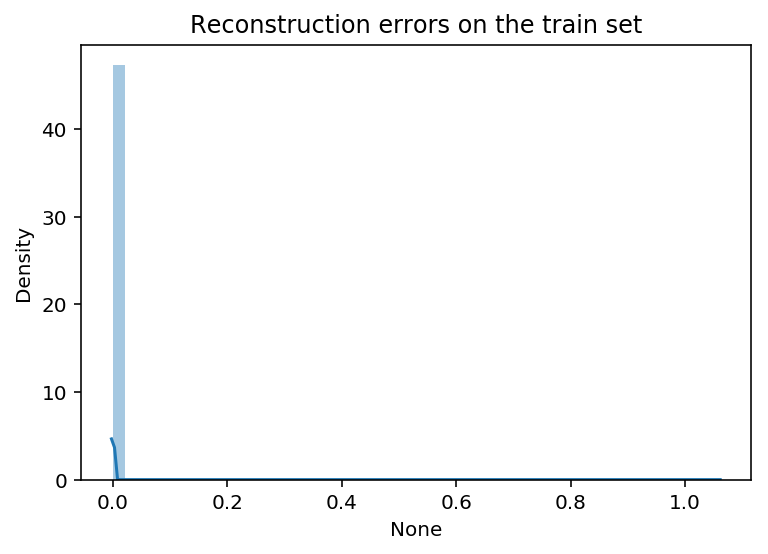

In [40]:
threshold = Threshold(losses_xtrain, "mean")
sns.distplot(losses_xtrain).set_title('Reconstruction errors on the train set')

/projects/71ee584d-df5c-4d26-93ed-cc9fd077f4d1/.sage/local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/projects/71ee584d-df5c-4d26-93ed-cc9fd077f4d1/.sage/local/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5,1,'Reconstruction errors on the test set')

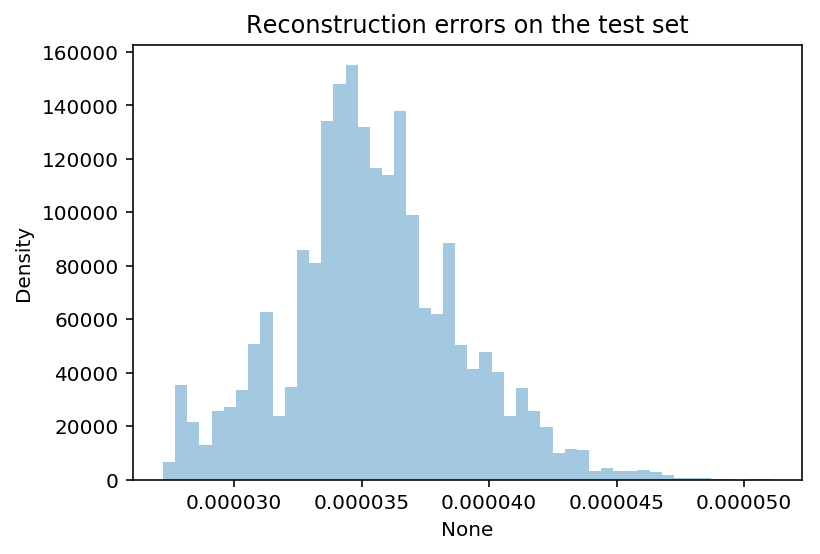

In [41]:
y_pred, losses_test = AnomalyDetection(x_test, AEmodel, threshold)
sns.distplot(losses_test).set_title('Reconstruction errors on the test set')

In [42]:
accuracy = accuracy_score(y_test, y_pred)
print ('Accuracy on test set:,{:.3f}'.format(accuracy))
print (classification_report(y_test, y_pred))

Accuracy on test set:,0.749
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      6012
         1.0       0.00      0.00      0.00      2016

    accuracy                           0.75      8028
   macro avg       0.37      0.50      0.43      8028
weighted avg       0.56      0.75      0.64      8028



/projects/71ee584d-df5c-4d26-93ed-cc9fd077f4d1/.sage/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
threshold_list = ["mean","median", "meanIQR", "meanstd", "std3","IQRq3","minmax"]

for i in threshold_list:
    threshold = Threshold (losses_xtrain, i)
    y_pred, losses_xtest = AnomalyDetection(x_test, AEmodel, threshold)
    accuracy = accuracy_score(y_test, y_pred)
    print (i+ ' threshold accuracy on test set:, {:.3f}'.format(accuracy))
    print (classification_report(y_test, y_pred))

mean threshold accuracy on test set:, 0.749
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      6012
         1.0       0.00      0.00      0.00      2016

    accuracy                           0.75      8028
   macro avg       0.37      0.50      0.43      8028
weighted avg       0.56      0.75      0.64      8028



/projects/71ee584d-df5c-4d26-93ed-cc9fd077f4d1/.sage/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


median threshold accuracy on test set:, 0.589
              precision    recall  f1-score   support

         0.0       0.82      0.58      0.68      6012
         1.0       0.33      0.63      0.43      2016

    accuracy                           0.59      8028
   macro avg       0.58      0.60      0.56      8028
weighted avg       0.70      0.59      0.62      8028



meanIQR threshold accuracy on test set:, 0.749
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      6012
         1.0       0.00      0.00      0.00      2016

    accuracy                           0.75      8028
   macro avg       0.37      0.50      0.43      8028
weighted avg       0.56      0.75      0.64      8028



meanstd threshold accuracy on test set:, 0.749
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      6012
         1.0       0.00      0.00      0.00      2016

    accuracy                           0.75      8028
   macro avg       0.37      0.50      0.43      8028
weighted avg       0.56      0.75      0.64      8028



std3 threshold accuracy on test set:, 0.749
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      6012
         1.0       0.00      0.00      0.00      2016

    accuracy                           0.75      8028
   macro avg       0.37      0.50      0.43      8028
weighted avg       0.56      0.75      0.64      8028



IQRq3 threshold accuracy on test set:, 0.758
              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      6012
         1.0       0.98      0.04      0.08      2016

    accuracy                           0.76      8028
   macro avg       0.87      0.52      0.47      8028
weighted avg       0.81      0.76      0.66      8028



minmax threshold accuracy on test set:, 0.749
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      6012
         1.0       0.00      0.00      0.00      2016

    accuracy                           0.75      8028
   macro avg       0.37      0.50      0.43      8028
weighted avg       0.56      0.75      0.64      8028

